
<img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="300" height="150"/>

<font size=6>Industrial Safety - NLP based Chatbot </font>

# **Problem Statement**

* **Domain:** Industrial safety – NLP-based chatbot.

* **Objective:** Design an ML/DL-based chatbot utility to highlight safety risks from incident descriptions.

### **Business Context**

The data originates from one of the largest industries in Brazil (and globally). Despite safety protocols, employees still suffer injuries and sometimes fatalities at industrial plants. Industries worldwide face the urgent need to understand accident causes and predict potential risks. A chatbot powered by NLP can assist professionals by analyzing incident descriptions and identifying safety risks efficiently.

### **Problem Definition**

Workplace accidents continue to occur, and understanding their root causes is critical. Current manual analysis is time-consuming and inconsistent. The project aims to develop an intelligent chatbot that processes textual accident descriptions and classifies the associated risks and severity. This enables proactive safety measures and improved industrial risk management.

### **Data Dictionary**

The dataset contains accident records from 12 plants across 3 countries. Each row represents an accident occurrence with the following fields:

* **Data:** Timestamp or date of the accident.

* **Countries:** Country where the accident occurred (anonymized).

* **Local:** City of the manufacturing plant (anonymized).

* **Industry Sector:** Sector to which the plant belongs.

* **Accident Level (I–VI):** Severity of the accident (I = not severe, VI = very severe).

* **Potential Accident Level:** Severity the accident could have reached under other factors.

* **Genre:** Gender of the person involved (male/female).

* **Employee or Third Party:** Whether the injured person is an employee or external party.

* **Critical Risk:** Description of the risk involved.

* **Description:** Detailed narrative of how the accident happened.

## **Installing and Importing Necessary Libraries**

In [1]:
# installing the sentence-transformers and gensim libraries for word embeddings
#!pip install -U numpy==2.0.1 scipy==1.14.1 sentence-transformers unidecode transformers tqdm -q
%pip install gensim unidecode scipy==1.13.1 numpy==1.26.4
# 1.14.1

In [2]:
%pip install zeugma==0.41

In [3]:
%pip install -U sentence-transformers -q

In [4]:
%pip install unidecode
%pip install langdetect

In [5]:
%pip install tensorflow==2.17.0 scikit-learn==1.5.2 scikeras==0.13.0

In [6]:
# ================================
# Core Python Libraries
# ================================
import re
import json
import math
import os
import warnings
warnings.filterwarnings("ignore")   # Suppress warnings for cleaner output

# ================================
# Data Handling
# ================================
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)  # Display full text in dataframe cells

# ================================
# Visualization
# ================================
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# NLP - NLTK
# ================================
import nltk
nltk.download('punkt')       # tokenizer
nltk.download('stopwords')   # stopword list
nltk.download('wordnet')     # lemmatizer

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# ================================
# Text Cleaning Utilities
# ================================
from unidecode import unidecode
from langdetect import detect

# ================================
# Statistical Tests
# ================================
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

# ================================
# Feature Extraction
# ================================
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA

# ================================
# ML Models & Evaluation
# ================================
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    recall_score,
    precision_score,
    f1_score,
    silhouette_score
)

# ================================
# Imbalanced Data Handling
# ================================
from imblearn.over_sampling import SMOTE

# ================================
# Word Embeddings
# ================================
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sentence_transformers import SentenceTransformer

# ================================
# Deep Learning
# ================================
import torch

# ================================
# Hugging Face & LLaMA
# ================================
from huggingface_hub import hf_hub_download

# ================================
# LSTM / Keras imports
# ================================
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.utils import register_keras_serializable
import numpy as np


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## **Import the dataset**

In [7]:
# config section

# path to csv file
path = '/content/drive/MyDrive/Capstone_Project/Data Set - industrial_safety_and_health_database_with_accidents_description.xlsx'
# path = '/content/drive/MyDrive/Capstone_AIML_NLP1/Data Set - industrial_safety_and_health_database_with_accidents_description.xlsx'


# path to glove input file
glove_input_file = '/content/drive/MyDrive/Capstone_Project/glove.6B.100d.txt.word2vec'
# glove_input_file = '/content/drive/MyDrive/Capstone_AIML_NLP1/glove.6B.100d.txt.word2vec'

# path to store output files
output_dir = "/content/drive/MyDrive/Capstone_AIML_NLP1/export"

# set random state
SEED=42
random_state=SEED
np.random.seed(SEED)
tf.random.set_seed(SEED)


# flag to split the dataset sequential or not
split_sequential = False


# Toggle switch to include non text fields in model training or not
include_non_text_features = False

# PCA config
perform_pca=True
pca_features=0.95

# set pandas dataframe maxwidth to None
pd.set_option('max_colwidth',None)

### Load the dataset

In [8]:
# import the dataset
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
accidents_data_orig = pd.read_excel(path)

In [10]:
# creating a copy of the accident data file
df = accidents_data_orig.copy()


### Data Overview

In [11]:
# View first 5 rows in the data
df.head()

Unnamed: 0       Data   Countries     Local Industry Sector Accident Level  \
0           0 2016-01-01  Country_01  Local_01          Mining              I   
1           1 2016-01-02  Country_02  Local_02          Mining              I   
2           2 2016-01-06  Country_01  Local_03          Mining              I   
3           3 2016-01-08  Country_01  Local_04          Mining              I   
4           4 2016-01-10  Country_01  Local_04          Mining             IV   

  Potential Accident Level Genre Employee or Third Party        Critical Risk  \
0                       IV  Male             Third Party              Pressed   
1                       IV  Male                Employee  Pressurized Systems   
2                      III  Male    Third Party (Remote)         Manual Tools   
3                        I  Male             Third Party               Others   
4                       IV  Male             Third Party               Others   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Description  
0                                                                                                           While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.  
1                                                                                                                                                                                                                                                                 During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter.  
2                                                                                                                                                                                                                                                          In the sub-station MILPO located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of ​​the left foot of the collaborator causing the injury.  
3  Being 9:45 am. approximately in the Nv. 1880 CX-695 OB7, the personnel begins the task of unlocking the Soquet bolts of the BHB machine, when they were in the penultimate bolt they identified that the hexagonal head was worn, proceeding Mr. Cristóbal - Auxiliary assistant to climb to the platform to exert pressure with your hand on the "DADO" key, to prevent it from coming out of the bolt; in those moments two collaborators rotate with the lever in anti-clockwise direction, leaving the key of the bolt, hitting the palm of the left hand, causing the injury.  
4                                                                             Approximately at 11:45 a.m. in circumstances that the mechanics Anthony (group leader), Eduardo and Eric Fernán

**Observations**

**Small Dataset Size**:

With only 425 records, this is a relatively small dataset for training a machine learning model, especially for a multi-class classification problem. This small size could make it challenging for the models to generalize well to unseen data, and it highlights the importance of techniques like SMOTE to prevent overfitting and improve performance on minority classes.

**Text-heavy Feature**:

The Description column is the most important feature for this project. It's unstructured, natural language text that will require careful NLP preprocessing to extract meaningful information. The quality and detail of these descriptions will directly impact the model's ability to accurately classify risk levels.

**Target Variable Skew**:

The problem statement mentions that Accident Level is the target variable. It's highly probable that this variable is imbalanced, meaning there are far fewer instances of severe accidents (Levels IV, V, VI) than less severe ones (Levels I, II).

**Mixed Data Types:**

The dataset contains a mix of data types, including textual descriptions, dates (Data), and categorical variables like Countries, Genre, and Critical Risk. To use this data effectively, there is a need to correctly identify and convert some of the categorical and textual data into numerical formats.

**Rich Contextual Information:**

Beyond the Description, the Critical Risk column provides a summarized, high-level view of the hazard (e.g., "Pressurized Systems"). This could be a very valuable feature. We might consider using both the detailed Description and the more concise Critical Risk to train the models, as they offer complementary information.

**Anonymized Data**:

The Countries and Local columns are anonymized. This is a common practice to protect proprietary information but still allows for analysis of geographical patterns without revealing specific locations.

In [12]:
# View last 5 rows in the data
df.tail()

Unnamed: 0       Data   Countries     Local Industry Sector  \
420         434 2017-07-04  Country_01  Local_04          Mining   
421         435 2017-07-04  Country_01  Local_03          Mining   
422         436 2017-07-05  Country_02  Local_09          Metals   
423         437 2017-07-06  Country_02  Local_05          Metals   
424         438 2017-07-09  Country_01  Local_04          Mining   

    Accident Level Potential Accident Level   Genre Employee or Third Party  \
420              I                      III    Male             Third Party   
421              I                       II  Female                Employee   
422              I                       II    Male                Employee   
423              I                       II    Male                Employee   
424              I                       II  Female             Third Party   

                    Critical Risk  \
420                        Others   
421                        Others   
422              Venomous Animals   
423                           Cut   
424  Fall prevention (same level)   

                                                                                                                                                                                                                                                     Description  
420                                 Being approximately 5:00 a.m. approximately, when lifting the Kelly HQ towards the pulley of the frame to align it, the assistant Marco that is in the later one is struck the hand against the frame generating the injury.  
421                                  The collaborator moved from the infrastructure office (Julio to the toilets, when the pin of the right shoe is hooked on the bra of the left shoe causing not to take the step and fall untimely, causing injury described.  
422  During the environmental monitoring activity in the area, the employee was surprised by a swarming swarm of weevils. During the exit of the place, endured suffering two stings, being one in the face and the other in the middle finger of the left hand.  
423                                                                  The Employee performed the activity of stripping cathodes, when pulling the cathode sheet his hand hit the side of another cathode, causing a blunt cut on his 2nd finger of the left hand.  
424                                             At 10:00 a.m., when the assistant cleaned the floor of module "E" in the central camp, she slipped back and immediately grabbed the laundry table to avoid falling to the floor; suffering the described injury.

**Observations**

* The dataset ends in **July 2017**, with the last recorded accident on **2017-07-09**.
* All last 5 incidents are of **low severity (Accident Level I)**, but potential levels range from **II to III**.
* Both **employees** and **third parties** are represented, showing consistent risk exposure across groups.
* Accident causes include **Others**, **Venomous Animals**, **Cut**, and **Fall prevention**, highlighting diverse hazard types.
* Gender diversity is visible, with both **male** and **female** workers involved in the latest records.

In [13]:
# Inspect random 5 rows
df.sample(5, random_state=42)

Unnamed: 0       Data   Countries     Local Industry Sector  \
417         431 2017-06-22  Country_03  Local_10          Others   
75           87 2016-04-02  Country_01  Local_01          Mining   
176         190 2016-07-20  Country_02  Local_05          Metals   
30           30 2016-02-17  Country_01  Local_03          Mining   
357         371 2017-03-18  Country_01  Local_03          Mining   

    Accident Level Potential Accident Level Genre Employee or Third Party  \
417              I                       IV  Male                Employee   
75               I                      III  Male                Employee   
176              I                      III  Male                Employee   
30               I                       II  Male                Employee   
357              V                        V  Male    Third Party (Remote)   

           Critical Risk  \
417               Others   
75                Others   
176  Chemical substances   
30                Others   
357           Power lock   

                                                                                                                                                                                                                                                                                                                                                                                                           Description  
417                                                                                                                                                                                                       The technician was returning from his activities on the bite, when he stepped on a loose rock over a sloping region. She released herself unbalancing the employee who stepped on false, twisting her ankle.  
75   Parking the equipment Dumper ° 18 in the maintenance workshop, the mechanic asks the operator to back off the equipment for washing, then the operator starts the reverse gear with the cab door fully open, upon reaching the washing area (8 meters behind), brakes and the cabin door closes untimely and hits your face, causing a minor injury. In the area was the mechanic at floor level in a safe place.  
176                                                                                                                                                                                                                                                           The employee reports that he was draining ammonia, used as a refrigerant, into a container of water when splashes of the solution drained onto his face.  
30                                                                                       When the plant operator was semi-kneeling when lifting the lid or gate (15 kg) of the distributor box of the secondary mill No. 4 and No. 5, his right knee slips due to the presence of debris spilled on the platform or floor (Grating) - which gave him an extra effort in his left leg, generating a muscle contracture.  
357                      During the activity of changing conveyor belt 11B feeding the primary mill No. 2; the mechanic entered the discharge chute (0.75 x 0.75 x 0.80 m.) to clean the material, at which time the automatic sampler (0.30 x 0.25 m) that was inside the chute was activated, trapping the mechanic at the height of the chest. At the time of the accident the mechanic was alone in the work area.

**Observations**

* The sample covers incidents from **Feb 2016** to **Jun 2017**, across multiple sectors like **Mining, Metals, and Others**.
* Most cases have **Accident Level I** with potential escalation to **II–IV**, except one severe case at **Level V**.
* **Employees** are primarily involved, but there is also a serious case affecting a **Third Party (Remote)**.
* Common risks include **Others**, **Chemical substances**, and **Power lock**, reflecting varied hazard categories.
* All 5 sampled records involve **male workers**, suggesting possible gender imbalance in the dataset.

In [14]:
# print the shape
df.shape

(425, 11)

**Observation**

The data has 425 rows and 11 columns

In [15]:
# analyze the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Unnamed: 0                425 non-null    int64         
 1   Data                      425 non-null    datetime64[ns]
 2   Countries                 425 non-null    object        
 3   Local                     425 non-null    object        
 4   Industry Sector           425 non-null    object        
 5   Accident Level            425 non-null    object        
 6   Potential Accident Level  425 non-null    object        
 7   Genre                     425 non-null    object        
 8   Employee or Third Party   425 non-null    object        
 9   Critical Risk             425 non-null    object        
 10  Description               425 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 36.7+ KB


**Observations:**

* The dataset contains **425 records** with **11 columns**.
* All columns are **complete (no missing values)**, ensuring clean input for modeling.
* The **Data** column is in **datetime** format, while most others are **categorical (object)**.
* The dataset is lightweight, using only **36.7 KB** of memory, making it easy to handle in analysis.
* The column **Unnamed: 0** looks like an **index column** and **can be safely dropped**.

###Rename columns for better readability and consistency

In [16]:
# Rename columns for better readability and consistency
df.rename(columns={
    'Data': 'Date',                     # Standardize 'Data' to 'Date'
    'Countries': 'Country',             # Simplify 'Countries' to 'Country'
    'Genre': 'Gender',                  # Replace 'Genre' with 'Gender'
    'Employee or Third Party': 'Employee type'  # Shorten long column name
}, inplace=True)

###The **Accident Level** and **Potential Accident Level** are stored as **object (string)** types in dataset— Lets convert them into **ordered categorical/numeric levels** to understand accident severity pattern.

In [17]:
# Step 1: copy df into df_accident_analysis
df_accident_analysis = df.copy()

# Step 2: Convert "Accident Level" and "Potential Accident Level" into ordered categorical → numeric
# Accident levels are from I to VI (Roman numerals)
level_order = ["I", "II", "III", "IV", "V", "VI"]

# Map levels to numbers
level_mapping = {level: idx+1 for idx, level in enumerate(level_order)}

df_accident_analysis["Accident Level Num"] = df_accident_analysis["Accident Level"].map(level_mapping)
df_accident_analysis["Potential Accident Level Num"] = df_accident_analysis["Potential Accident Level"].map(level_mapping)

# Show sample to verify
df_accident_analysis[["Accident Level", "Accident Level Num", "Potential Accident Level", "Potential Accident Level Num"]].head(10)

Accident Level  Accident Level Num Potential Accident Level  \
0              I                   1                       IV   
1              I                   1                       IV   
2              I                   1                      III   
3              I                   1                        I   
4             IV                   4                       IV   
5              I                   1                      III   
6              I                   1                      III   
7              I                   1                      III   
8              I                   1                       IV   
9              I                   1                       II   

   Potential Accident Level Num  
0                             4  
1                             4  
2                             3  
3                             1  
4                             4  
5                             3  
6                             3  
7                             3  
8                             4  
9                             2

###Check Statistical summary

In [18]:
# describe the numerical datatypes
df_accident_analysis.describe().T

count                           mean  \
Unnamed: 0                    425.0                     224.084706   
Date                            425  2016-09-20 16:46:18.352941312   
Accident Level Num            425.0                       1.527059   
Potential Accident Level Num  425.0                       3.035294   

                                              min                  25%  \
Unnamed: 0                                    0.0                118.0   
Date                          2016-01-01 00:00:00  2016-05-01 00:00:00   
Accident Level Num                            1.0                  1.0   
Potential Accident Level Num                  1.0                  2.0   

                                              50%                  75%  \
Unnamed: 0                                  226.0                332.0   
Date                          2016-09-13 00:00:00  2017-02-08 00:00:00   
Accident Level Num                            1.0                  2.0   
Potential Accident Level Num                  3.0                  4.0   

                                              max         std  
Unnamed: 0                                  438.0  125.526786  
Date                          2017-07-09 00:00:00         NaN  
Accident Level Num                            5.0    1.023243  
Potential Accident Level Num                  6.0    1.155861

**Observations:**

* The dataset spans from **Jan 2016** to **Jul 2017**, with a median accident date around **Sep 2016**.
* The average **Accident Level** is **1.53**, showing that most recorded incidents are of **low severity**.
* The average **Potential Accident Level** is **3.03**, indicating that many minor accidents had the potential to become **moderately severe**.
* **Accident Level Num** ranges from **1 (least severe)** to **5**, while **Potential Accident Level Num** spans the full range up to **6**.
* The higher mean of potential levels vs. actual levels suggests frequent **near-miss scenarios** in the dataset.

In [19]:
# describe the object datatypes
df.describe(include='object')

Country     Local Industry Sector Accident Level  \
count          425       425             425            425   
unique           3        12               3              5   
top     Country_01  Local_03          Mining              I   
freq           251        90             241            316   

       Potential Accident Level Gender Employee type Critical Risk  \
count                       425    425           425           425   
unique                        6      2             3            33   
top                          IV   Male   Third Party        Others   
freq                        143    403           189           232   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Description  
count                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          425  
unique                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         411  
top     On 02/03/17 during the soil sampling in the region of Sta. the employees Rafael and Danillo da Silva were attacked by a bee test. They rushed away from the place, but the employee Rafael took 4 bites, one on the chin, one on the chest, one on the neck and one on the hand over the glove. The employee took 4 bites, one in his hand over his glove and the other in the head, and the employee Danillo took 2 bites in the left arm over his uniform. At first no one sketched allergy, just swelling at the sting site. The activity was stopped to evaluate the site, after verifying that the test had remained in the line, they left the site.  
freq                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             3

**Observations**

* The dataset covers **3 countries** and **12 plant locations**, with **Country_01** and **Local_03** being most frequent.
* The majority of records belong to the **Mining** sector (~241 out of 425).
* **Accident Level I** dominates with 316 cases, while potential severity peaks at **Level IV** (143 cases).
* **Male workers** form the vast majority (403), compared to very few female cases.
* Most incidents involve **Third Party** workers (189), showing higher risk outside core employees.
* A wide variety of **33 critical risks** are reported, with **Others** being the most common (232 cases).
* Accident descriptions are highly diverse (**411 unique texts**), but some duplicates exist with the most frequent narrative repeated **3 times**.

## **Data Cleansing**

### Drop unique features

In [20]:
# Lets drop the unnamed column that just has serial number
df.drop(df.columns[0], axis=1, inplace=True)

**Observation**

* The unnecessary column **Unnamed: 0** was dropped, leaving only meaningful data fields.

### Handle missing values

In [21]:
# check for null values
df.isnull().sum()

Date                        0
Country                     0
Local                       0
Industry Sector             0
Accident Level              0
Potential Accident Level    0
Gender                      0
Employee type               0
Critical Risk               0
Description                 0
dtype: int64

**Observation**
* There are no null values in the dataset.

### Handle duplicated rows

In [22]:
# check for duplicated rows
df.duplicated().sum()

7

**Observation**

* There are 7 duplicate rows in the dataset

In [23]:
# Show all 7 duplicate rows
duplicate_rows = df[df.duplicated(keep=False)]
print("Duplicate rows found:")
duplicate_rows

Duplicate rows found:


Date     Country     Local Industry Sector Accident Level  \
76  2016-04-01  Country_01  Local_01          Mining              I   
77  2016-04-01  Country_01  Local_01          Mining              I   
261 2016-12-01  Country_01  Local_03          Mining              I   
262 2016-12-01  Country_01  Local_03          Mining              I   
302 2017-01-21  Country_02  Local_02          Mining              I   
303 2017-01-21  Country_02  Local_02          Mining              I   
344 2017-03-02  Country_03  Local_10          Others              I   
345 2017-03-02  Country_03  Local_10          Others              I   
346 2017-03-02  Country_03  Local_10          Others              I   
354 2017-03-15  Country_03  Local_10          Others              I   
355 2017-03-15  Country_03  Local_10          Others              I   
396 2017-05-23  Country_01  Local_04          Mining              I   
397 2017-05-23  Country_01  Local_04          Mining              I   

    Potential Accident Level Gender         Employee type  \
76                         V   Male  Third Party (Remote)   
77                         V   Male  Third Party (Remote)   
261                       IV   Male              Employee   
262                       IV   Male              Employee   
302                        I   Male  Third Party (Remote)   
303                        I   Male  Third Party (Remote)   
344                        I   Male           Third Party   
345                        I   Male           Third Party   
346                        I   Male           Third Party   
354                        I   Male           Third Party   
355                        I   Male           Third Party   
396                       IV   Male           Third Party   
397                       IV   Male           Third Party   

               Critical Risk  \
76                    Others   
77                    Others   
261                   Others   
262                   Others   
302                   Others   
303                   Others   
344         Venomous Animals   
345         Venomous Animals   
346         Venomous Animals   
354         Venomous Animals   
355         Venomous Animals   
396  Projection of fragments   
397  Projection of fragments   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Description  
76   In circumstances that two workers of the Abratech company were doing putty work inside the conditioning tank (5 meters deep and covered by platforms) of metal gratings - grating- in the upper part), two other employees of the HyT company carried out maneuvers transfer of a pump with the help of a manual tick - which worked hooked to a beam H, dragging the pump on the metal gratings (grating), suddenly the pump is hooked with a metal grate (grating) and when trying to release it, the metal grid (grating - 13.0 Kg. (60 cm x 92 cm)) falls inside the tank, hits a diagonal channel inside the tank and then impacts the right arm of one of the workers and rubs the helmet of the second worker that he was crouching. The area where the bomb was being moved was marked with tape and did not have a lookout.  
77   In circumstances that two workers of the Abratech company were doing putty work in

**Observations**

* A total of **7 duplicate accident cases** were detected in the dataset.
* Each duplicate pair has **identical values across all columns**, indicating repeated accident entries.
* Examples include repeated records for **2016-04-01, 2016-12-01, 2017-01-21, 2017-03-02, 2017-03-15, and 2017-05-23**.
* Duplicate scenarios involve risks like **Others**, **Venomous Animals**, and **Projection of fragments**.
* Removing these ensures **cleaner data** and prevents **bias in model training** from overrepresented accidents.

###Dropping duplicate data

In [24]:
# drop the rows keeping the first row
df.drop_duplicates(keep='first',inplace=True)
df.reset_index(drop=True, inplace=True)

In [25]:
# confirm there are no duplicates
df.duplicated().sum()

0

**Observation**

* There are no more duplcate rows.
But we observed that **there are some repeations in the incident descriptions** lets analyze the repeated descriptions.

In [26]:
# print duplicate descriptions
df_desc = df['Description']
df_desc.duplicated().sum()

7

####There are still about 7 repeated incident descriptions. Lets analyze them ...

In [27]:
df[df_desc.duplicated(keep=False)]

Date     Country     Local Industry Sector Accident Level  \
37  2016-02-24  Country_02  Local_07          Mining              I   
38  2016-02-24  Country_02  Local_07          Mining              I   
129 2016-05-26  Country_03  Local_10          Others              I   
130 2016-05-26  Country_03  Local_10          Others              I   
142 2016-06-08  Country_03  Local_10          Others              I   
143 2016-06-08  Country_03  Local_10          Others              I   
165 2016-07-07  Country_01  Local_03          Mining             IV   
166 2016-07-07  Country_01  Local_03          Mining              I   
260 2016-12-01  Country_01  Local_03          Mining              I   
261 2016-12-01  Country_01  Local_03          Mining              I   
381 2017-05-06  Country_02  Local_07          Mining             IV   
382 2017-05-06  Country_02  Local_07          Mining             II   
405 2017-06-20  Country_01  Local_01          Mining              I   
406 2017-06-20  Country_01  Local_01          Mining              I   

    Potential Accident Level  Gender Employee type Critical Risk  \
37                         V    Male      Employee        Others   
38                         V  Female   Third Party        Others   
129                        I    Male   Third Party          Bees   
130                        I    Male      Employee        Others   
142                        I    Male   Third Party          Bees   
143                        I    Male   Third Party        Others   
165                        V    Male   Third Party        Others   
166                       IV    Male   Third Party        Others   
260                       IV    Male      Employee        Others   
261                       IV    Male   Third Party        Others   
381                        V    Male      Employee    Projection   
382                        V    Male      Employee    Projection   
405                       IV    Male      Employee        Others   
406                       IV    Male   Third Party        Others   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Description  
37                                                                                                                                                                                                                                                                                                                                                                                                           When starting the activity of removing a coil of electric cables in the warehouse with the help of forklift truck the operator did not notice that there was a beehive in it. Due to the movement of the coil the bees were excited. Realizing the fact the operator turned off the equipment and left the area. People passing by were stung.  
38                                                                                                                                                                                                                                                                                                                                                                                                           When starting the activity of removing a coil of electric 

**Observations**:

* Rows 37 (Employee) and **38** (Third Party) refer to a mining incident where one Employee and one Third Party individual were impacted.

* Rows 129 (Bees) and **130** (Other) refer to a Bees incident involving one Employee and one Third Party individual. Here, the Third Party row identified the Critical Risk.

* Rows 142 (Bees) and **143** (Other) describe another Bees incident affecting one Employee and one Third Party individual. Here again, the Third Party row identified the Critical Risk.

* Rows 165 (Accident Level IV) and **166** (Accident Level I) refer to an incident where the person in Row 165 was more severely impacted.

* Rows 260 (Employee) and **261** (Third Party) represent the same incident where one Employee and one Third Party individual were impacted.

* Rows 381 (Accident Level IV) and **382** (Accident Level II) refer to a mining incident where one Employee was injured more severely than the other.

* Rows 405 (Employee) and **406** (Third Party) describe the same incident involving one Employee and one Third Party individual.



If the same incident description is repeated, it is proposed to retain only one record based on the following rules:

* Keep the row containing more detailed information.

* If information is similar, retain the row with the higher Accident Level.

* If still identical, prioritize keeping the Employee record over the Third Party record.

Based on these rules, all the highlighted rows have been dropped i.e
38,130, 143, 166, 261, 382, 406


###Dropping duplicate incident descriptions

In [28]:
# drop the records with the repeated incidents
df.drop([38,130, 143, 166, 261, 382, 406], inplace=True)
df.reset_index(inplace=True, drop=True)
df.head(2)

Date     Country     Local Industry Sector Accident Level  \
0 2016-01-01  Country_01  Local_01          Mining              I   
1 2016-01-02  Country_02  Local_02          Mining              I   

  Potential Accident Level Gender Employee type        Critical Risk  \
0                       IV   Male   Third Party              Pressed   
1                       IV   Male      Employee  Pressurized Systems   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Description  
0  While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.  
1                                                                                                                                                        During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter.

In [29]:
# verify there are no repeated incidents
df['Description'].duplicated().sum()

0

### Check for outliers in the data

In [30]:
for x in df.columns:
    if x != 'Description':
        print('--'*30)
        print(f'Unique values of "{x}" column')
        print('--'*30)
        print(df[x].unique())
        print('\n')

------------------------------------------------------------
Unique values of "Date" column
------------------------------------------------------------
<DatetimeArray>
['2016-01-01 00:00:00', '2016-01-02 00:00:00', '2016-01-06 00:00:00',
 '2016-01-08 00:00:00', '2016-01-10 00:00:00', '2016-01-12 00:00:00',
 '2016-01-16 00:00:00', '2016-01-17 00:00:00', '2016-01-19 00:00:00',
 '2016-01-26 00:00:00',
 ...
 '2017-06-24 00:00:00', '2017-06-20 00:00:00', '2017-06-23 00:00:00',
 '2017-06-19 00:00:00', '2017-06-22 00:00:00', '2017-06-29 00:00:00',
 '2017-07-04 00:00:00', '2017-07-05 00:00:00', '2017-07-06 00:00:00',
 '2017-07-09 00:00:00']
Length: 287, dtype: datetime64[ns]


------------------------------------------------------------
Unique values of "Country" column
------------------------------------------------------------
['Country_01' 'Country_02' 'Country_03']


------------------------------------------------------------
Unique values of "Local" column
-----------------------------

**Observations**

- There are records of accidents from 1st Jan 2016 to 9th July 2017 in every month. So there are no outliers in the 'Date' column.

- There are only three country types so there are no outliers in 'Country' column.

- There are 12 Local cities where manufacturing plant is located and it's types are in sequence so there are no outliers in 'Local' column.

- There are only three Industry Sector types which are in sequence so there are no outliers in 'Industry Sector' column.

- There are only five Accident Level types which are in sequence so there are no outliers in 'Accident Level' column.

- There are only six Potential Accident Level types which are in sequence so there are no outliers in 'Potential Accident Level' column.

- There are only two Gender types in the provided data so there are no outliers in 'Gender' column.

- There are only three Employee types in the provided data so there are no outliers in 'Employee' column.

- There are quite a lot of Critical risk descriptions hence little difficult to find the outliers in this column.

## **Exploratory Data Analysis**



### Univariate Analysis

####**Analysis of incident Description**
* Compute and check the distribution of the length of **incident description content**

---

**Boxplot and Histogram Function for Incident description length**

In [31]:
# Add the feature of the length of text
df['Desc_Len'] = df['Description'].apply(len)

**Observations**:

* The feature contained no outliers.

* The distribution was slightly right-skewed.

* The distribution appeared to be slightly balanced.

In [32]:
# This function plots the box plot and histogram for numerical features in univarient analysis
def boxplot_histogram(data, feature, figsize=(15,8), kde=True, bins=None):
  """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default True)
    bins: number of bins for histogram (default None)
  """
  fig, (axes_box, axes_hist) = plt.subplots(nrows=2, sharex=True, gridspec_kw={"height_ratios": (0.35, 0.65)}, figsize=figsize)

  axes_box.set_title(f'Boxplot and histogram for {feature}')
  # boxplot
  sns.boxplot(data=data, x=feature, ax=axes_box, showmeans=True, color="violet")

  # histogram
  if bins :
    sns.histplot(data=data, x=feature, ax=axes_hist, kde=kde, bins=bins)
  else:
    sns.histplot(data=data, x=feature, ax=axes_hist, kde=kde)

  # set mean and median in histogram
  axes_hist.axvline(data[feature].mean(), color='green', linestyle='--')
  axes_hist.axvline(data[feature].median(), color='black', linestyle='-')
  plt.show()

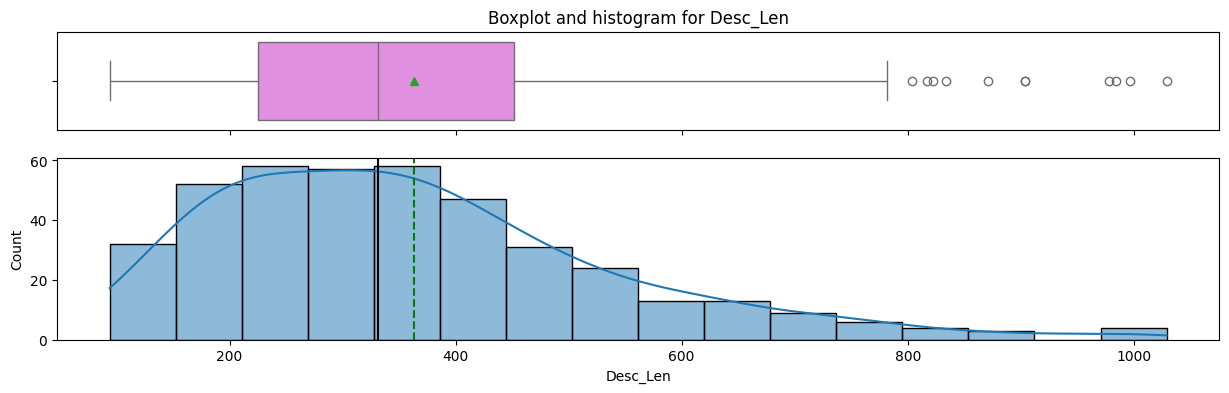

In [33]:
# plot the description length
boxplot_histogram(df,'Desc_Len',(15,4))

**Observations**:
* The distribution of incident description lengths contains outliers at the upper bound.

* The distribution is close to normal.

* The distribution is slightly right-skewed.

**Word Cloud Visualization**

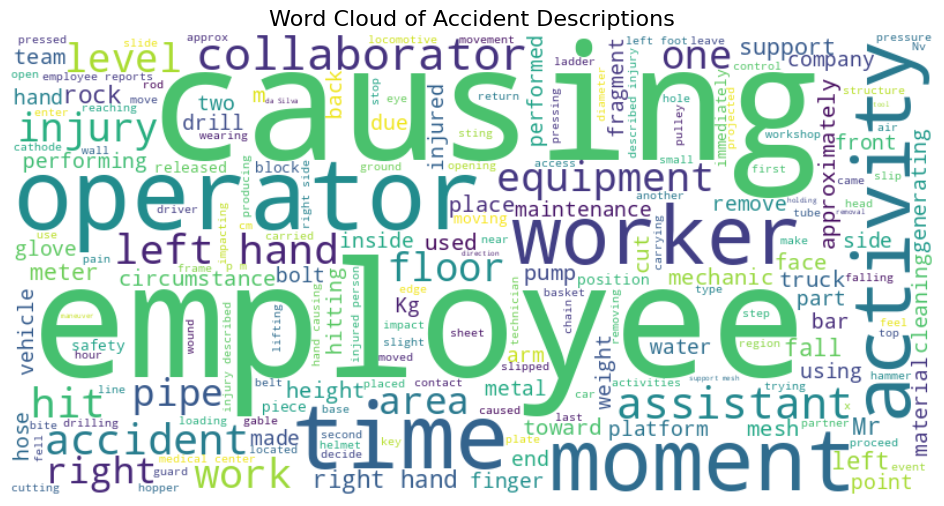

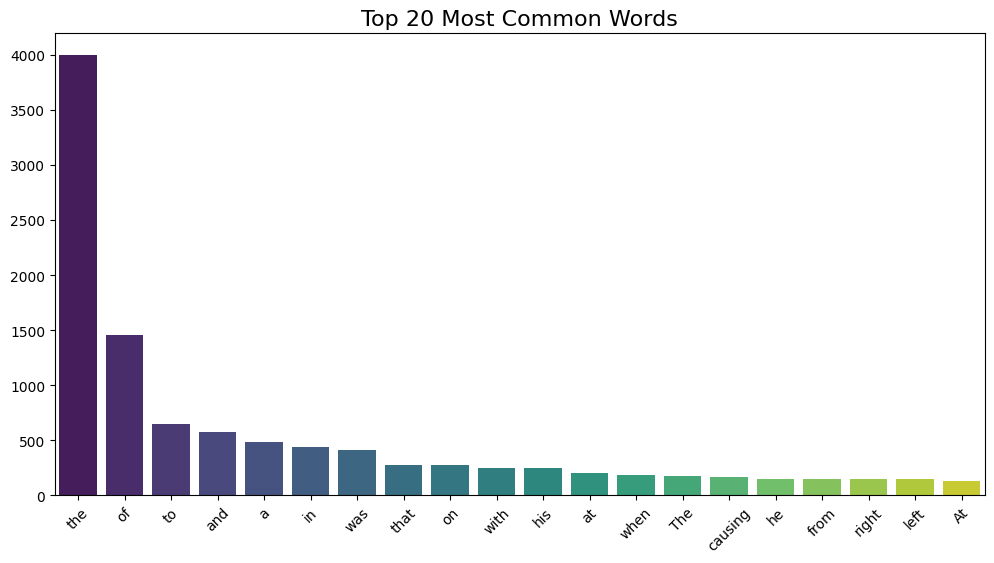

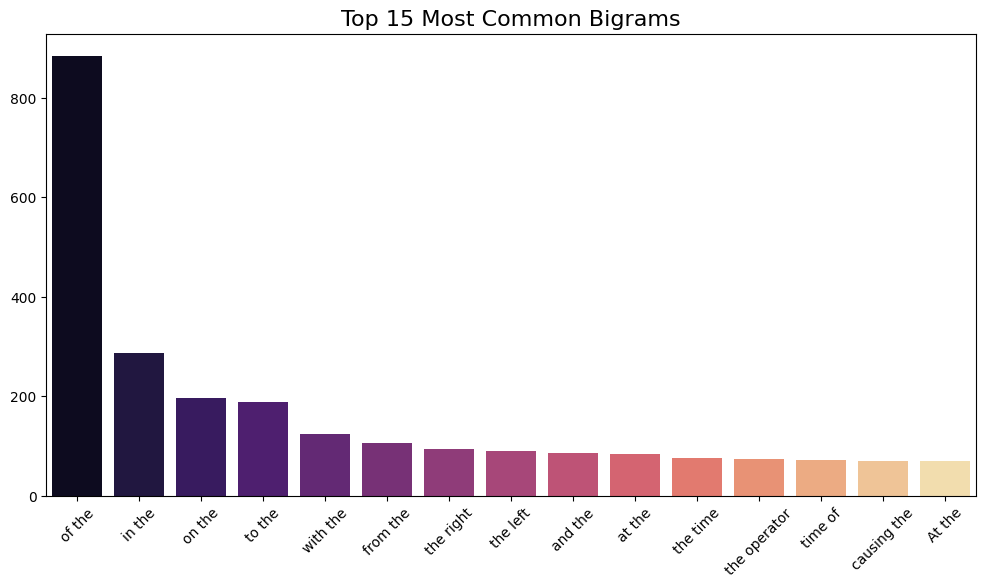

In [34]:
# ================================
# Word Cloud Visualization
# ================================

from collections import Counter
from wordcloud import WordCloud

# 1. Word Cloud for accident descriptions
all_text = " ".join(df['Description'])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Accident Descriptions", fontsize=16)
plt.show()

# 2. Top 20 most common words (bar chart)
word_freq = Counter(all_text.split())
common_words = word_freq.most_common(20)

plt.figure(figsize=(12,6))
sns.barplot(x=[w for w, _ in common_words], y=[c for _, c in common_words], palette="viridis")
plt.title("Top 20 Most Common Words", fontsize=16)
plt.xticks(rotation=45)
plt.show()

# 3. Bigram (two-word phrases) analysis
from nltk import ngrams

bigrams = ngrams(all_text.split(), 2)
bigram_freq = Counter(bigrams).most_common(15)

plt.figure(figsize=(12,6))
sns.barplot(x=[" ".join(bg) for bg, _ in bigram_freq], y=[c for _, c in bigram_freq], palette="magma")
plt.title("Top 15 Most Common Bigrams", fontsize=16)
plt.xticks(rotation=45)
plt.show()

**Observations**

* The word cloud highlights frequent accident-related terms like **employee**, **causing**, **operator**, **worker**, and **moment**, reflecting common accident contexts.
* The top 20 words are dominated by generic English stopwords (**the, of, to, and, a**), but domain-specific words like **causing, employee, right, left, hit** also appear.
* Bigram analysis shows frequent contextual pairs like **of the**, **in the**, and **on the**, but also domain-specific pairs like **the operator**, **causing the**, and **at the time**.
* Overall, accident descriptions are **action-oriented** (e.g., “hit”, “causing”, “injury”) and revolve around **workers and equipment interaction**.
* Removing common stopwords could reveal more **domain-specific accident terms** in the word frequency analysis.

#### **Analysis of other individual variables**

---



**Boxplot and Histogram for Dates**

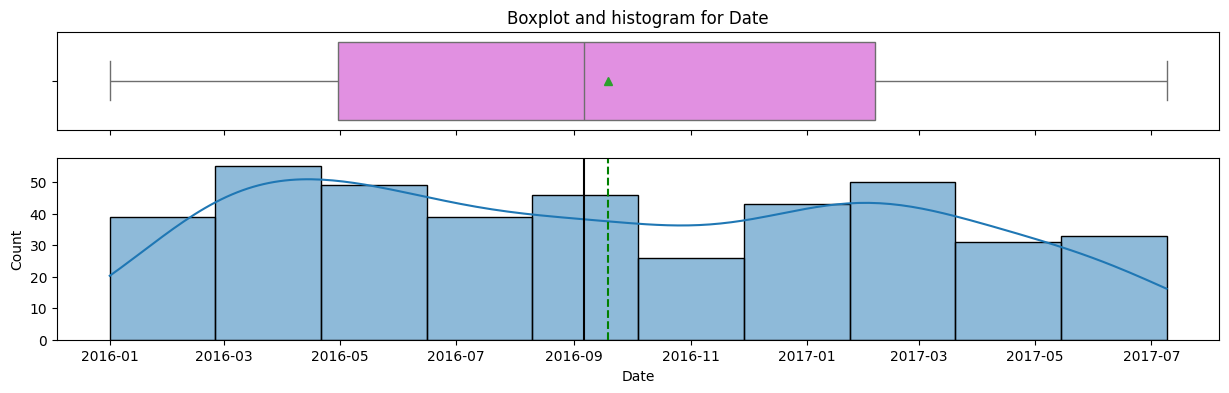

In [35]:
# plot the feature Open
boxplot_histogram(df,'Date',(15,4))

**Pi-chart for distribution of Countries**

Distributon of Country label


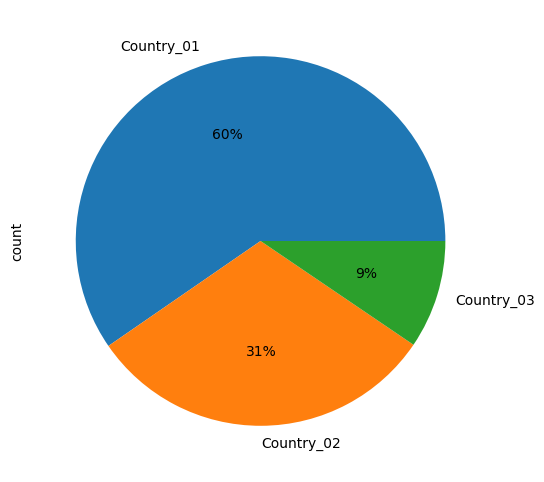

In [36]:
#analyzing the distribution of country
print('Distributon of Country label')
_ = df['Country'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Country_01', 'Country_02', 'Country_03'], figsize = (10, 6))

**Observations**

- 59% accidents occurred in Country_01,31% accidents occurred in Country_02 & 10% accidents occurred in Country_03.
- Hence the strategies used in the Country_03 should be adopted in both the countries

In [37]:
# plot a barplot with labels for given features
def labelled_barplot(data, features,cols=1,figsize=None, legend=True, bivarient=False):
  rows = (len(features)+cols - 1)//cols
  if figsize is None:
    plt.figure(figsize=(cols*6,rows*4))
  else:
    plt.figure(figsize=figsize)


  for i,feature in enumerate(features):
    plt.subplot(rows,cols,i+1)

    if bivarient == True:
      hue='Label'
    else:
      hue = feature

    ax = sns.countplot(data, x=feature,palette="Paired",hue=hue,order=df[feature].value_counts().index)
    for container in ax.containers:
      ax.bar_label(container, fmt='%d', fontsize=10)
    ax.set_title(f'Count plot - {feature}')

    ax.tick_params(axis='x', rotation=90)
    if legend == False :
      ax.legend_.remove()

  plt.tight_layout()
  plt.show()

**Barplot to visualize distribution of Countries, Cities (Local), Industry Sector and Gender accross dataset**

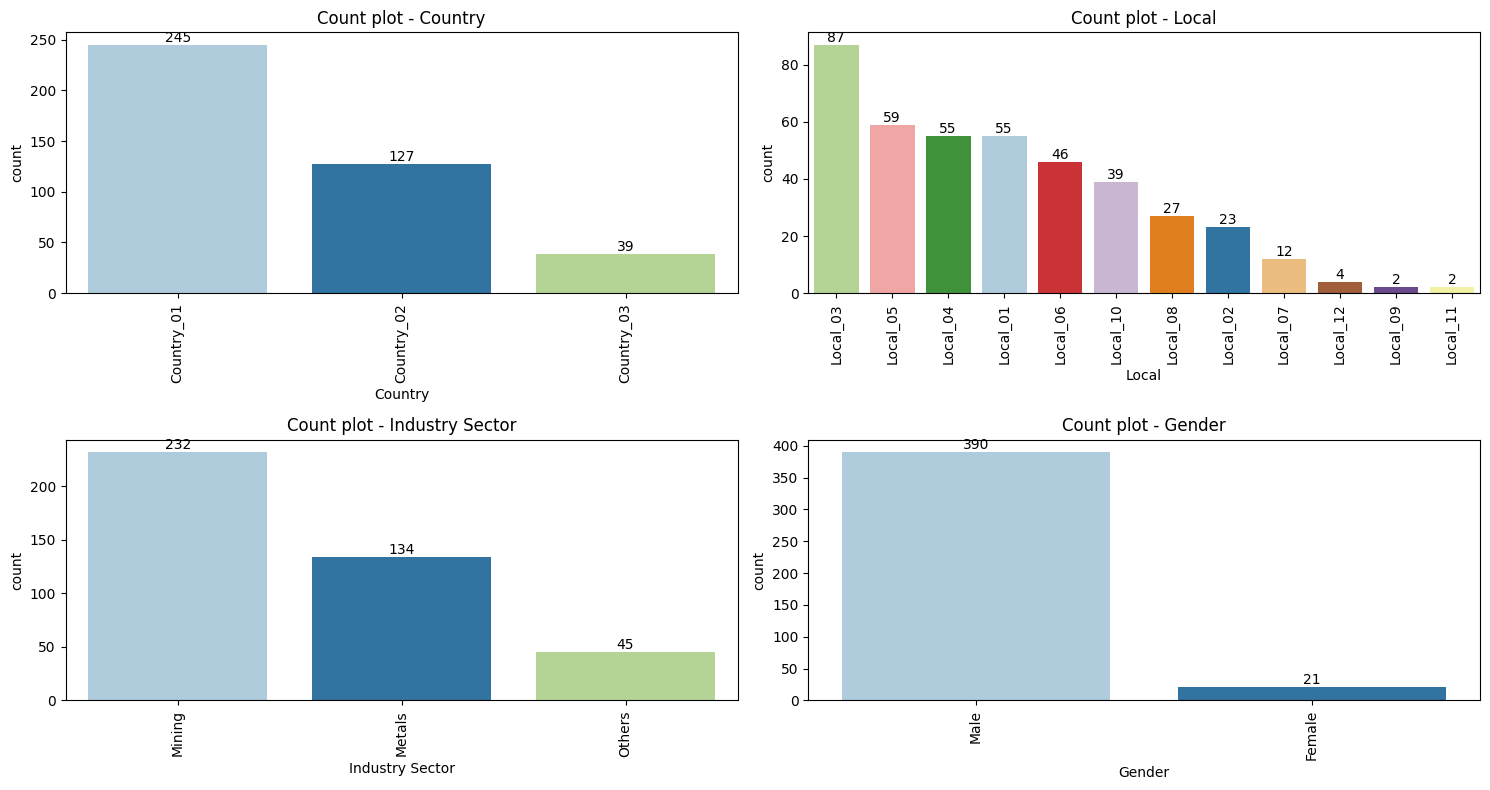

In [38]:
# count plot for Countries, Local, Industry Sector, Genre
labelled_barplot(df,['Country','Local', 'Industry Sector' , 'Gender' ],cols=2, figsize=(15,8))

**Observations**:

* The maximum number of incidents were recorded in `Country_01`, while the fewest were recorded in `Country_03`.

* City `Local_03` recorded the majority of incidents, whereas `Local_09`,`Local_11`  have the least.

* Most accidents occurred in the Mining sector.

* The `Male` workforce significantly outnumbered the `Female` workforce.

**Barplot to visualize distribution of Accident Level, Potential Accident Level, Critical Risk and Employee Type accross dataset**

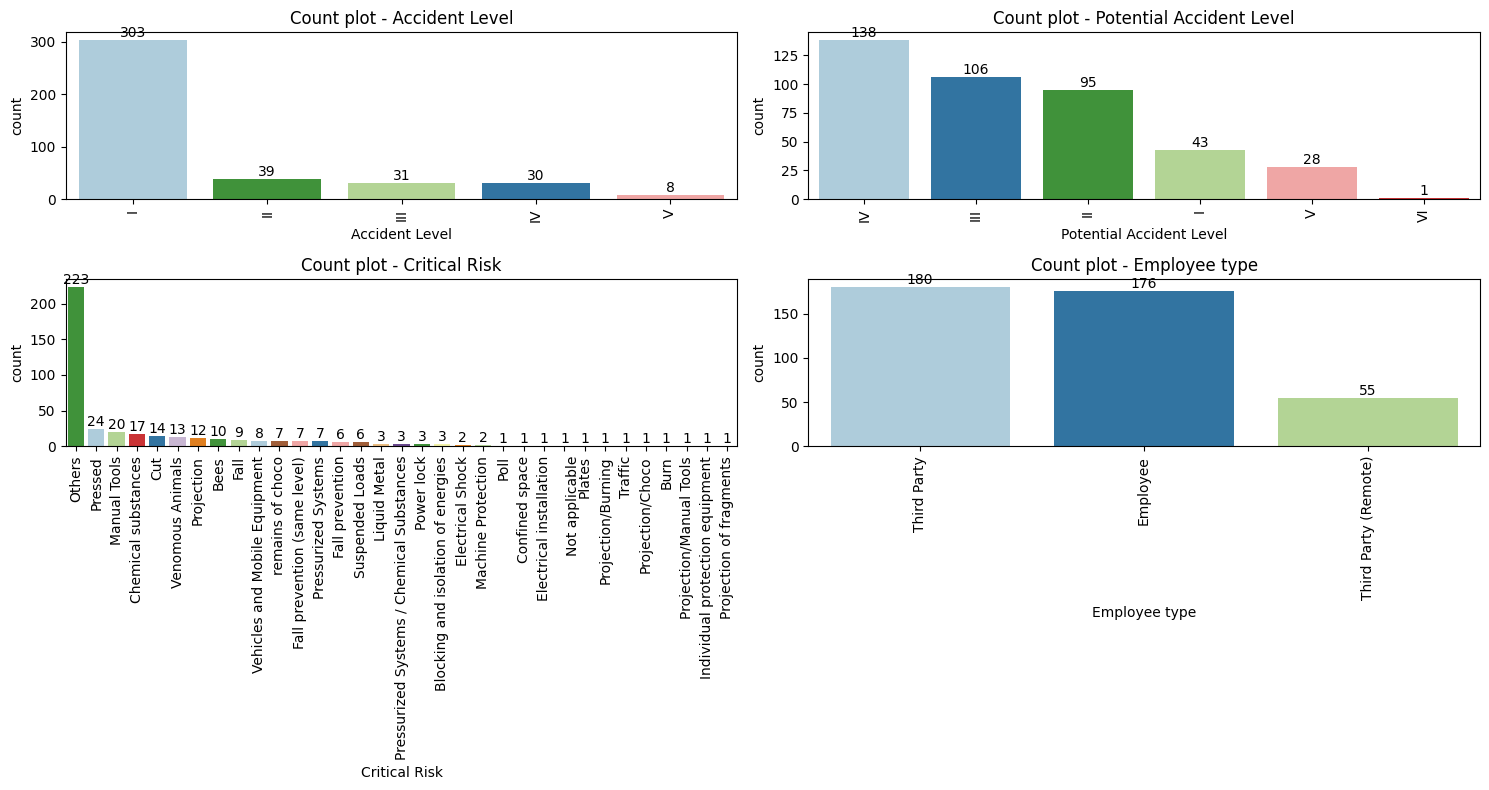

In [39]:
# count plot for Accident Level, Potential Accident Level, Critical Risk, Employee or Third Party
labelled_barplot(df,['Accident Level','Potential Accident Level', 'Critical Risk' , 'Employee type' ],cols=2, figsize=(15,8))

**Observations**:

* The majority of incidents were recorded at `Accident Level I`( less severe), while only a few occurred at `Level V`(more severe).

* Most incidents were classified as `Potential Accident Level IV`, with only one incident at `Level VI`.

* For many incidents, the `Critical Risk` was not identified.

* The majority of incidents involved `Third Party`

**Line plot by Month - see the trend**

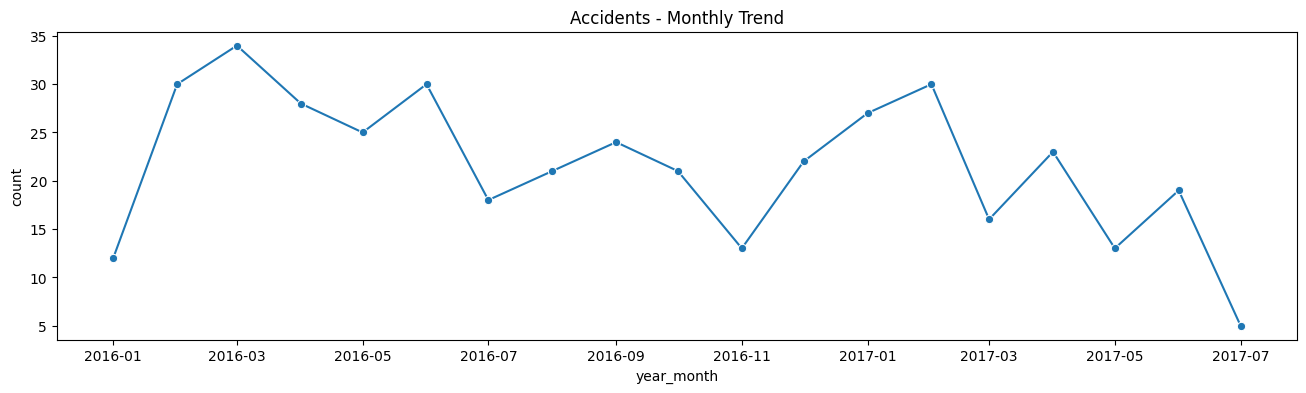

In [40]:
# Line plot by Month - see the trend
df['year_month'] = df['Date'].dt.to_period('M').dt.to_timestamp()
monthly_counts = df.groupby('year_month').size().reset_index(name='count')
plt.figure(figsize=(16, 4))
plt.title("Accidents - Monthly Trend", fontsize=12)
sns.lineplot(data=monthly_counts, x='year_month', y='count', marker='o')
plt.show()

**Observations**:

* Most accidents were observed in `February`, `March`, and `June`.

* This trend could be attributed to reduced focus during holiday periods and extreme or unfavorable weather conditions.

### Bivariate Analysis

**Labeled Stacked Bar Plot Function for Accident Level vs Country**

In [41]:
# This function plots the labelled stacked bar for the given feature
def labelled_stacked_bar(data, feature, target):
  """
  stacked bar plot with labelled percentages

  data: dataframe
  feature: dataframe column
  target : target variable
  """
  count = data[feature].nunique()
  sorter = data[target].value_counts().index[-1]
  ctb = pd.crosstab(df[feature], df[target],margins=True).sort_values(by=sorter, ascending=False)
  print(ctb)
  print('-'*120)
  ctbp = pd.crosstab(df[feature], df[target],normalize='index').sort_values(by=sorter, ascending=False) * 100

  ax = ctbp.plot(kind='bar',stacked=True, figsize=(count+5,4))
  for container in ax.containers:
    ax.bar_label(container,fmt='%.2f%%', label_type='center')
  plt.legend(loc='upper left', bbox_to_anchor=(1,1))
  plt.title(f'{target} - {feature}')
  plt.xticks(rotation=90)
  plt.show()

Accident Level    I  II  III  IV  V  All
Country                                 
Country_01      174  19   21  23  8  245
All             303  39   31  30  8  411
Country_02       97  18    7   5  0  127
Country_03       32   2    3   2  0   39
------------------------------------------------------------------------------------------------------------------------


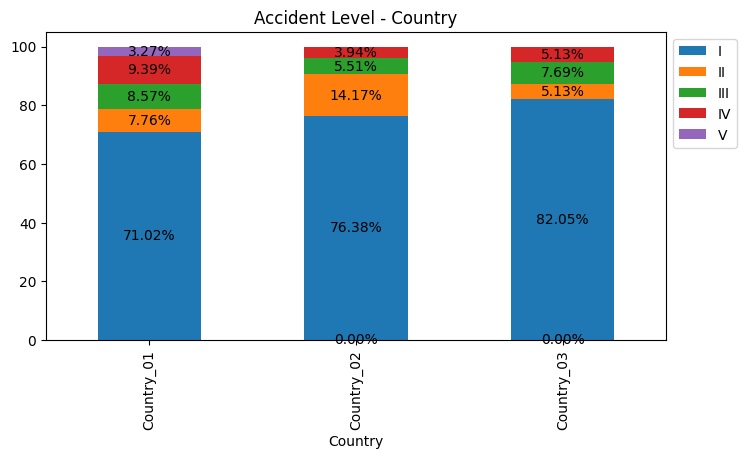

In [42]:
# Stacked bar Countries vs Accident Level by percentages
labelled_stacked_bar(df, 'Country', 'Accident Level')

**Observations**:

* The total number of incidents is highest in `Country_01`.

* `Country_01` has a higher proportion of critical incidents.

* `Country_02` has a higher proportion of minor incidents.

**Labeled Stacked Bar Plot Function for Industry Sector vs Accident Level**

Accident Level     I  II  III  IV  V  All
Industry Sector                          
All              303  39   31  30  8  411
Mining           159  25   20  21  7  232
Metals           107  12    7   7  1  134
Others            37   2    4   2  0   45
------------------------------------------------------------------------------------------------------------------------


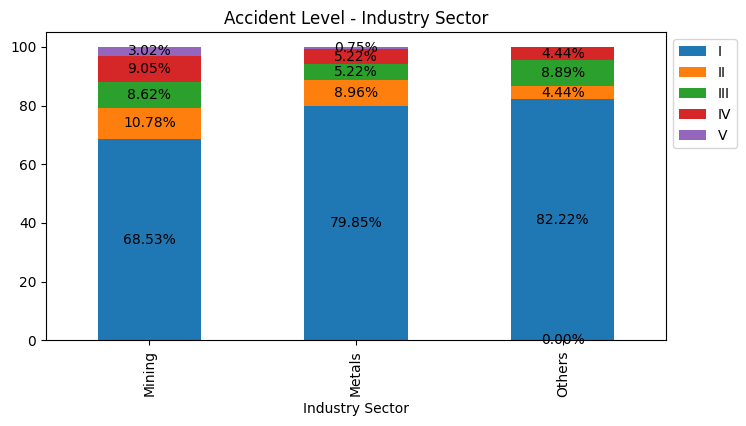

In [43]:
# stacked bar Industry Sector vs Accident Level
labelled_stacked_bar(df, 'Industry Sector', 'Accident Level')

**Observations**:

* The total number of incidents occurred is highest in the `Mining` sector.

* The `Mining` sector has a higher proportion of highly critical incidents.

* The proportion of less critical incidents is higher in the `Others` sector.

**Labeled Stacked Bar Plot Function for Employee Type vs Accident Level**

Accident Level          I  II  III  IV  V  All
Employee type                                 
All                   303  39   31  30  8  411
Third Party           125  19   14  16  6  180
Third Party (Remote)   40   6    3   4  2   55
Employee              138  14   14  10  0  176
------------------------------------------------------------------------------------------------------------------------


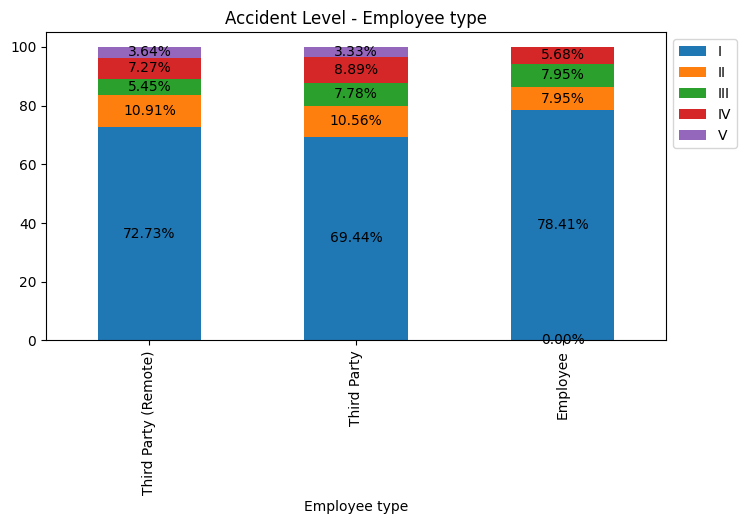

In [44]:
#Employee or Third Party - Accident Level
labelled_stacked_bar(df, 'Employee type', 'Accident Level')

**Observations**:

* The number of incidents is highest among Third Parties, possibly due to limited training and unfamiliarity with the surroundings

* The proportion of critical incidents is higher among `Third Party (Remote)` and `Third Party` groups.

* The proportion of minor incidents is higher among `Employee` group.

**Labeled Stacked Bar Plot Function for Gender vs Potential Accident Level**

Potential Accident Level   I  II  III   IV   V  VI  All
Gender                                                 
Male                      43  81  103  134  28   1  390
All                       43  95  106  138  28   1  411
Female                     0  14    3    4   0   0   21
------------------------------------------------------------------------------------------------------------------------


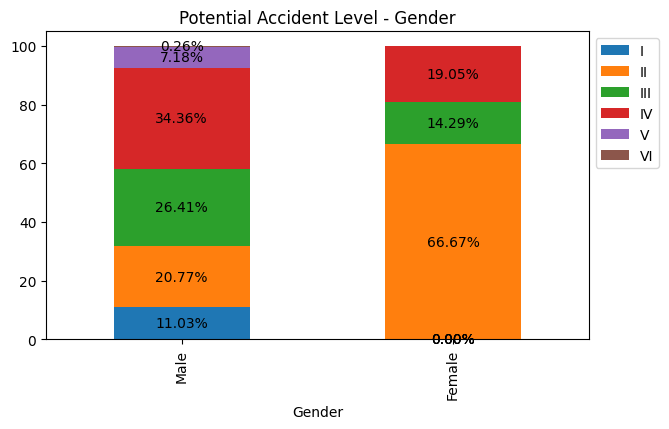

In [45]:
#Employee or Third Party
labelled_stacked_bar(df, 'Gender', 'Potential Accident Level')

**Observations**:

* The proportion of Potential Accident Level II incidents is higher among the `Female` workforce.

* The proportions of Potential Accident Levels III, IV, V, and VI are higher among the `Male` workforce.

**Boxplot for Accident Level with respect to Description Length**

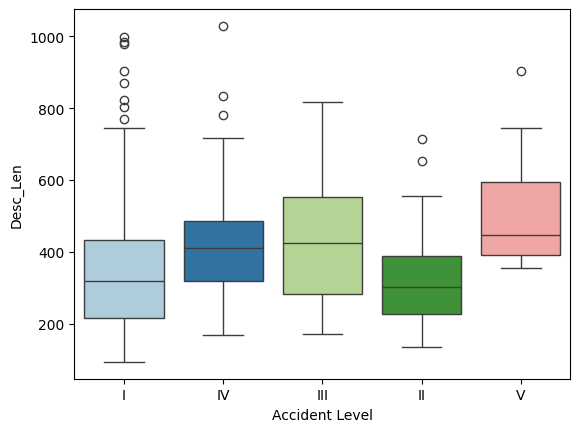

In [46]:
# plot the boxplot for Accident Level with respect to Description Length
sns.boxplot(data=df , x='Accident Level', y='Desc_Len', hue='Accident Level', palette='Paired')
plt.show()

**Observations**:

* Outliers are present in the length of incident descriptions.

* More critical incidents tend to have longer descriptions.

**Line plot by Month - see the trend**

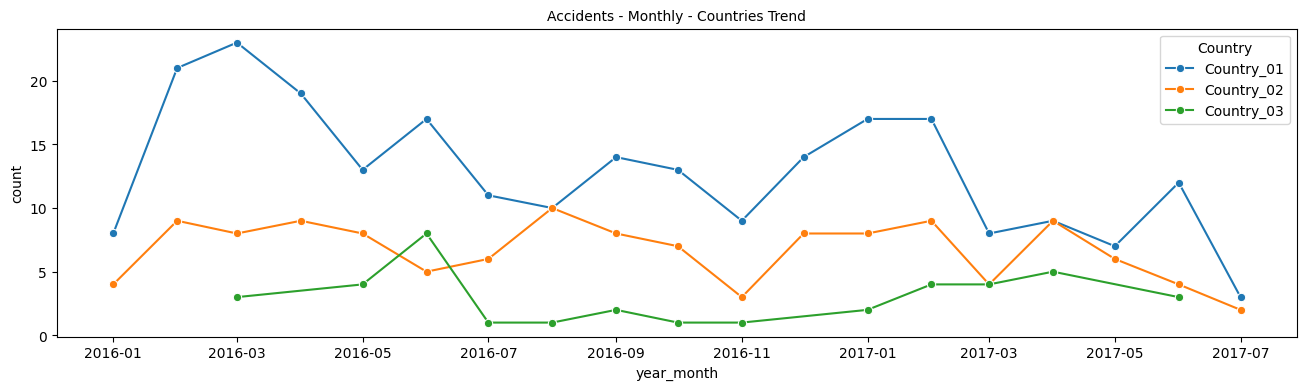

In [47]:
# Line plot by Month - see the trend
monthly_counts = df.groupby(['year_month','Country']).size().reset_index(name='count')
plt.figure(figsize=(16, 4))
plt.title("Accidents - Monthly - Countries Trend", fontsize=10)
sns.lineplot(data=monthly_counts, x='year_month', y='count', hue='Country',marker='o')
plt.show()

**Observations**:

* The number of incidents in `Country_01` remains consistently high throughout the period, which may indicate a higher concentration of industries or lower safety and precautionary standards compared to other countries.

* The number of incidents in `Country_03` tends to remain low most of the time.

* `Country_02` shows a slightly different trend compared to the other two countries.

**Line plot by Month and Accident Level- see the trend**

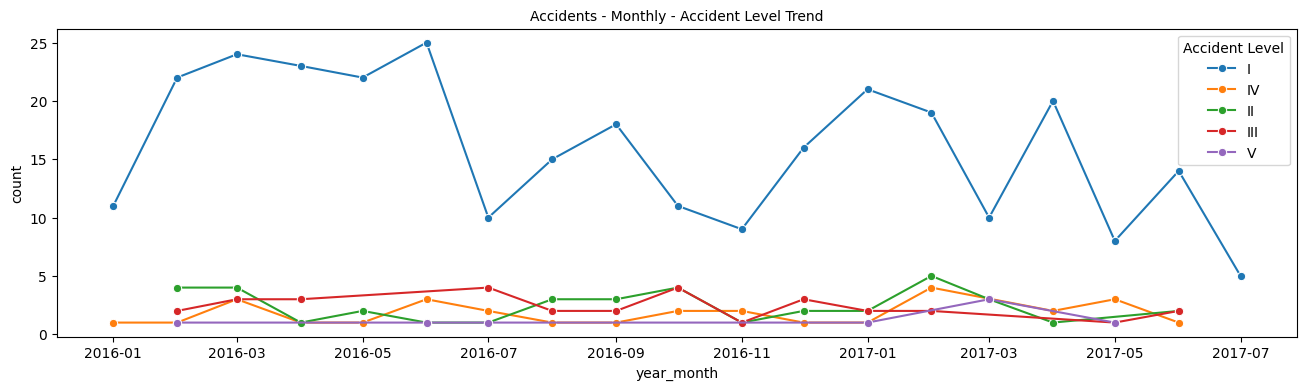

In [48]:
# Line plot by Month and Accident Level- see the trend
monthly_counts = df.groupby(['year_month','Accident Level']).size().reset_index(name='count')
plt.figure(figsize=(16, 4))
plt.title("Accidents - Monthly - Accident Level Trend", fontsize=10)
sns.lineplot(data=monthly_counts, x='year_month', y='count', hue='Accident Level',marker='o')
plt.show()

**Observations**:

* The number of incidents with Accident Level I is consistently high throughout the period, particularly in February, March, April, and June.

* As criticality increases, the number of incidents tends to decrease.

* This indicates that precautionary measures are effectively in place for more critical types of incidents.

**Country-wise industry distribution**

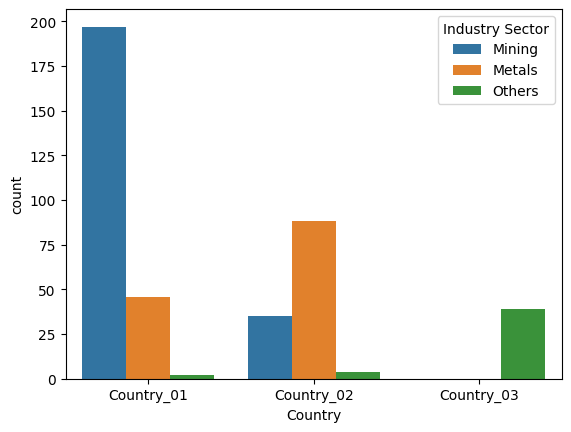

In [49]:
#performing analysis for country-wise industry distribution
sns.countplot (data = df, x="Country",hue ="Industry Sector");

**Observations**

- In Country_03, there is no Mining and Metals sector
- Country_02 have the highest Metals sector
- Country_01 have the highest Mining sector

#### **Now lets find whether the different sectors statistically different across countries**.

- Ho = The proportions of industry sector is not different across countries
- Ha = The proportions of industry sector is different across countries
- Decide the significance level: alpha = 0.05
- Z-test of proportions since we have visibility on the population variance.

In [50]:
# Count the total number of records belonging to Country_01
country_01_cnt = df[df.Country == 'Country_01'].shape[0]

# --- Mining sector ---
# Get the frequency of countries within the Mining industry sector.
# Select the most frequent country (index [0]) and the second most frequent (index [1]).
mining_country1 = df[df['Industry Sector'] == 'Mining']['Country'].value_counts()[0]
mining_country2 = df[df['Industry Sector'] == 'Mining']['Country'].value_counts()[1]

# --- Metals sector ---
# Similar to Mining, but here selecting second most frequent (index [1]) and most frequent (index [0]).
metals_country1 = df[df['Industry Sector'] == 'Metals']['Country'].value_counts()[1]
metals_country2 = df[df['Industry Sector'] == 'Metals']['Country'].value_counts()[0]

# --- Others sector ---
# For "Others", selecting the 3rd, 2nd, and most frequent countries respectively.
others_country1 = df[df['Industry Sector'] == 'Others']['Country'].value_counts()[2]
others_country2 = df[df['Industry Sector'] == 'Others']['Country'].value_counts()[1]
others_country3 = df[df['Industry Sector'] == 'Others']['Country'].value_counts()[0]

# Print out selected top countries for Mining, Metals, and Others,
# along with the count of Country_01 across the dataset
print([mining_country1, metals_country1, others_country1], [country_01_cnt])

[197, 46, 2] [245]


In [51]:
# Perform a two-proportion z-test between Mining and Metals
# Arguments:
#   [mining_country1, metals_country1] → successes (counts of interest for each group)
#   [country_01_cnt]                  → total observations (⚠️ only one total given, likely should be a list of group sizes)
t_statistic, p_value = proportions_ztest([mining_country1, metals_country1], [country_01_cnt])
print("Mining and Metals p_value", p_value)

# Perform a two-proportion z-test between Metals and Others
# Same structure: comparing the proportions of metals_country1 vs. others_country1
t_statistic, p_value = proportions_ztest([metals_country1, others_country1], [country_01_cnt])
print("Metals and Others p_value", p_value)

Mining and Metals p_value 2.2093861161854247e-42
Metals and Others p_value 2.280881768764644e-11


**Observations**

- Hence we reject the null hypothesis, we have enough evidence (95%) to prove that the mining sector in the country 1 is different from metals sector.

- Hence we reject the null hypothsis, we have enough evidence (95%) to prove that the metals sector in country 1 is different from others sector.

**Accident Level wise gender distribution**

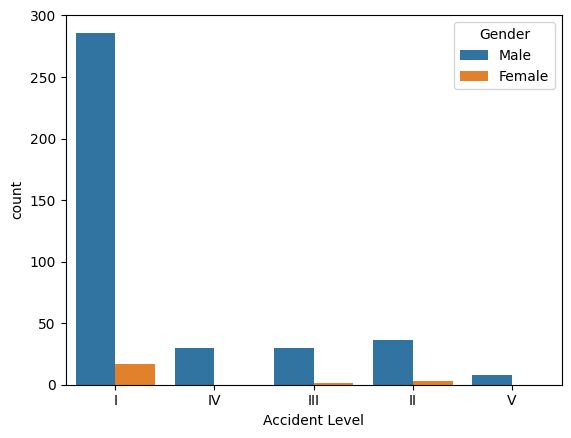

In [52]:
#performing analysis for Accident Level wise gender distribution
sns.countplot (data = df, x="Accident Level",hue ="Gender");

**Observations**
- The Male workforce dominates, possibly due to the nature of the industry sector.

- The proportion of critical incidents is higher among the Male workforce.

####**Now lets find whether the gender distribution differs with respect to Gender or not.**

- Ho = Mean accident severity is the same for males and females.
- Ha = Mean accident severity differs between males and females.
- Decide the significance level: alpha = 0.05
- T-test since we have to compare between means of two groups.

In [53]:
# Map accident severity levels from Roman numerals (I–VI) to numeric values (1–6)
# so that statistical tests can be applied
level_map = {'I':1, 'II':2, 'III':3, 'IV':4, 'V':5, 'VI':6}
df['Accident_Level_Num'] = df['Accident Level'].map(level_map)


In [54]:
# Extract accident severity scores for each gender separately
# For males: filter rows where Gender == 'Male' and select the numeric accident level
male_severity = df[df['Gender'] == 'Male']['Accident_Level_Num']

# For females: filter rows where Gender == 'Female' and select the numeric accident level
female_severity = df[df['Gender'] == 'Female']['Accident_Level_Num']

In [55]:
# Perform an independent samples T-test to compare accident severity between males and females
# equal_var=False → Welch’s t-test (does not assume equal population variances)
male_severityt_stat, p_val = ttest_ind(male_severity, female_severity, equal_var=False)

# Print the p-value to check statistical significance
# Interpretation:
#   If p-value < 0.05 → reject H0 (accident severity differs by gender)
#   If p-value >= 0.05 → fail to reject H0 (no significant difference)
print("P-value Accident Level by Gender - " , p_val)

P-value Accident Level by Gender -  0.01898881687284848


**Observations**
- Hence we fail to reject Null Hypothesis, we have enough (95%) evidence to prove that, Mean accident severity is the same for males and females.

**Pi-charts Accident Levels vs Gender**

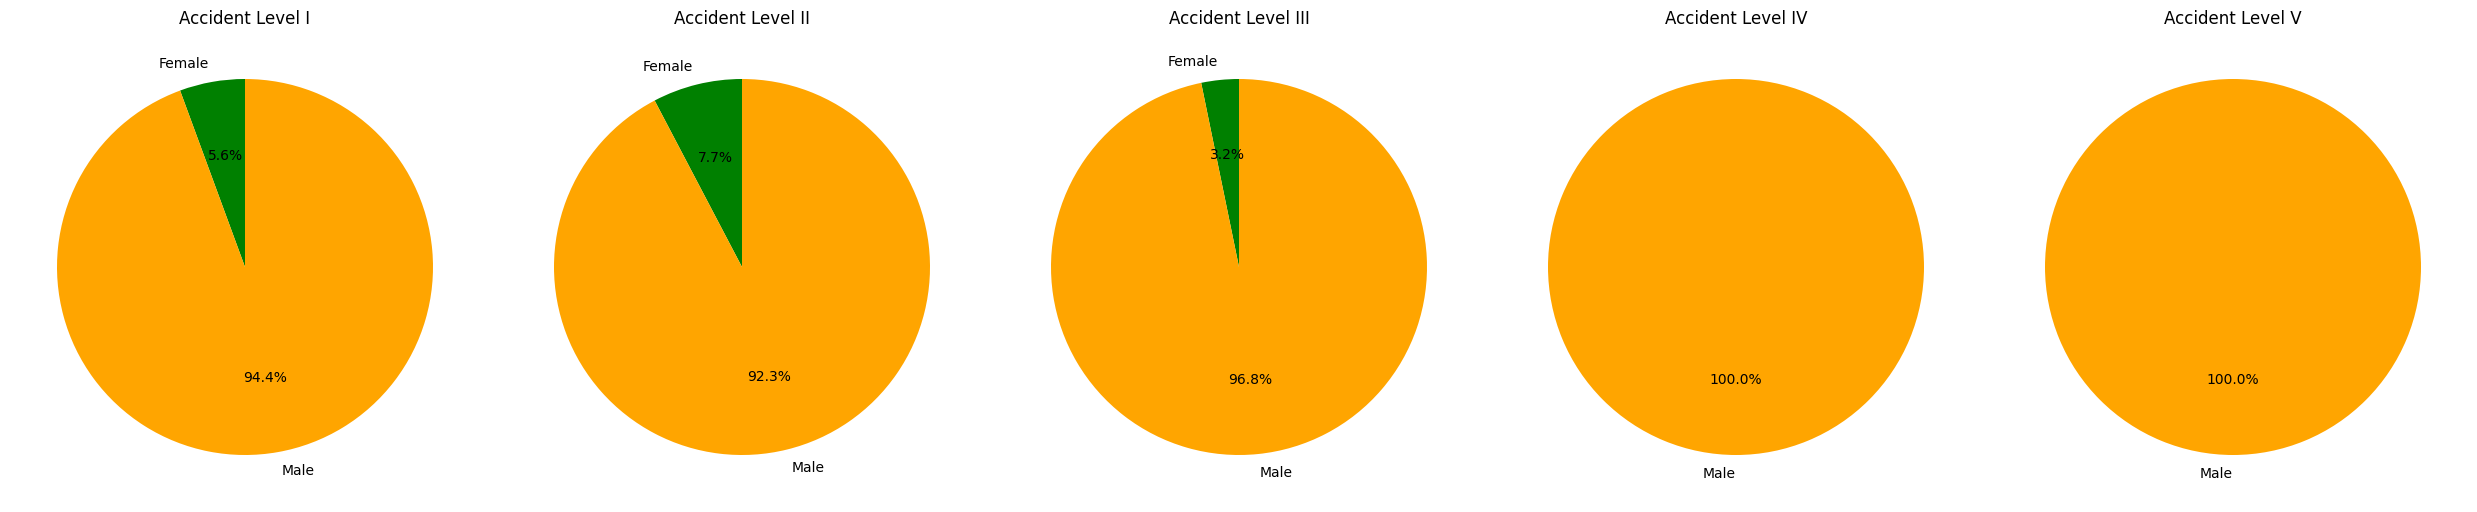

In [56]:
# Group the data by Accident Level and Gender, and count occurrences
accident_gender_counts = df.groupby(["Accident Level", "Gender"]).size().reset_index(name="counts")

# Get unique accident levels to create one pie chart per level
levels = accident_gender_counts["Accident Level"].unique()

# Define colors for each gender (Male → orange, Female → green)
color_map = {"Male": "orange", "Female": "green"}

# Create subplots: one pie chart for each accident level
fig, axes = plt.subplots(1, len(levels), figsize=(5*len(levels), 5))

# Loop through each accident level to generate its pie chart
for i, level in enumerate(levels):
    # Filter the data for the current accident level
    subset = accident_gender_counts[accident_gender_counts["Accident Level"] == level]

    # Assign colors based on gender
    colors = [color_map[g] for g in subset["Gender"]]

    # Plot pie chart showing gender distribution within this accident level
    axes[i].pie(
        subset["counts"],
        labels=subset["Gender"],
        colors=colors,
        autopct='%1.1f%%',  # show percentages with 1 decimal
        startangle=90       # start pie chart at 90 degrees for consistency
    )
    axes[i].set_title(f"Accident Level {level}")

# Adjust layout so subplots don’t overlap
plt.tight_layout()
plt.show()

**Observations**

- In most of the accidents types, more 90% of times male are the victims.
- However for accident type 2 and 1, there is considerable amount of female victims as well.

#### **Now lets find whether the gender and accident type are independent statistically or not.**

- Ho = The gender does not depend on the accident type.
- Ha = The gender depends on the accident type.
- Decide the significance level: alpha = 0.05
- Chi-square test of independence to find whether both the categorical columns are independent or not.

In [57]:
# Create a contingency table (cross-tabulation) of Gender vs. Accident Level
# Rows → Gender, Columns → Accident Levels, Values → counts
contingency_table = pd.crosstab(df["Gender"], df["Accident Level"])

# Perform Chi-Square test of independence
# chi2     → test statistic
# p_value  → probability of observing data if variables are independent
# dof      → degrees of freedom
# expected → expected counts if Gender and Accident Level are independent
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the p-value to evaluate significance
# Interpretation:
#   If p-value < 0.05 → reject H0 (Gender and Accident Level are dependent/associated)
#   If p-value >= 0.05 → fail to reject H0 (no significant association)
print("Gender and Accident type p-value -", p_value)

Gender and Accident type p-value - 0.5634416001539846


**Observations**

- Hence we fail to reject the null hypothesis, we have enough evidence (95%) to prove that accident type and gender do not depend on each other.

### Multi-variate analysis

####**Extract the year, month and day from 'Date' column**

In [58]:
# create new features on date
df['Year'] = df['Date'].dt.year
df["Month"] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Is_Weekend'] = df['Date'].dt.dayofweek >= 5

**Accident Severity across different months and years**

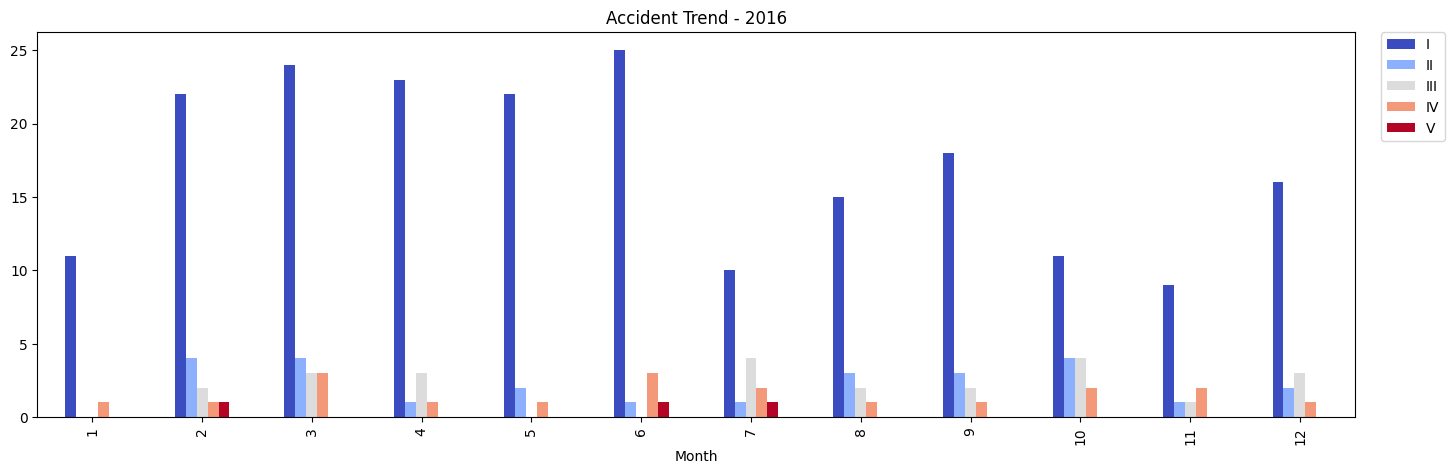

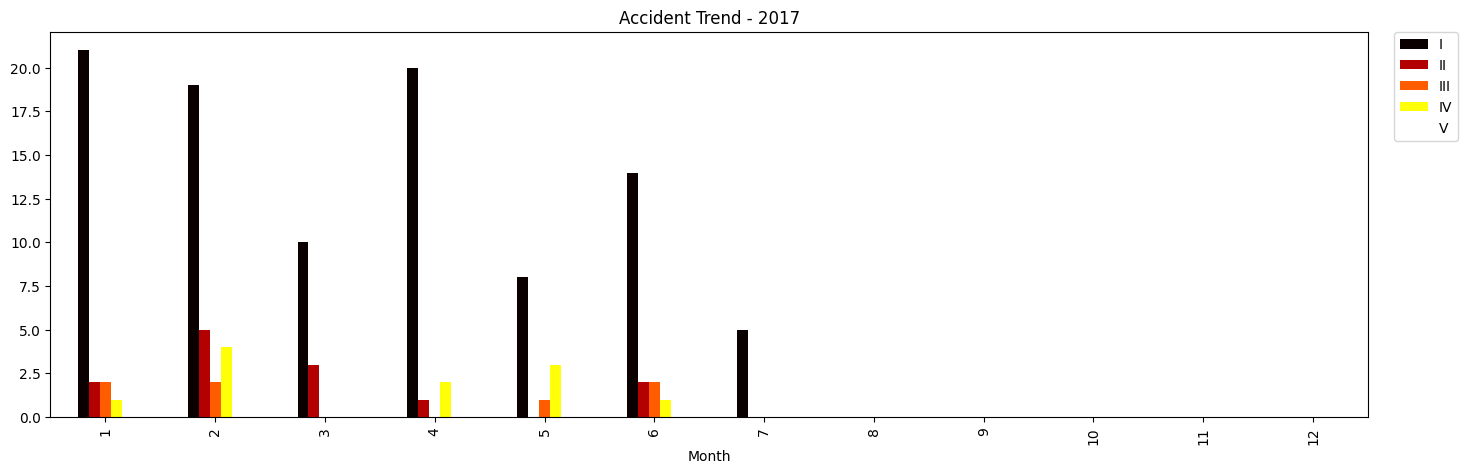

In [59]:
df_trend=df.pivot_table(index='Month', columns=[ 'Year','Accident Level'], aggfunc='count')['Country']
df_trend.replace(np.nan,0,inplace=True)
month_order=[1,2,3,4,5,6,7,8,9,10,11,12]

# Plot accident trends for 2016
ax1 = df_trend[2016].loc[month_order].plot(kind='bar',figsize=(17,5),cmap='coolwarm',title='Accident Trend - 2016')
ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Plot accident trends for 2017
ax2 = df_trend[2017].loc[month_order].plot(kind='bar',figsize=(17,5),cmap='hot',title='Accident Trend - 2017')
ax2.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0);


**Observations**

- Accidents were majorly been of type-1 in 2016 and 2017 for the first 6 months.
- Accidents of type-1 reduced in 2016 and was none in 2017 in the second 6 months which can be followed to cover the accidents of this type-1 throughout.
- Accidents of other types has mostly been in the first 3-4 months of 2017.
- For the last 6 months of 2017 activity is not captured.

**Segmentation map for Accident Level by Industry & Gender**

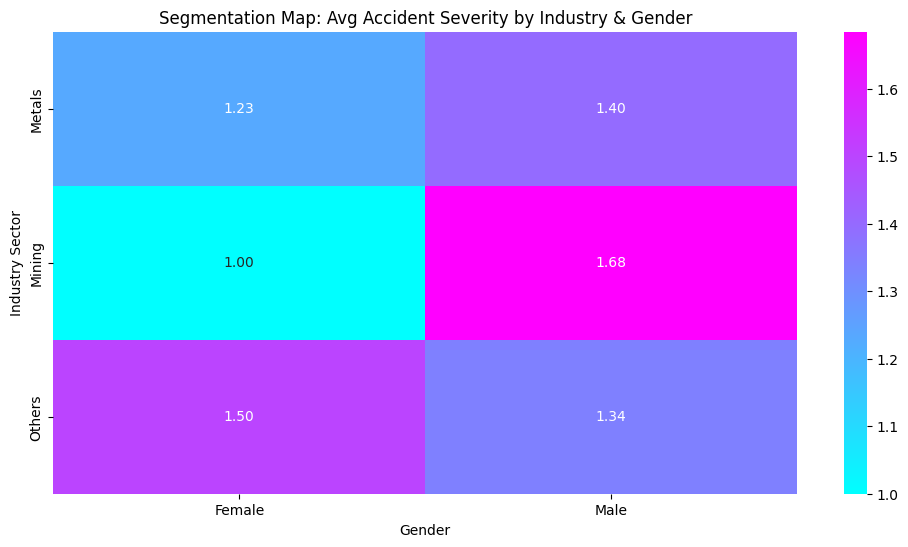

In [60]:
segmentation_map = df.groupby(
    ['Industry Sector', 'Gender', 'Employee type', 'Country']
).agg(
    avg_accident_level = ('Accident_Level_Num', 'mean'),
    total_accidents = ('Accident_Level_Num', 'count')
).reset_index()


plt.figure(figsize=(12,6))
pivot_table = df.pivot_table(
    values='Accident_Level_Num',
    index='Industry Sector',
    columns='Gender',
    aggfunc='mean'
)
sns.heatmap(pivot_table, annot=True, cmap="cool", fmt=".2f")
plt.title("Segmentation Map: Avg Accident Severity by Industry & Gender")
plt.show()

**Observations**

- Male have the most accidents in the Mining sector and females have it in the other sector.
- Mostly people working in the Mining sector are male while others have nearly equal proportion of Male and Female.

**Accidents across industry in various months**

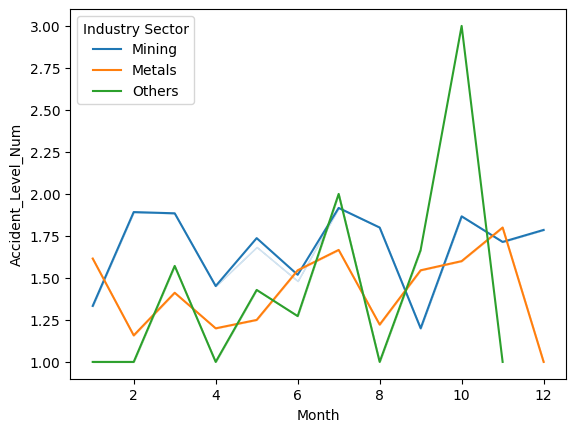

In [61]:
sns.lineplot(data=df,x='Month',y='Accident_Level_Num',hue='Industry Sector',ci=False);

**Observations**

- Most accidents have been in the 10th Month for others industry which needs further evaluation.
- Least accidents have happened in metals sector for first few months and then spiked up.
- For mining sector, it come down suddenly in the 9th month maybe due to some holiday season.

##### **Adding New Columns**

###### Season

In [62]:
#adding of seasons column
def month2seasons(x):
    if x in [9, 10, 11]:
        season = 'Spring'
    elif x in [12, 1, 2]:
        season = 'Summer'
    elif x in [3, 4, 5]:
        season = 'Autumn'
    elif x in [6, 7, 8]:
        season = 'Winter'
    return season

df['Season'] = df['Month'].apply(month2seasons)

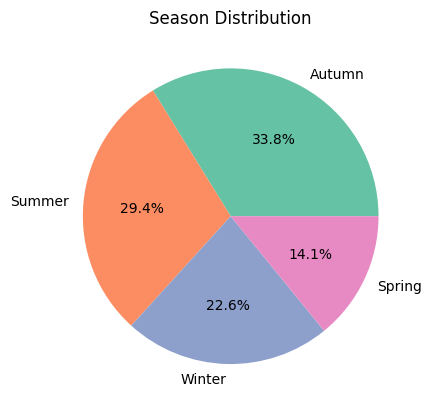

In [63]:
season_counts = df['Season'].value_counts()
plt.pie(season_counts, labels=season_counts.index, autopct='%1.1f%%',colors=sns.color_palette("Set2"))
plt.title("Season Distribution")
plt.show()

**Observations**:

* Autumn season has the most number of accidents
* Spring has the least number of accidents suggesting that more precautions are taken or the season is most suitable for carrying out works.
* Winter is the season of holidays hence the less number of accidents.

In [64]:
df['Season']

0      Summer
1      Summer
2      Summer
3      Summer
4      Summer
        ...  
406    Winter
407    Winter
408    Winter
409    Winter
410    Winter
Name: Season, Length: 411, dtype: object

Accident Level    I  II  III  IV  V  All
Season                                  
All             303  39   31  30  8  411
Autumn          107  11    7  10  4  139
Summer           89  13    9   8  2  121
Winter           69   7    8   7  2   93
Spring           38   8    7   5  0   58
------------------------------------------------------------------------------------------------------------------------


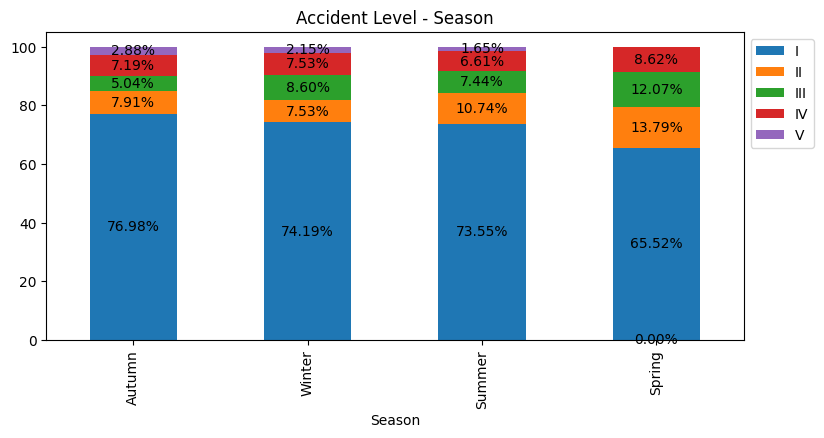

In [65]:
# Stacked bar Seasons vs Accident Level by percentages
labelled_stacked_bar(df, 'Season', 'Accident Level')

**Observations**:
* Autumn records the highest number of accidents (139 cases), making it the most accident-prone season.

* Summer (121) and Winter (93) follow, while Spring (58) has the fewest accidents, indicating safer conditions overall.

* Severe accidents (Levels IV & V) are relatively rare, but Autumn still shows slightly more of them, suggesting higher risk intensity in that season.

* Seasonal factors like weather variability and travel volume could be influencing these patterns

###### Bank Holiday flag

In [66]:
import holidays
br_holidays = holidays.Brazil()

df['HolidayName'] = df['Date'].apply(lambda dt: br_holidays.get(dt))
df['Is_Holiday'] = df['HolidayName'].notna()

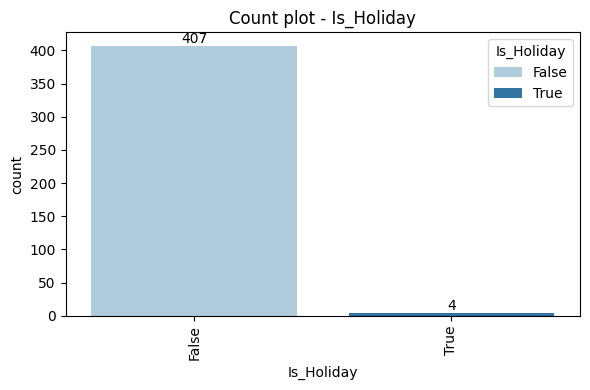

In [67]:
# count plot for Holidays
labelled_barplot(df,['Is_Holiday'],cols=1, figsize=(6,4))

Accident Level    I  II  III  IV  V  All
Is_Holiday                              
False           299  39   31  30  8  407
All             303  39   31  30  8  411
True              4   0    0   0  0    4
------------------------------------------------------------------------------------------------------------------------


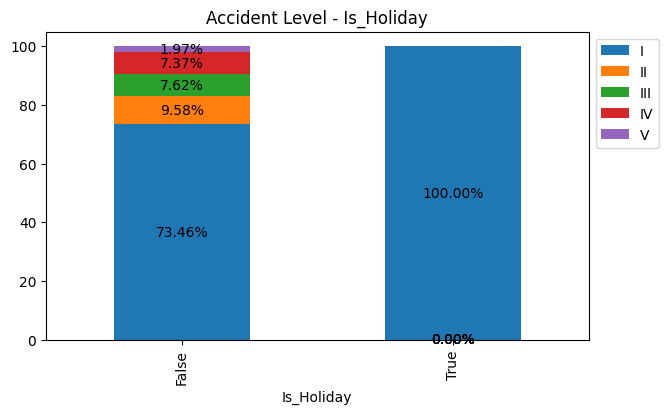

In [68]:
# Stacked bar Is_Holiday vs Accident Level by percentages
labelled_stacked_bar(df, 'Is_Holiday', 'Accident Level')

**Observations**:

* There are certain accidents on bank holidays as well, which does not make sense as no worker is working on bank holidays.
* However, they might be asked to overwork on bank holidays could be one of the possible problems leading to accidents.

* The vast majority of accidents (407 out of 411, ~99%) occur on non-holiday (working) days, showing a strong link between regular traffic activity and accident frequency.

* Only 4 minor accidents (Level I) happened on bank holidays, with no severe cases (Levels II–V) — indicating significantly lower risk during holidays.

#### **EDA Insights**

* The total number of incidents occurred is highest in the **Mining** sector.
* The number of incidents is highest among **Third Parties**, possibly due to limited training and unfamiliarity with the surroundings.
* The **Male** workforce dominates, possibly due to the nature of the industry sector.
* More critical incidents tend to have **longer descriptions**.
* The number of incidents in **Country_01** remains consistently high throughout the period, which may indicate a higher concentration of industries or lower safety and precautionary standards compared to other countries.
* The number of incidents in **Country_03** tends to remain low most of the time.
* The number of incidents with **Accident Level I** is consistently high throughout the period, particularly in **February, March, April, and June**.

* **Autumn** season records the highest number of accidents, making it the most accident-prone season.

* Reduced traffic volume and low work-related travel on holidays lead to fewer accidents.

* As criticality increases, the number of incidents tends to decrease, indicating that **precautionary measures** are effectively in place for more critical types of incidents.
* The **word cloud** highlights frequent accident-related terms like **employee, causing, operator, worker, and moment**, reflecting common accident contexts.
* The **top 20 words** are dominated by generic English stopwords (**the, of, to, and, a**), but domain-specific words like **causing, employee, right, left, hit** also appear.
* **Bigram analysis** shows frequent contextual pairs like **of the, in the, on the**, but also domain-specific pairs like **the operator, causing the, at the time**.
* Accident descriptions are **action-oriented** (e.g., hit, causing, injury) and revolve around **workers and equipment interaction**.
* Removing common **stopwords** could reveal more **domain-specific accident terms** in the word frequency analysis.


## **Data Preprocessing**

### Feature Engineering

* The derived feature `year_month` is not included in the input features.

* The `Potential Accident Level`, which depends on the target variable Accident Level, is also excluded from the input features.

* The feature `Season` is added to capture seasonality

* `Year`, `Month`, `Day`, `Is_Weekend`, `Is_Holiday` features are added for considering the time impact on the Accidents

In [69]:
# drop year_month, HolidayName created in EDA
df.drop(['year_month','HolidayName'], axis=1, inplace=True)

# drop Potential Accident Level
df.drop('Potential Accident Level', axis=1, inplace=True)

# drop date feature
df.drop('Date', axis=1, inplace=True)

####Lets check updated data

In [70]:
df.head()

Country     Local Industry Sector Accident Level Gender  \
0  Country_01  Local_01          Mining              I   Male   
1  Country_02  Local_02          Mining              I   Male   
2  Country_01  Local_03          Mining              I   Male   
3  Country_01  Local_04          Mining              I   Male   
4  Country_01  Local_04          Mining             IV   Male   

          Employee type        Critical Risk  \
0           Third Party              Pressed   
1              Employee  Pressurized Systems   
2  Third Party (Remote)         Manual Tools   
3           Third Party               Others   
4           Third Party               Others   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Description  \
0                                                                                                           While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.   
1                                                                                                                                                                                                                                                                 During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter.   
2                                                                                                                                                                                                                                                          In the sub-station MILPO located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of ​​the left foot of the collaborator causing the injury.   
3  Being 9:45 am. approximately in the Nv. 1880 CX-695 OB7, the personnel begins the task of unlocking the Soquet bolts of the BHB machine, when they were in the penultimate bolt they identified that the hexagonal head was worn, proceeding Mr. Cristóbal - Auxiliary assistant to climb to the platform to exert pressure with your hand on the "DADO" key, to prevent it from coming out of the bolt; in those moments two collaborators rotate with the lever in anti-clockwise direction, leaving the key of the bolt, hitting the palm of the left hand, causing the injury.   
4                                                                             Approximately at 11:45 a.m. in circumstances that the mechanics Anthony (group leader), Eduardo and Eric Fernández-injured-the three of the Company IMPROMEC, performed the removal of the pulley of the motor of the pump 3015 in the ZAF of Marcy. 27 cm / Length: 33 cm / Weight: 70 kg), as it was locked proceed to heating the pulley to loosen it, it comes out and falls from a distance of 1.06 meters hig

**Observations**

* The redundant features **year_month** and **Potential Accident Level** were dropped to simplify the dataset.
* The **Date** column was decomposed into granular features: **Year, Month, and Day**.
* A new feature **Season** is added to capture the Seasonality
* New boolean features **Is_Weekend**, **Is_Holiday** were created to capture whether an accident occurred on a weekend or Holiday
* The original **Date** column was dropped after extracting temporal features to avoid redundancy.
* The dataset now includes a derived feature **Desc_Len** representing the description length, useful for text-based analysis.

### Train Test split

Incidents in industry sectors are seasonal and influenced by weather conditions. Therefore, the dataset is split sequentially rather than using a random train-test split.

First 290 rows as train data set and remaining are split between validation and test datasets.

In [71]:
df.head(1)

Country     Local Industry Sector Accident Level Gender Employee type  \
0  Country_01  Local_01          Mining              I   Male   Third Party   

  Critical Risk  \
0       Pressed   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Description  \
0  While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.   

   Desc_Len  Accident_Level_Num  Year  Month  Day  Is_Weekend  Season  \
0       457                   1  2016      1    1       False  Summer   

   Is_Holiday  
0        True

####Split dataset between **input** and **Target** features

In [72]:
# prepare the input and target features
# Input features
#X = df[['Data', 'Local','Industry Sector','Genre','Employee or Third Party','Critical Risk', 'Description']]
X = df.drop('Accident Level', axis=1)
# target feature
y = df[['Accident Level']]

In [73]:
# print input features
X.head(2)

Country     Local Industry Sector Gender Employee type  \
0  Country_01  Local_01          Mining   Male   Third Party   
1  Country_02  Local_02          Mining   Male      Employee   

         Critical Risk  \
0              Pressed   
1  Pressurized Systems   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Description  \
0  While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.   
1                                                                                                                                                        During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter.   

   Desc_Len  Accident_Level_Num  Year  Month  Day  Is_Weekend  Season  \
0       457                   1  2016      1    1       False  Summer   
1       307                   1  2016      1    2        True  Summer   

   Is_Holiday  
0        True  
1       False

**Observations**

* The target variable is **Accident Level**, while all other fields serve as **input features**.
* Input features include both **categorical** (Country, Local, Industry Sector, Gender, Employee type, Critical Risk) and **textual** (Description) data.
* Engineered features like **Desc_Len, Year, Month, Day, Is_Weekend, Is_Holiday, Season** enhance the dataset for temporal and text-length based analysis.
* This setup enables models to learn from **industrial context + accident narrative** while respecting the temporal order of incidents.

In [74]:
# print target feature
y.head(2)

Accident Level
0              I
1              I

**Observations**

* The target feature is **Accident Level**, representing the severity of each incident.
* It is recorded using **Roman numerals (I–VI)**, where **I** indicates minor and **VI** indicates very severe accidents.
* The sample rows show both incidents labeled as **Level I**, reflecting low-severity cases.
* This categorical target will require **encoding** before being used in machine learning models.

####Train-Test split of **input** and **Target** features

In [75]:
if split_sequential:
  # Dataset is split sequentially (based on index order) into train, validation, and test sets.
  # This is done because incidents in dataset are time-based, rather than random splitting.
  # Stratification is not used here since the split is intentional/sequential,
  # not aiming to preserve class distribution across subsets.

  X_train = X.iloc[0:290]
  y_train = y.iloc[0:290]

  X_val = X.iloc[290:350]
  y_val = y.iloc[290:350]

  X_test = X.iloc[350:]
  y_test = y.iloc[350:]

else:
  # split randomly using stratify
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

In [76]:
# print the shape for splits
print(f"Shape of Train data : {X_train.shape} , {y_train.shape}")
print(f"Shape of Val data : {X_val.shape} , {y_val.shape}")
print(f"Shape of Test data : {X_test.shape} , {y_test.shape}")

Shape of Train data : (287, 15) , (287, 1)
Shape of Val data : (62, 15) , (62, 1)
Shape of Test data : (62, 15) , (62, 1)


**Observations**

* Potential seasonality in accident data is captured in **Season** feature.

* The dataset was split randomly using stratify into **Train (287)**, **Validation (62)**, and **Test (62)** records.

* Each split maintains **14 input features** and **1 target feature (Accident Level)**.

* The split ratio roughly follows a **70% train, 15% validation, 15% test** distribution.
* This setup allows for robust **model training, hyperparameter tuning, and final evaluation**.

In [77]:
# print the percentages of value counts in target variable
print(f"Train value counts : \n {y_train.value_counts(normalize=True)}")

Train value counts : 
 Accident Level
I                 0.735192
II                0.094077
III               0.076655
IV                0.073171
V                 0.020906
Name: proportion, dtype: float64


**Observation**

* The dataset is imbalanced, with `Accident Level I` being the dominant class.

### NLP Preprocessing

#### Remove Special Characters

In [78]:
# defining a function to remove special characters
def remove_special_characters(text):
    # Defining the regex pattern to match non-alphanumeric characters
    pattern = '[^A-Za-z0-9]+'

    # Finding the specified pattern and replacing non-alphanumeric characters with a blank string
    new_text = ''.join(re.sub(pattern, ' ', text))

    return new_text

In [79]:
# test the function to remove the special characters
remove_special_characters("Time and Tide waits for none...!")

'Time and Tide waits for none '

In [80]:
# Applying the function to remove special characters
X_train['cleaned_description'] = X_train['Description'].apply(remove_special_characters)
X_val['cleaned_description'] = X_val['Description'].apply(remove_special_characters)
X_test['cleaned_description'] = X_test['Description'].apply(remove_special_characters)

In [81]:
X_train[['Description','cleaned_description']].sample(2)

Description  \
14   Due to the accumulation of Waelz on the conveyor and trailer of the Filter 08FI0502, the employee performed the cleaning of the shutter using the air lance, when he was surprised by the fall of the product that was above the door, passing between the neck and the collar of the aramid jacket and causing burn in the neck and shoulder.   
323                                                                 the moment of extracting the bolts of the CHUCK of rotation unit VSD 01; in the instant that is made hits with the rope of 6Lbs. the base of the support bolts, a fragment of the metal structure is projected, impacting the face of the mechanic Freddy the described injury.   

                                                                                                                                                                                                                                                                                                                             cleaned_description  
14   Due to the accumulation of Waelz on the conveyor and trailer of the Filter 08FI0502 the employee performed the cleaning of the shutter using the air lance when he was surprised by the fall of the product that was above the door passing between the neck and the collar of the aramid jacket and causing burn in the neck and shoulder   
323                                                                  the moment of extracting the bolts of the CHUCK of rotation unit VSD 01 in the instant that is made hits with the rope of 6Lbs the base of the support bolts a fragment of the metal structure is projected impacting the face of the mechanic Freddy the described injury

**Observations**:

The punctuation, parenthesis and other special characters are removed in the cleaned text of incident description.

#### Lowercasing

In [82]:
# changing the case of the text data to lower case
X_train['cleaned_description'] = X_train['cleaned_description'].str.lower()
X_val['cleaned_description'] = X_val['cleaned_description'].str.lower()
X_test['cleaned_description'] = X_test['cleaned_description'].str.lower()

In [83]:
X_train[['Description','cleaned_description']].head(2)

Description  \
34                                                                                              The employee was clearing the pipe when he tapped his right thumb against the flange causing little trauma.   
264  Employee reports that he performed an activity in the area of ​​the Ustulación, under the coordination of Maintenance when he was hit by dust from the ustulado, causing irritation in the eye region.   

                                                                                                                                                                                    cleaned_description  
34                                                                                          the employee was clearing the pipe when he tapped his right thumb against the flange causing little trauma   
264  employee reports that he performed an activity in the area of the ustulaci n under the coordination of maintenance when he was hit by dust from the ustulado causing irritation in the eye region

**Observations**:

The uppercase is changed to lowercase in the cleaned text of incidents.

#### Remove white space

In [84]:
# removing extra whitespaces from the text
X_train['cleaned_description'] = X_train['cleaned_description'].str.strip()
X_val['cleaned_description'] = X_val['cleaned_description'].str.strip()
X_test['cleaned_description'] = X_test['cleaned_description'].str.strip()

In [85]:
X_train[['Description','cleaned_description']].head(2)

Description  \
34                                                                                              The employee was clearing the pipe when he tapped his right thumb against the flange causing little trauma.   
264  Employee reports that he performed an activity in the area of ​​the Ustulación, under the coordination of Maintenance when he was hit by dust from the ustulado, causing irritation in the eye region.   

                                                                                                                                                                                   cleaned_description  
34                                                                                          the employee was clearing the pipe when he tapped his right thumb against the flange causing little trauma  
264  employee reports that he performed an activity in the area of the ustulaci n under the coordination of maintenance when he was hit by dust from the ustulado causing irritation in the eye region

**Observation**

Any extra white space is stripped in the incidents.

#### Remove stop words

* The idea with stop word removal is to **exclude words that appear frequently throughout** all the documents in the corpus.
* Pronouns and articles are typically categorized as stop words.


The NLTK library has an in-built list of stop words and it can utilize that list to remove the stop words from a dataset.

In [86]:
# defining a function to remove stop words using the NLTK library
def remove_stopwords(text):
    # Split text into separate words
    words = text.split()

    # Removing English language stopwords
    new_text = ' '.join([word for word in words if word not in stopwords.words('english')])

    return new_text

In [87]:
# Applying the function to remove stop words using the NLTK library
X_train['cleaned_description'] = X_train['cleaned_description'].apply(remove_stopwords)
X_val['cleaned_description'] = X_val['cleaned_description'].apply(remove_stopwords)
X_test['cleaned_description'] = X_test['cleaned_description'].apply(remove_stopwords)

In [88]:
X_train[['Description','cleaned_description']].head(2)

Description  \
34                                                                                              The employee was clearing the pipe when he tapped his right thumb against the flange causing little trauma.   
264  Employee reports that he performed an activity in the area of ​​the Ustulación, under the coordination of Maintenance when he was hit by dust from the ustulado, causing irritation in the eye region.   

                                                                                                              cleaned_description  
34                                                         employee clearing pipe tapped right thumb flange causing little trauma  
264  employee reports performed activity area ustulaci n coordination maintenance hit dust ustulado causing irritation eye region

**Observation**
* The common stop words like articles, prepositions, pronouns etc are removed.

#### Stemming

Stemming is the process of reducing words to their root/base form by chopping off prefixes or suffixes.

Examples:

running → run

customer → custom

studies - studi

It could result some non-dictionary words.

In [89]:
# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

In [90]:
# defining a function to perform stemming
def apply_lemmatizer_stemmer(text):
    # Split text into separate words
    words = text.split()

    # Applying the lemmatizer Stemmer on every word of a message and joining the stemmed words back into a single string
    new_text = ' '.join([lemmatizer.lemmatize(word) for word in words])

    return new_text

In [91]:
# Applying the function to perform stemming
X_train['cleaned_description'] = X_train['cleaned_description'].apply(apply_lemmatizer_stemmer)
X_val['cleaned_description'] = X_val['cleaned_description'].apply(apply_lemmatizer_stemmer)
X_test['cleaned_description'] = X_test['cleaned_description'].apply(apply_lemmatizer_stemmer)

In [92]:
X_train[['Description','cleaned_description']].head(2)

Description  \
34                                                                                              The employee was clearing the pipe when he tapped his right thumb against the flange causing little trauma.   
264  Employee reports that he performed an activity in the area of ​​the Ustulación, under the coordination of Maintenance when he was hit by dust from the ustulado, causing irritation in the eye region.   

                                                                                                             cleaned_description  
34                                                        employee clearing pipe tapped right thumb flange causing little trauma  
264  employee report performed activity area ustulaci n coordination maintenance hit dust ustulado causing irritation eye region

**Observations**:

The words are converted to base words. For instance

support**s** -> support

finger**s** -> finger

###**Analysis of incidents Cleaned Description after NLP pre-processing**

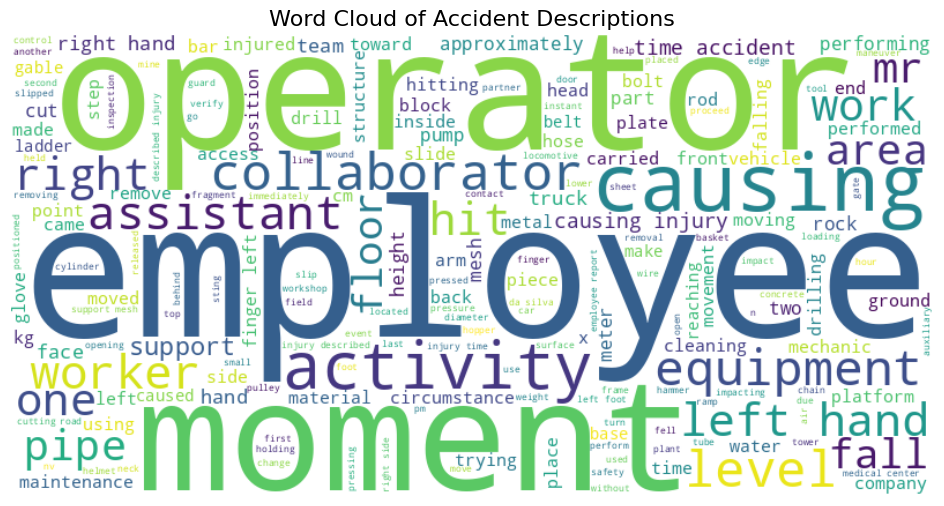

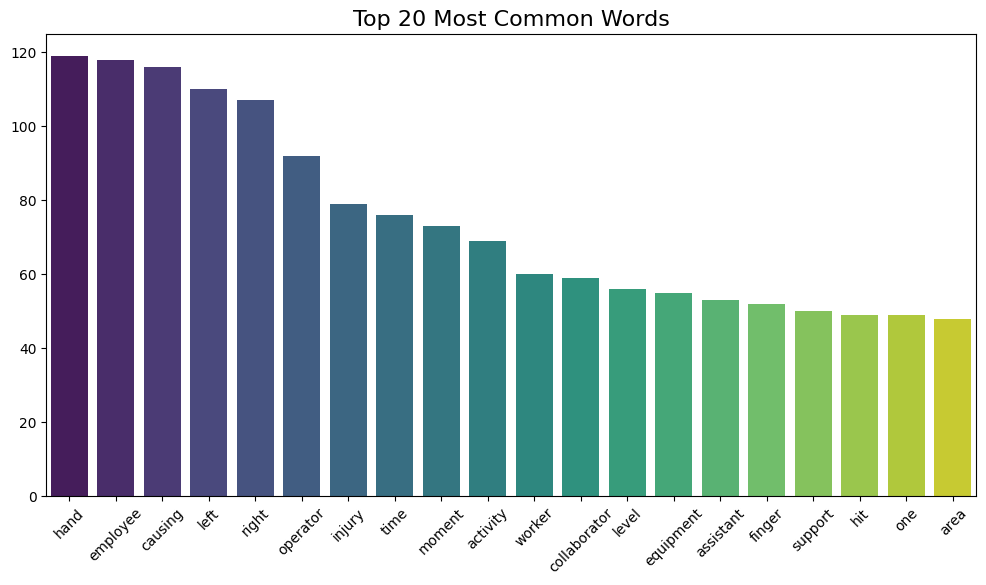

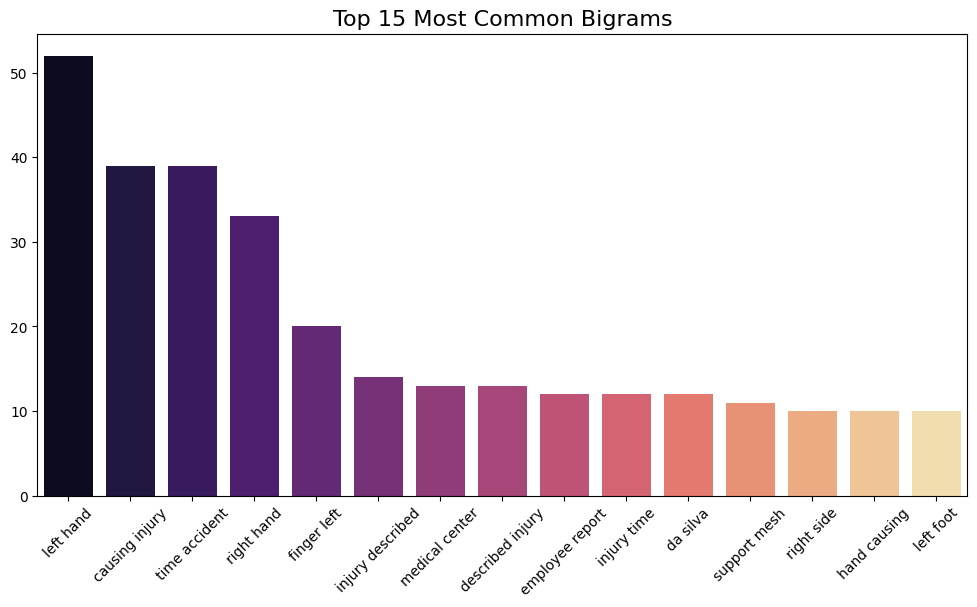

In [93]:
# ================================
# EDA Visualization
# ================================

from collections import Counter
from wordcloud import WordCloud

# 1. Word Cloud for accident descriptions
all_text = " ".join(X_train['cleaned_description'])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Accident Descriptions", fontsize=16)
plt.show()

# 2. Top 20 most common words (bar chart)
word_freq = Counter(all_text.split())
common_words = word_freq.most_common(20)

plt.figure(figsize=(12,6))
sns.barplot(x=[w for w, _ in common_words], y=[c for _, c in common_words], palette="viridis")
plt.title("Top 20 Most Common Words", fontsize=16)
plt.xticks(rotation=45)
plt.show()

# 3. Bigram (two-word phrases) analysis
from nltk import ngrams

bigrams = ngrams(all_text.split(), 2)
bigram_freq = Counter(bigrams).most_common(15)

plt.figure(figsize=(12,6))
sns.barplot(x=[" ".join(bg) for bg, _ in bigram_freq], y=[c for _, c in bigram_freq], palette="magma")
plt.title("Top 15 Most Common Bigrams", fontsize=16)
plt.xticks(rotation=45)
plt.show()


**Observations**

* The word cloud highlights frequent accident-related terms like **employee, operator, assistant, worker, moment, causing, hand**, reflecting key entities and actions.
* The top 20 most common words include domain-specific terms such as **hand, causing, right, employee, left, operator, injury, accident**, showing strong relevance to workplace hazards.
* Bigram analysis reveals recurring patterns like **left hand, time accident, causing injury, right hand, employee report**, which emphasize accident body parts and event timing.
* Multiple bigrams (**injury described, injured person, safety glove, medical center**) suggest frequent reporting of injury details and safety measures.
* Overall, cleaned descriptions emphasize **injury context, body parts, and operational roles**, making them highly useful for **accident classification and risk prediction**.


=== Accident Level: I (Bigrams) ===


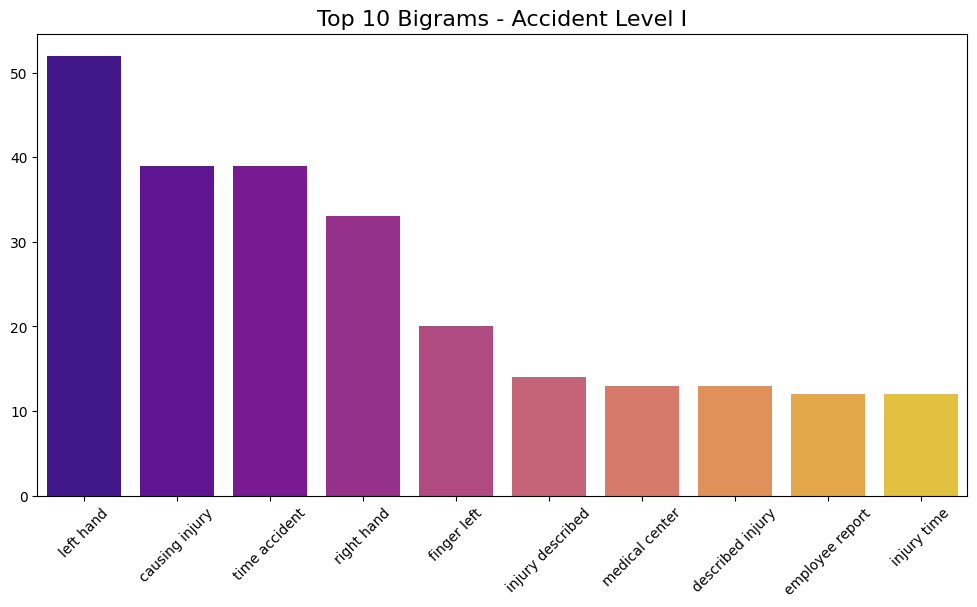


=== Accident Level: II (Bigrams) ===


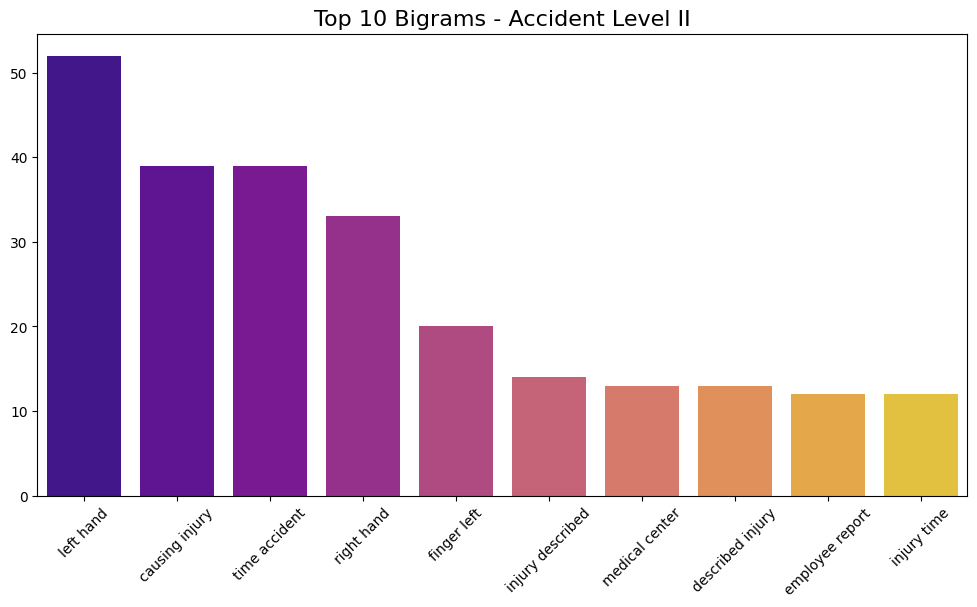


=== Accident Level: III (Bigrams) ===


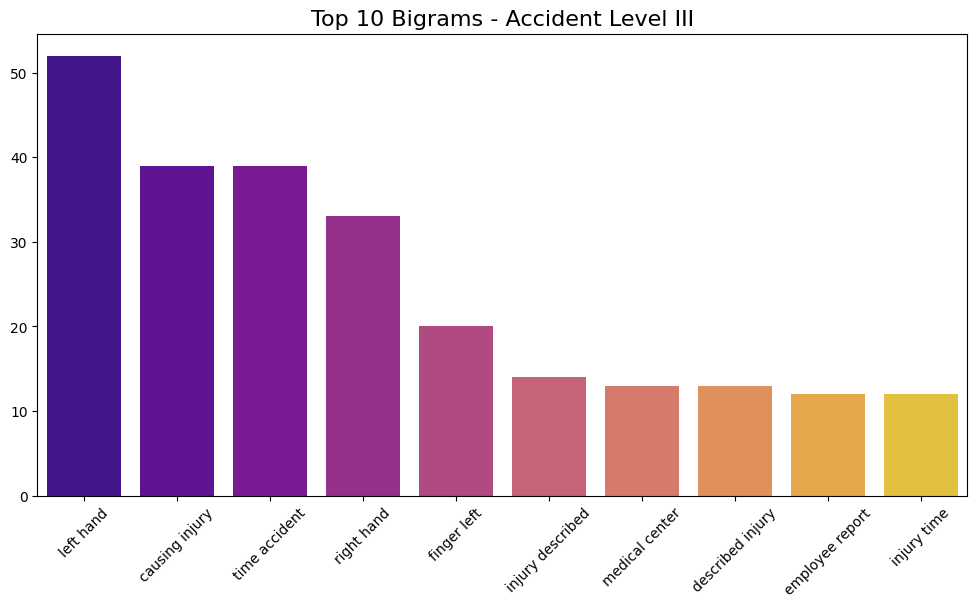


=== Accident Level: IV (Bigrams) ===


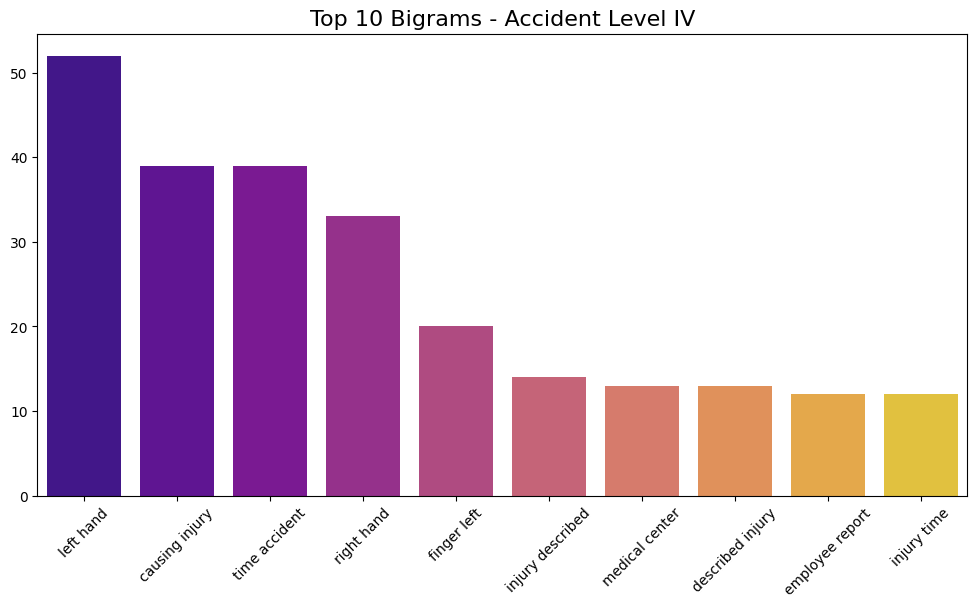


=== Accident Level: V (Bigrams) ===


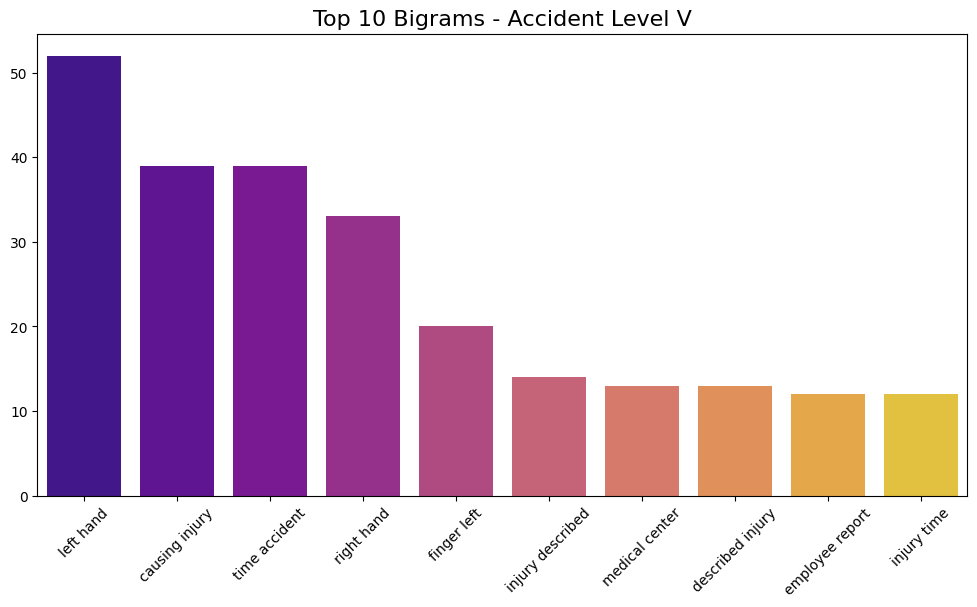

In [94]:
# ================================
# Bigram Analysis by Accident Level
# ================================

from nltk import ngrams

train_df = pd.concat([X_train, y_train], axis=1)

for lvl in sorted(df['Accident Level'].unique()):
    subset = df[df['Accident Level'] == lvl]
    text = " ".join(train_df['cleaned_description'])

    print(f"\n=== Accident Level: {lvl} (Bigrams) ===")

    if len(text.strip()) > 0:
        bigrams = ngrams(text.split(), 2)
        bigram_freq = Counter(bigrams).most_common(10)  # top 10

        plt.figure(figsize=(12,6))
        sns.barplot(x=[" ".join(bg) for bg, _ in bigram_freq],
                    y=[c for _, c in bigram_freq],
                    palette="plasma")
        plt.title(f"Top 10 Bigrams - Accident Level {lvl}", fontsize=16)
        plt.xticks(rotation=45)
        plt.show()
    else:
        print("No text available for this level")

**Observations**

* Across all accident levels (**I–V**), the most frequent bigram is consistently **“left hand”**, highlighting common injuries to this body part.
* Other recurring bigrams include **“time accident”**, **“causing injury”**, and **“right hand”**, suggesting accidents are often tied to event timing and hand-related injuries.
* Lower-ranked bigrams like **“employee report”**, **“injury described”**, and **“support mesh”** point to documentation and equipment-related contexts.
* The similarity of bigrams across all severity levels implies that **accident descriptions share common language patterns** regardless of severity.
* Injury references (**hand, finger, left, right**) dominate, showing that **upper limb accidents** are the most frequently reported across severity levels.

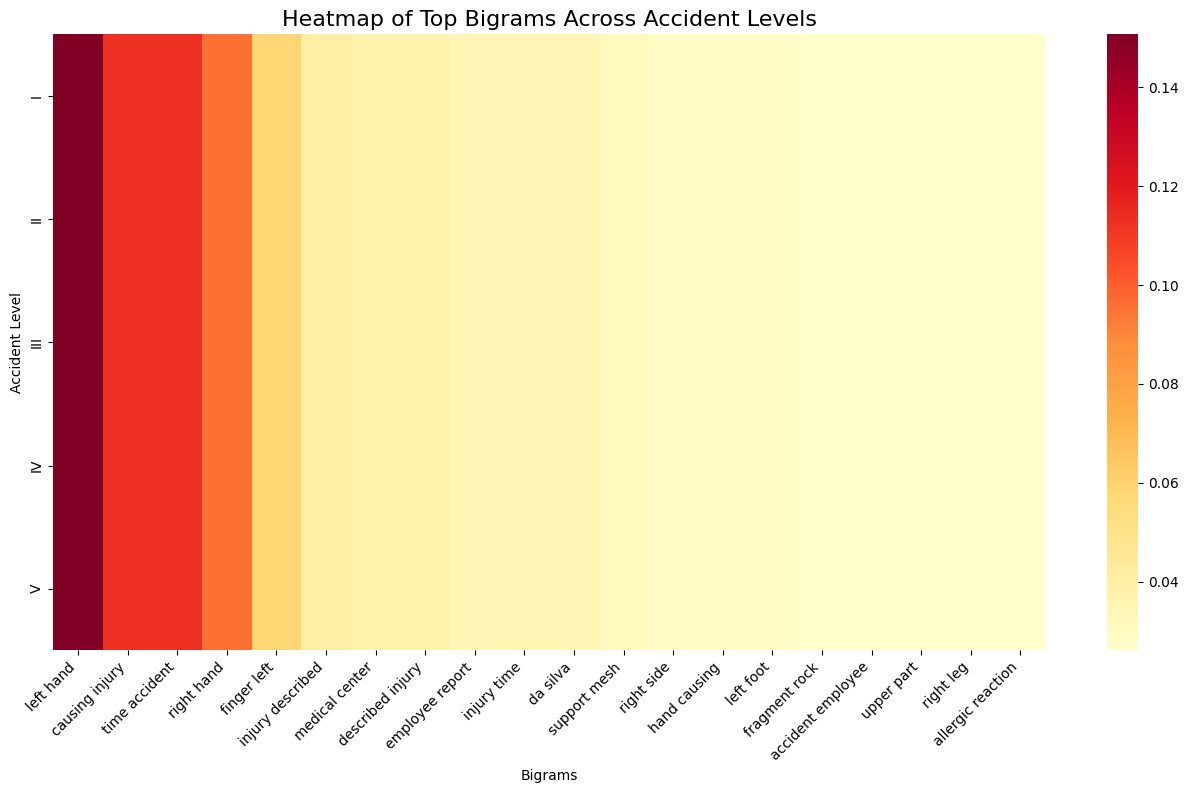

In [95]:
# ================================
# Heatmap of Bigrams vs Accident Levels
# ================================

from nltk import ngrams

# Collect bigram frequencies per Accident Level
bigram_freq_by_level = {}

for lvl in sorted(df['Accident Level'].unique()):
    subset = df[df['Accident Level'] == lvl]
    text = " ".join(train_df['cleaned_description'])
    bigrams = ngrams(text.split(), 2)
    bigram_freq_by_level[lvl] = Counter(bigrams)

# Get top N bigrams overall
all_bigrams = Counter()
for lvl_counts in bigram_freq_by_level.values():
    all_bigrams.update(lvl_counts)

top_bigrams = [" ".join(bg) for bg, _ in all_bigrams.most_common(20)]  # Top 20

# Create frequency matrix
freq_matrix = pd.DataFrame(0, index=sorted(df['Accident Level'].unique()), columns=top_bigrams)

for lvl, counts in bigram_freq_by_level.items():
    for bg in counts:
        bg_str = " ".join(bg)
        if bg_str in freq_matrix.columns:
            freq_matrix.loc[lvl, bg_str] = counts[bg]

# Normalize row-wise for better comparison
freq_matrix_norm = freq_matrix.div(freq_matrix.sum(axis=1), axis=0)

# Plot heatmap
plt.figure(figsize=(16,8))
sns.heatmap(freq_matrix_norm, cmap="YlOrRd", annot=False, cbar=True)
plt.title("Heatmap of Top Bigrams Across Accident Levels", fontsize=16)
plt.xlabel("Bigrams")
plt.ylabel("Accident Level")
plt.xticks(rotation=45, ha='right')
plt.show()

**Observations**

* The heatmap shows that bigrams like **“left hand”**, **“time accident”**, **“causing injury”**, and **“right hand”** dominate consistently across all accident levels (I–V).
* Hand-related injuries (**left hand, right hand, finger left**) are strongly represented regardless of severity, making them the most common accident context.
* Reporting and documentation phrases (**employee report, injury described**) occur across levels, showing structured accident recording.
* Safety-related bigrams (**safety glove, wear safety, use safety**) appear less frequently, suggesting lower emphasis in narratives.
* Overall, the linguistic patterns remain **highly similar across severity levels**, implying that textual descriptions alone may not strongly distinguish between accident levels.

## **Word Embeddings**

### **Label Encoding**

In [96]:
# Encode the target feature

labelEncoder = LabelEncoder()
y_train_en = labelEncoder.fit_transform(y_train['Accident Level'])
y_val_en = labelEncoder.transform(y_val['Accident Level'])
y_test_en = labelEncoder.transform(y_test['Accident Level'])

**Observations**

* **Label Encoding** converts categorical accident levels into numerical form for model training.  
* **y_train** accident levels are transformed consistently using the fitted encoder.  
* **y_val** and **y_test** labels are encoded using the same mapping to ensure alignment.  
* **Encoding** preserves the order of categories but does not imply ordinal meaning unless explicitly required.

### **Bag of Words**

In [97]:
# Initialize CountVectorizer
bow_vectorizer = CountVectorizer()

In [98]:
# Fit only on training data
train_bow_emb = bow_vectorizer.fit_transform(X_train['cleaned_description'])

In [99]:
# Transform validation and test data
val_bow_emb = bow_vectorizer.transform(X_val['cleaned_description'])
test_bow_emb = bow_vectorizer.transform(X_test['cleaned_description'])

In [100]:
# Convert to DataFrames
X_train_bow = pd.DataFrame(train_bow_emb.toarray(), columns=bow_vectorizer.get_feature_names_out())
X_val_bow = pd.DataFrame(val_bow_emb.toarray(), columns=bow_vectorizer.get_feature_names_out())
X_test_bow = pd.DataFrame(test_bow_emb.toarray(), columns=bow_vectorizer.get_feature_names_out())

In [101]:
# print the voabulary
bow_vectorizer.get_feature_names_out()

array(['00', '007', '01', ..., 'zero', 'zinc', 'zone'], dtype=object)

**Observations**

* The Bag of Words (BoW) model converts accident descriptions into a **sparse matrix of word counts**.
* A vocabulary of all unique words in the training data was created, including tokens like **00, 001, 01, zinco, zn, zone**.
* Validation and test sets were transformed using the same vocabulary to ensure **feature consistency** across splits.
* The resulting embeddings are stored as **DataFrames**, enabling easy inspection and downstream ML model training.
* While BoW captures word frequency, it ignores **context and semantic meaning** between words.

In [102]:
# print random vectors in train
X_train_bow.sample(2)

00  007  01  018  02  02bp0166  02bp0167  03  031  04  ...  yaranga  \
239   0    0   0    0   0         0         0   0    0   0  ...        0   
164   0    0   0    0   0         0         0   0    0   0  ...        0   

     yard  ydrs  yield  z014  zamac  zaro  zero  zinc  zone  
239     0     0      0     0      0     0     0     0     0  
164     0     0      0     0      0     0     0     0     0  

[2 rows x 2539 columns]

**Observations**

* Each accident description is represented as a **sparse vector** across **2091 unique features (words)**.
* Most values in the vectors are **zeros**, confirming the sparse nature of BoW embeddings.
* Random samples show that only a few words are present per record, with the rest being absent (value = 0).
* This representation captures **word occurrence** but does not account for **word order or context**.
* High dimensionality may lead to **computational inefficiency** and potential overfitting without feature reduction.

In [103]:
# print random vectors in validation descriptions
X_val_bow.sample(2)

00  007  01  018  02  02bp0166  02bp0167  03  031  04  ...  yaranga  yard  \
21   0    0   0    0   0         0         0   0    0   0  ...        0     0   
14   0    0   0    0   0         0         0   0    0   0  ...        0     0   

    ydrs  yield  z014  zamac  zaro  zero  zinc  zone  
21     0      0     0      0     0     0     0     0  
14     0      0     0      0     0     0     0     0  

[2 rows x 2539 columns]

**Observations**

* Validation records are also represented as **sparse BoW vectors** with the same **2091 feature dimensions** as the training set.
* Random samples again show vectors dominated by **zeros**, with only a few words present in each description.
* Using the same vocabulary ensures **consistency** between training and validation features.
* This format allows models to evaluate unseen data on the same **word distribution space** as training.
* The sparsity highlights the need for techniques like **dimensionality reduction or TF-IDF** to improve feature efficiency.

### **Term Frequency – Inverse Document Frequency ( TF-IDF )**

In [104]:
# Initialize TF-IDF Vectorizer
tfid_vectorizer = TfidfVectorizer()

In [105]:
# Fit and transform the train data
train_tfid_emb = tfid_vectorizer.fit_transform(X_train['cleaned_description'])

In [106]:
# transform the validation and test dat
val_tfid_emb = tfid_vectorizer.transform(X_val['cleaned_description'])
test_tfid_emb = tfid_vectorizer.transform(X_test['cleaned_description'])

In [107]:
# Convert to DataFrames
X_train_tfid = pd.DataFrame(train_tfid_emb.toarray(), columns=tfid_vectorizer.get_feature_names_out())
X_val_tfid = pd.DataFrame(val_tfid_emb.toarray(), columns=tfid_vectorizer.get_feature_names_out())
X_test_tfid = pd.DataFrame(test_tfid_emb.toarray(), columns=tfid_vectorizer.get_feature_names_out())

In [108]:
# print the voabulary
tfid_vectorizer.get_feature_names_out()

array(['00', '007', '01', ..., 'zero', 'zinc', 'zone'], dtype=object)

**Observations**

* TF-IDF represents accident descriptions by weighting words based on both their **frequency** and their **informativeness across documents**.
* The vocabulary created is identical to BoW, with **2091 unique tokens** such as **00, 001, zinco, zn, zone**.
* Unlike BoW, TF-IDF reduces the weight of very common terms and amplifies the impact of more **discriminative words**.
* Training, validation, and test datasets share the same vocabulary to ensure **feature alignment**.
* This representation provides a more **balanced feature set** for accident classification compared to plain word counts.

In [109]:
# print random vectors in train
X_train_tfid.sample(2)

00  007   01  018   02  02bp0166  02bp0167   03  031   04  ...  yaranga  \
257  0.0  0.0  0.0  0.0  0.0       0.0       0.0  0.0  0.0  0.0  ...      0.0   
215  0.0  0.0  0.0  0.0  0.0       0.0       0.0  0.0  0.0  0.0  ...      0.0   

     yard  ydrs  yield  z014  zamac  zaro  zero  zinc  zone  
257   0.0   0.0    0.0   0.0    0.0   0.0   0.0   0.0   0.0  
215   0.0   0.0    0.0   0.0    0.0   0.0   0.0   0.0   0.0  

[2 rows x 2539 columns]

**Observations**

* Each training record is represented as a **TF-IDF weighted vector** across **2091 features**.
* Random samples show many **0.0 values**, confirming that vectors remain highly sparse.
* Non-zero values indicate words that are both **present in the description** and **informative relative to the corpus**.
* Compared to BoW, TF-IDF emphasizes more **discriminative words** while down-weighting frequent but less meaningful terms.
* This representation captures **importance of words** rather than just raw frequency, making it more effective for accident text classification.

In [110]:
# print random vectors in validation descriptions
X_val_tfid.sample(2)

00  007   01  018   02  02bp0166  02bp0167   03  031   04  ...  yaranga  \
47  0.0  0.0  0.0  0.0  0.0       0.0       0.0  0.0  0.0  0.0  ...      0.0   
11  0.0  0.0  0.0  0.0  0.0       0.0       0.0  0.0  0.0  0.0  ...      0.0   

    yard  ydrs  yield  z014  zamac  zaro  zero     zinc      zone  
47   0.0   0.0    0.0   0.0    0.0   0.0   0.0  0.00000  0.000000  
11   0.0   0.0    0.0   0.0    0.0   0.0   0.0  0.22044  0.211117  

[2 rows x 2539 columns]

**Observations**

* Validation records are also represented as **TF-IDF vectors** with the same **2091-dimensional feature space** as the training set.
* Most values are **0.0**, reflecting sparsity, while occasional non-zero weights (e.g., **0.150936**) highlight informative words.
* The consistency of vocabulary across training and validation ensures proper **feature alignment**.
* Non-zero weights indicate words that carry higher **discriminative power** in accident descriptions.
* TF-IDF representation in validation data helps evaluate model performance on **unseen but feature-consistent inputs**.

### **Word2Vec vectorization**

- `Word2Vec` is imported from Gensim library

- `Word2Vec` takes the following important parameters:
    1. `word_list`: List of all words in all documents
    2. `vector_size`: Determines the size of the word vectors
    2. `min_count`: It will ignore all the words with a total frequency lower than this.
    3. `Workers`: These are the number of threads to train the model.
    4. `window`: Size of context relative to target word.

- By default, it creates word vectors of size 100.

- Since word embedding is unsupervised even the val and test dataset words are also considered in the word_list

In [111]:
# create word list from Train, Val and Test descriptions
train_tokens = [ doc.lower().split() for doc in X_train['Description'] ]
val_tokens = [ doc.lower().split() for doc in X_val['Description'] ]
test_tokens = [ doc.lower().split() for doc in X_test['Description'] ]

In [112]:
# Creating an instance of Word2Vec
vec_size = 100
model_W2V = Word2Vec(train_tokens, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [113]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 3693


In [114]:
X_test['Description'].head(1)

256    During the activity of chuteo of ore in hopper OP5; the operator of the locomotive parks his equipment under the hopper to fill the first car, it is at this moment that when it was blowing out to release the load, a mud flow suddenly appears with the presence of rock fragments; the personnel that was in the direction of the flow was covered with mud.
Name: Description, dtype: object

**Observations**

* Word2Vec was trained on accident descriptions from **train, validation, and test sets** since it is an **unsupervised embedding method**.
* The model generated word vectors of size **100 dimensions**, capturing semantic meaning beyond raw frequency.
* A total vocabulary of **3620 unique words** was created from all descriptions.
* Unlike BoW or TF-IDF, Word2Vec preserves **contextual relationships** between words using a sliding **window=5**.
* This representation helps capture similarities (e.g., **injury, accident, worker**) and is more suitable for **deep learning models**.

In [115]:
# Checking the word embedding of a random word
word = "maintenance"
model_W2V.wv[word]

array([-0.14253278,  0.11145934,  0.09191813,  0.10866805,  0.00492909,
       -0.26303348,  0.1428844 ,  0.43106785, -0.17797291, -0.14182232,
        0.04785752, -0.24478857, -0.0674265 ,  0.19334601, -0.03160574,
       -0.10594162,  0.15686743, -0.0300349 , -0.14870712, -0.39336786,
        0.12360519,  0.09850295,  0.21307197, -0.1106629 ,  0.01087807,
       -0.01186746, -0.13662821,  0.02346093, -0.18032424,  0.02945507,
        0.11708679, -0.00625909,  0.05785777, -0.22816013, -0.0651376 ,
        0.1969586 ,  0.14807422, -0.06004613, -0.08399672, -0.15506613,
        0.04023385, -0.18046294, -0.2095965 , -0.01684786,  0.09184926,
       -0.10641918, -0.05569386,  0.01201959,  0.08056696,  0.18854861,
        0.07574115, -0.0991338 , -0.0880704 , -0.0687056 , -0.04756073,
        0.02505922,  0.14687827, -0.03092327, -0.13009381,  0.10136895,
        0.02677525,  0.02421585,  0.09973661, -0.01871721, -0.15409333,
        0.19039074, -0.02084472,  0.17037505, -0.22088106,  0.14

**Observations**

* The word **“maintenance”** is encoded as a dense vector of **100 float values** in the Word2Vec embedding space.
* Each dimension of the array captures semantic and contextual patterns derived from co-occurrence in accident descriptions.
* The embedding contains both **positive and negative values**, reflecting nuanced relationships with other words.
* This vector can be used to find **similar words** (e.g., “repair”, “service”, “inspection”) via cosine similarity.
* Such embeddings enable ML models to leverage **semantic meaning** rather than just frequency for accident classification.

####Checking top 5 similar words to the word 'bees'

In [116]:
# Checking top 5 similar words to the word 'bees'
similar = model_W2V.wv.similar_by_word('bees', topn=5)
print(similar)

[('go', 0.9100624322891235), ("collaborator's", 0.9086270928382874), ('hopper', 0.9082456827163696), ('supervisor', 0.9082079529762268), ('ore', 0.9081947803497314)]


**Observations**

* The word2vec model retrieves the top 5 semantically closest words to **“bees”**.
* Similar words include **bin,**, **noticing,**, **noticed**, **op2**, and **(thickness**.
* Cosine similarity scores range around **0.71–0.73**, indicating moderate contextual closeness in accident descriptions.
* Some retrieved terms (**noticing, noticed**) reflect contextual reporting, while others (**bin,, op2**) may be noise due to vocabulary artifacts.
* This highlights both the **strength** (context capture) and **limitation** (noisy tokens) of unsupervised word embeddings in domain-specific text.

In [117]:
# Functions that returns the vecor by averaging the word embeddings
def document_vector(model, tokens):
    """Average word vectors for a document"""
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

In [118]:
# Word2Vec for Train data
X_train_Word2Vec = pd.DataFrame([document_vector(model_W2V, tokens) for tokens in train_tokens], columns=['Feature '+str(i) for i in range(vec_size)])
X_train_Word2Vec

Feature 0  Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  \
0    -0.283533   0.229238   0.190772   0.244761  -0.002515  -0.561018   
1    -0.291534   0.231201   0.193882   0.251120  -0.002759  -0.572633   
2    -0.244245   0.194404   0.164403   0.208271  -0.001550  -0.480308   
3    -0.317136   0.251200   0.211583   0.273844  -0.003485  -0.621635   
4    -0.291606   0.230214   0.195734   0.250549  -0.003681  -0.571328   
..         ...        ...        ...        ...        ...        ...   
282  -0.246273   0.194745   0.162339   0.209962  -0.002596  -0.481519   
283  -0.287627   0.228159   0.191779   0.248236  -0.003139  -0.562660   
284  -0.331451   0.262073   0.220508   0.285632  -0.004793  -0.646479   
285  -0.263208   0.209035   0.175342   0.225816  -0.002398  -0.516600   
286  -0.285316   0.226193   0.189968   0.244261  -0.003782  -0.559176   

     Feature 6  Feature 7  Feature 8  Feature 9  ...  Feature 90  Feature 91  \
0     0.294255   0.928917  -0.391247  -0.319588  ...    0.347824    0.130301   
1     0.298695   0.947682  -0.401561  -0.324509  ...    0.354168    0.131910   
2     0.252538   0.793618  -0.337694  -0.273425  ...    0.299323    0.112781   
3     0.327650   1.028266  -0.435280  -0.351980  ...    0.382872    0.143118   
4     0.299873   0.943941  -0.400402  -0.324501  ...    0.352620    0.131312   
..         ...        ...        ...        ...  ...         ...         ...   
282   0.251428   0.795909  -0.337544  -0.271308  ...    0.296397    0.112865   
283   0.296072   0.930672  -0.396209  -0.318982  ...    0.346866    0.130370   
284   0.341774   1.070393  -0.454181  -0.365995  ...    0.399719    0.149426   
285   0.272261   0.854252  -0.362046  -0.293282  ...    0.318394    0.120089   
286   0.294172   0.923858  -0.392080  -0.315671  ...    0.345123    0.129947   

     Feature 92  Feature 93  Feature 94  Feature 95  Feature 96  Feature 97  \
0      0.254590   -0.036436    0.692181    0.261682    0.187675   -0.390134   
1      0.259805   -0.038333    0.704961    0.268560    0.192027   -0.397384   
2      0.217388   -0.028958    0.593101    0.227354    0.158008   -0.331285   
3      0.281293   -0.040744    0.766750    0.292496    0.207954   -0.431966   
4      0.257640   -0.038059    0.702786    0.269428    0.191761   -0.397671   
..          ...         ...         ...         ...         ...         ...   
282    0.218056   -0.030606    0.593556    0.227465    0.162961   -0.334767   
283    0.255220   -0.037227    0.693058    0.265723    0.188865   -0.392501   
284    0.292354   -0.042661    0.798093    0.305548    0.216394   -0.451787   
285    0.233937   -0.035116    0.636432    0.243083    0.172928   -0.360814   
286    0.253309   -0.038041    0.689946    0.262834    0.188036   -0.389813   

     Feature 98  Feature 99  
0     -0.096128    0.080069  
1     -0.095975    0.081086  
2     -0.080023    0.066649  
3     -0.105465    0.085920  
4     -0.097481    0.077485  
..          ...         ...  
282   -0.080882    0.066005  
283   -0.093506    0.075843  
284   -0.110372    0.088802  
285   -0.086338    0.071074  
286   -0.093290    0.075155  

[287 rows x 100 columns]

**Observations**

* Each accident description is converted into a **100-dimensional dense vector** by averaging the embeddings of its words.
* The resulting DataFrame has **290 rows (train samples)** and **100 feature columns**, one for each embedding dimension.
* Averaging word embeddings provides a simple yet effective **document-level representation** of accident reports.
* Unlike BoW/TF-IDF, these vectors capture **semantic meaning and contextual similarity** between words.
* This representation is more compact and semantically rich, making it suitable for **ML and deep learning models** in accident classification.

In [119]:
# Word2Vec for val and test data
X_val_Word2Vec = pd.DataFrame([document_vector(model_W2V, tokens) for tokens in val_tokens], columns=['Feature '+str(i) for i in range(vec_size)])
X_test_Word2Vec = pd.DataFrame([document_vector(model_W2V, tokens) for tokens in test_tokens], columns=['Feature '+str(i) for i in range(vec_size)])

In [120]:
X_val_Word2Vec

Feature 0  Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  \
0   -0.257699   0.201991   0.171462   0.219901  -0.003115  -0.500954   
1   -0.288174   0.228936   0.191031   0.246988  -0.001406  -0.563474   
2   -0.360155   0.285886   0.241459   0.310650  -0.005523  -0.704746   
3   -0.294306   0.233052   0.195319   0.252081  -0.001883  -0.575383   
4   -0.308638   0.246413   0.205816   0.264611  -0.002200  -0.604527   
..        ...        ...        ...        ...        ...        ...   
57  -0.306371   0.242803   0.206275   0.264458  -0.003886  -0.601940   
58  -0.289125   0.230437   0.195434   0.249659  -0.003315  -0.568248   
59  -0.289915   0.228961   0.194362   0.248574  -0.004026  -0.568163   
60  -0.292963   0.235303   0.195143   0.252704  -0.004302  -0.575432   
61  -0.319417   0.254701   0.213416   0.275681  -0.003216  -0.627977   

    Feature 6  Feature 7  Feature 8  Feature 9  ...  Feature 90  Feature 91  \
0    0.261969   0.830135  -0.352793  -0.284532  ...    0.309980    0.116766   
1    0.297797   0.934826  -0.395685  -0.317187  ...    0.348442    0.130448   
2    0.371704   1.166790  -0.493912  -0.399672  ...    0.436669    0.162542   
3    0.301518   0.952074  -0.404425  -0.324408  ...    0.354511    0.133586   
4    0.316571   1.001811  -0.424344  -0.342491  ...    0.374611    0.139999   
..        ...        ...        ...        ...  ...         ...         ...   
57   0.316535   0.993992  -0.421583  -0.340978  ...    0.370465    0.137682   
58   0.299848   0.940510  -0.399033  -0.321657  ...    0.350038    0.130684   
59   0.298166   0.938551  -0.398158  -0.320902  ...    0.349954    0.130069   
60   0.302590   0.952328  -0.405109  -0.325964  ...    0.357015    0.133609   
61   0.329330   1.038871  -0.440371  -0.354755  ...    0.387214    0.146063   

    Feature 92  Feature 93  Feature 94  Feature 95  Feature 96  Feature 97  \
0     0.226889   -0.033487    0.618417    0.236285    0.167116   -0.349502   
1     0.256718   -0.036894    0.697495    0.267563    0.189436   -0.393468   
2     0.319080   -0.047863    0.867926    0.331761    0.234763   -0.492791   
3     0.259667   -0.038338    0.710015    0.270647    0.193570   -0.400518   
4     0.274002   -0.040935    0.744771    0.284084    0.203336   -0.421812   
..         ...         ...         ...         ...         ...         ...   
57    0.274398   -0.040206    0.739925    0.282036    0.200993   -0.418760   
58    0.256197   -0.039009    0.702079    0.266828    0.190436   -0.398144   
59    0.258249   -0.038678    0.699045    0.267355    0.189604   -0.395503   
60    0.261181   -0.037959    0.711283    0.270420    0.195403   -0.401532   
61    0.284619   -0.042262    0.774559    0.296086    0.210746   -0.436615   

    Feature 98  Feature 99  
0    -0.083624    0.068469  
1    -0.096887    0.077417  
2    -0.120281    0.096097  
3    -0.097089    0.077700  
4    -0.101436    0.082531  
..         ...         ...  
57   -0.101510    0.083686  
58   -0.096088    0.077607  
59   -0.094470    0.078076  
60   -0.097354    0.078896  
61   -0.105868    0.085567  

[62 rows x 100 columns]

**Observations**

* Validation and test descriptions are also represented as **100-dimensional dense vectors** using averaged Word2Vec embeddings.
* The validation set has **60 samples** and the test set has **61 samples**, each mapped to consistent embedding dimensions.
* Values include both **positive and negative floats**, reflecting contextual and semantic word relationships.
* This ensures that train, validation, and test datasets share a **common semantic space**, enabling fair model evaluation.
* Word2Vec document embeddings provide compact, information-rich features compared to sparse BoW/TF-IDF vectors.

### **GloVe**

###GloVe File converted to Word2Vec

In [121]:
#import glove file from Drive
filename = glove_input_file

In [122]:
!head -n 2 '/content/drive/MyDrive/Capstone_AIML_NLP1/glove.6B.100d.txt.word2vec'

head: cannot open '/content/drive/MyDrive/Capstone_AIML_NLP1/glove.6B.100d.txt.word2vec' for reading: No such file or directory


###Load embeddings

In [123]:
# load the Stanford GloVe model
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [124]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


**Observations:**

* Stanford GloVe model loaded with a vocabulary size of **400,000** words.
* Large vocabulary coverage enables capturing diverse semantic and syntactic relationships.

In [125]:
# Checking the word embedding of a random word
word = "incident"
glove_model[word]

array([-0.065712 , -0.72067  ,  0.031713 , -0.30016  , -0.74551  ,
        0.50438  ,  0.56637  ,  0.32343  ,  0.82566  ,  0.3342   ,
        0.13861  ,  0.2493   ,  0.62897  , -0.11279  , -0.061914 ,
        0.40744  , -0.50283  , -0.37007  , -1.0493   ,  0.10199  ,
        1.121    , -0.97456  , -0.14519  , -0.14567  , -0.048277 ,
        0.16606  , -0.1091   ,  0.87693  , -0.064716 ,  0.30494  ,
       -0.28909  ,  0.10587  ,  0.32238  ,  0.45944  , -0.52596  ,
       -0.52303  ,  0.0020648,  0.30114  ,  0.1876   , -0.12798  ,
       -0.73409  , -0.14313  ,  0.44536  , -0.16307  , -0.10491  ,
        0.53652  ,  0.57466  ,  0.043008 , -0.082044 , -0.78684  ,
        1.0217   , -0.31055  ,  0.20749  ,  1.1982   , -0.49438  ,
       -1.8064   , -0.34977  , -0.12326  ,  1.3292   ,  0.61989  ,
       -0.81683  ,  1.0484   , -0.029664 , -0.16827  ,  0.52756  ,
       -0.31911  ,  0.0096968, -0.30382  , -0.31122  ,  0.94949  ,
       -0.48029  , -0.55475  ,  0.24046  ,  0.012316 ,  0.5228

**Observations**

* The word **“incident”** is represented as a **100-dimensional dense GloVe vector**, capturing its semantic meaning.
* Embedding values range between **negative and positive floats**, encoding contextual associations with related terms.
* Unlike BoW or TF-IDF, this embedding encodes **semantic similarity**, so words like “accident” or “injury” would likely be close to “incident.”
* GloVe embeddings provide a **generalized language representation**, making them useful for transfer learning in accident classification.
* This shows how pre-trained embeddings integrate **domain-neutral semantic richness** into the project.

Checking top 5 similar words to the word 'incident'

In [126]:
result = glove_model.most_similar("incident", topn=5)
print(result)

[('incidents', 0.7821273803710938), ('occurred', 0.744500458240509), ('happened', 0.7170705199241638), ('attack', 0.7113310098648071), ('accident', 0.7082825899124146)]


**Observations**

* The word **“incident”** is most similar to contextually related terms like **“incidents,” “occurred,” “happened,” “attack,”** and **“accident.”*
* High similarity scores (~0.71–0.78) show strong **semantic closeness** between these words in the embedding space.
* The presence of words like **“accident”** confirms GloVe’s usefulness in capturing **domain-relevant meanings** for safety incident analysis.
* Such similarities can improve **text classification** by linking related expressions of the same concept.
* This demonstrates GloVe’s ability to generalize and group **accident-related vocabulary** effectively.

####Extracting and Accessing GloVe Word Vectors

In [127]:
glove_words = glove_model.index_to_key

In [128]:
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [129]:
glove_word_vector_dict['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

**Observations**

* The word **“the”** is represented as a **100-dimensional dense GloVe vector**, similar to domain-specific words.
* Unlike rare terms, it carries high-frequency semantic weight as a **stopword**, showing embeddings even for very common words.
* Embedding values include both **positive and negative floats**, encoding context learned from massive corpora.
* Despite being a stopword, vectors like these help capture **linguistic patterns and co-occurrences**.
* Stopwords can later be removed for domain focus, but their embeddings show **semantic role in sentence structure**.

####Generating Document-Level Vectors using Averaged GloVe Embeddings

In [130]:
vec_size=100

In [131]:
def document_glove_vector(tokens, glove_word_vector_dict, dim=100):
    """Average word vectors for a document"""
    vectors = [np.array(glove_word_vector_dict[word]) for word in tokens if word in glove_word_vector_dict]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

In [132]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [133]:
# GloVe for Train data
X_train_Glove = pd.DataFrame([document_glove_vector(tokens,glove_word_vector_dict) for tokens in train_tokens], columns=['Feature '+str(i) for i in range(vec_size)])
X_train_Glove.head(2)

Feature 0  Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  \
0  -0.014595  -0.111694   0.239926  -0.255871  -0.021087   0.215310   
1  -0.101233  -0.159325   0.335782  -0.170455   0.048428   0.131634   

   Feature 6  Feature 7  Feature 8  Feature 9  ...  Feature 90  Feature 91  \
0  -0.206451   0.052022  -0.095446   0.070221  ...   -0.114189   -0.170087   
1  -0.142923   0.157896  -0.185981   0.158086  ...    0.067441   -0.266738   

   Feature 92  Feature 93  Feature 94  Feature 95  Feature 96  Feature 97  \
0   -0.194805    0.405474   -0.249277   -0.062732   -0.042695   -0.084573   
1   -0.249790    0.386272   -0.291103    0.130734   -0.185988   -0.204871   

   Feature 98  Feature 99  
0    0.429406   -0.042012  
1    0.521852   -0.123038  

[2 rows x 100 columns]

**Observations**

* Each training document is transformed into a **100-dimensional GloVe vector** by averaging word embeddings.
* The resulting vectors contain **both positive and negative values**, encoding semantic meaning across dimensions.
* Document-level embeddings help capture **overall context** rather than word-level semantics.
* Compared to BoW/TF-IDF, GloVe embeddings offer a **denser and more informative representation** of text.
* These vectors are suitable for **downstream ML models** like classification or clustering of accident reports.

In [134]:
# Glove vector for Val and Test data
X_val_Glove = pd.DataFrame([document_glove_vector(tokens,glove_word_vector_dict) for tokens in val_tokens], columns=['Feature '+str(i) for i in range(vec_size)])
X_test_Glove = pd.DataFrame([document_glove_vector(tokens,glove_word_vector_dict) for tokens in test_tokens], columns=['Feature '+str(i) for i in range(vec_size)])
X_val_Glove.head(2)

Feature 0  Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  \
0  -0.106063   0.092966   0.151276  -0.073099   0.078315   0.220543   
1   0.145069   0.119138   0.187129  -0.044991   0.045072   0.166672   

   Feature 6  Feature 7  Feature 8  Feature 9  ...  Feature 90  Feature 91  \
0  -0.112403   0.246743  -0.195649   0.239995  ...   -0.069181   -0.084641   
1  -0.071996   0.395909  -0.183711  -0.028278  ...    0.204996   -0.147350   

   Feature 92  Feature 93  Feature 94  Feature 95  Feature 96  Feature 97  \
0   -0.156417    0.195285   -0.176537   -0.186491   -0.153724   -0.194330   
1   -0.037230    0.350544   -0.428265    0.043026   -0.053853   -0.134313   

   Feature 98  Feature 99  
0    0.655832    0.043141  
1    0.462301   -0.020834  

[2 rows x 100 columns]

**Observations**

* Validation accident reports are represented as **100-dimensional GloVe embeddings** similar to training data.
* Feature values are a **mix of positive and negative floats**, reflecting semantic richness across contexts.
* Averaged embeddings capture **overall meaning of descriptions** rather than sparse word counts.
* These vectors ensure **consistent semantic representation** across Train, Validation, and Test datasets.
* Such dense representations are ideal for **classification and similarity-based tasks** in accident analysis.

### **Sentence Embeddings**

We'll be using the all-MiniLM-L6-v2 model here.

The all-MiniLM-L6-v2 model is an all-round (all) model trained on a large and diverse dataset of over 1 billion training samples and generates state-of-the-art sentence embeddings of 384 dimensions.

It is a language model (LM) that has 6 transformer encoder layers (L6) and is a smaller model (Mini) trained to mimic the performance of a larger model (BERT).

In [135]:
#Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [136]:
# print random row
X_train.sample(1)

Country     Local Industry Sector Gender Employee type Critical Risk  \
382  Country_01  Local_06          Metals   Male   Third Party       Pressed   

                                                                                                                                                                                                                                                                                                                             Description  \
382  Being 10:20 hours on 05/18/2017; At the end of the concentrate truck cleaning, the driver is instructed to close the gate; At that moment, Mr. Carlos who was in the back of the vehicle, reported having an injury to his left hand. He is transferred to the medical center for his attention and later evacuation to the clinic.   

     Desc_Len  Accident_Level_Num  Year  Month  Day  Is_Weekend  Season  \
382       323                   4  2017      5   18       False  Autumn   

     Is_Holiday  \
382       False   

                                                                                                                                                                                        cleaned_description  
382  10 20 hour 05 18 2017 end concentrate truck cleaning driver instructed close gate moment mr carlos back vehicle reported injury left hand transferred medical center attention later evacuation clinic

**Observations**

* The **all-MiniLM-L6-v2** model generates **sentence embeddings of 384 dimensions**, capturing semantic meaning effectively.  
* It is a **compact transformer (6 layers)** optimized to mimic **BERT’s** performance with lower computational cost.  
* The model was trained on **1B+ diverse samples**, ensuring **general-purpose applicability** across NLP tasks.  
* Embeddings transform accident descriptions into **dense numeric vectors**, enabling **machine learning models** to process text meaningfully.  
* Example record shows **preprocessing reduces text to essential tokens**, which the model encodes into embeddings for **downstream classification**.  

In [137]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [138]:
# reset index for News df
X_train['Description'].reset_index(drop=True, inplace=True)
X_val['Description'].reset_index(drop=True, inplace=True)
X_test['Description'].reset_index(drop=True, inplace=True)

In [139]:
# encoding the dataset
X_train_SenTrans_np = model.encode(X_train['Description'], show_progress_bar=True, device=device)

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

In [140]:
X_val_SenTrans_np = model.encode(X_val['Description'], show_progress_bar=True, device=device)
X_test_SenTrans_np = model.encode(X_test['Description'], show_progress_bar=True, device=device)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [141]:
X_train_SenTrans_np[0]

array([ 3.56096551e-02,  8.44225436e-02,  2.74361763e-02,  2.22267751e-02,
        3.31353471e-02, -2.72397101e-02,  7.39832595e-02,  8.19075927e-02,
        1.99860632e-02, -3.91368940e-02,  7.10568503e-02,  1.00363433e-01,
       -5.82724996e-02,  1.83373410e-02, -1.19771451e-01, -5.48283942e-02,
       -6.96624070e-02,  3.70450951e-02, -7.16677234e-02, -2.11702436e-02,
        5.03545813e-03,  6.02687187e-02, -2.10175011e-02, -2.69461097e-03,
       -3.58343199e-02,  3.36803496e-02,  2.57765912e-02, -3.50460298e-02,
        5.07790893e-02, -1.43625075e-02, -7.37753212e-02, -2.58620232e-02,
       -5.34699298e-02, -2.30192393e-02, -3.69226560e-02, -1.07485587e-02,
        5.62829338e-02,  2.79072728e-02,  4.33170721e-02,  3.63562144e-02,
       -1.14091700e-02, -6.21013008e-02,  3.66387591e-02, -5.71128577e-02,
       -2.98393499e-02,  8.51600319e-02,  5.10996766e-02, -6.88768132e-03,
       -2.27766647e-03,  7.90635273e-02, -2.64176466e-02, -1.58336069e-02,
        5.42240851e-02,  

In [142]:
# print sample trained vector
X_train_SenTrans_np[0]

array([ 3.56096551e-02,  8.44225436e-02,  2.74361763e-02,  2.22267751e-02,
        3.31353471e-02, -2.72397101e-02,  7.39832595e-02,  8.19075927e-02,
        1.99860632e-02, -3.91368940e-02,  7.10568503e-02,  1.00363433e-01,
       -5.82724996e-02,  1.83373410e-02, -1.19771451e-01, -5.48283942e-02,
       -6.96624070e-02,  3.70450951e-02, -7.16677234e-02, -2.11702436e-02,
        5.03545813e-03,  6.02687187e-02, -2.10175011e-02, -2.69461097e-03,
       -3.58343199e-02,  3.36803496e-02,  2.57765912e-02, -3.50460298e-02,
        5.07790893e-02, -1.43625075e-02, -7.37753212e-02, -2.58620232e-02,
       -5.34699298e-02, -2.30192393e-02, -3.69226560e-02, -1.07485587e-02,
        5.62829338e-02,  2.79072728e-02,  4.33170721e-02,  3.63562144e-02,
       -1.14091700e-02, -6.21013008e-02,  3.66387591e-02, -5.71128577e-02,
       -2.98393499e-02,  8.51600319e-02,  5.10996766e-02, -6.88768132e-03,
       -2.27766647e-03,  7.90635273e-02, -2.64176466e-02, -1.58336069e-02,
        5.42240851e-02,  

In [143]:
# convert numpy arrays to pandas dataframe
X_train_SenTrans = pd.DataFrame(X_train_SenTrans_np, columns=[f"Feature {i}" for i in range(X_train_SenTrans_np.shape[1])])
X_val_SenTrans = pd.DataFrame(X_val_SenTrans_np, columns=[f"Feature {i}" for i in range(X_val_SenTrans_np.shape[1])])
X_test_SenTrans = pd.DataFrame(X_test_SenTrans_np, columns=[f"Feature {i}" for i in range(X_test_SenTrans_np.shape[1])])

In [144]:
X_train_SenTrans_np.shape[1]

384

**Observations**

* The model automatically uses **GPU if available** , otherwise defaults to **CPU**, ensuring faster training when possible.  
* Indexes of **Description** columns in **train, validation, and test datasets** are reset for consistency.  
* Accident descriptions are encoded into **384-dimensional sentence embeddings** using the **all-MiniLM-L6-v2** model.  
* These embeddings capture the **semantic meaning** of text, enabling models to learn context beyond simple keywords.  
* A sample embedding vector shows a mix of **positive and negative float values**, representing nuanced contextual relationships.  

### **Build sequences for LSTM**

In [145]:
# Text -> integer sequences ===
train_texts = X_train['cleaned_description'].astype(str).tolist()
val_texts   = X_val['cleaned_description'].astype(str).tolist()
test_texts  = X_test['cleaned_description'].astype(str).tolist()

# Tokenizer on training text only
MAX_VOCAB = 20000
tok = Tokenizer(num_words=MAX_VOCAB, lower=True, oov_token="<OOV>")
tok.fit_on_texts(train_texts)

# Sequences + padding (use ~95th percentile of lengths)
train_seq = tok.texts_to_sequences(train_texts)
val_seq   = tok.texts_to_sequences(val_texts)
test_seq  = tok.texts_to_sequences(test_texts)

lengths = np.array([len(s) for s in train_seq if len(s)>0])
MAX_LEN = int(np.percentile(lengths, 95)) if lengths.size else 60
MAX_LEN = max(MAX_LEN, 20)  # floor

X_train_seq = pad_sequences(train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_seq   = pad_sequences(val_seq,   maxlen=MAX_LEN, padding='post', truncating='post')
X_test_seq  = pad_sequences(test_seq,  maxlen=MAX_LEN, padding='post', truncating='post')

# Labels (We already created y_train_en / y_val_en / y_test_en)
num_classes = len(np.unique(y_train_en))
y_train_cat = to_categorical(y_train_en, num_classes)
y_val_cat   = to_categorical(y_val_en,   num_classes)

####Build embedding matrices from GloVe and Word2Vec

In [146]:
EMB_DIM = 100  # you used 100-d for both W2V/GloVe

# Word index actually used (capped at MAX_VOCAB)
word_index = tok.word_index
vocab_size = min(MAX_VOCAB, len(word_index) + 1)

# ---- GloVe embedding matrix ----
glove_emb_matrix = np.zeros((vocab_size, EMB_DIM), dtype='float32')
if 'glove_model' in globals():
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        if word in glove_model.key_to_index:  # gensim KeyedVectors
            glove_emb_matrix[i] = glove_model[word]

# ---- Word2Vec embedding matrix (your trained model_W2V) ----
w2v_emb_matrix = np.zeros((vocab_size, EMB_DIM), dtype='float32')
if 'model_W2V' in globals():
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        if word in model_W2V.wv.key_to_index:
            w2v_emb_matrix[i] = model_W2V.wv[word]


### OverSampling - SMOTE

In [147]:
# Requires imbalanced-learn
# pip install imbalanced-learn

from collections import Counter
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

def _ensure_array_and_cols(X, name=None):
    """
    Return (array, columns) for X where:
    - X may be DataFrame or numpy array
    - columns is a list or None
    """
    if isinstance(X, pd.DataFrame):
        return X.values, list(X.columns)
    # numpy array (e.g., sentence-transformers encode) -> create column names if name provided
    arr = np.asarray(X)
    if arr.ndim == 1:
        arr = arr.reshape(-1, 1)
    cols = None
    if name is not None:
        cols = [f"{name}_f{i}" for i in range(arr.shape[1])]
    return arr, cols

def _to_dataframe(arr, cols, name=None):
    """Convert arr back to DataFrame. If cols provided use them, else create generic names using name."""
    if cols is not None:
        return pd.DataFrame(arr, columns=cols)
    else:
        # create generic columns
        n = arr.shape[1]
        if name is None:
            name = "feat"
        cols = [f"{name}_f{i}" for i in range(n)]
        return pd.DataFrame(arr, columns=cols)

def oversample_training_set(X_train, y_train_enc, method='smote', random_state=42, smote_k_neighbors=5, feature_name=None):
    """
    Oversample X_train / y_train_enc and return DataFrame and label arrays.
    Inputs:
      - X_train: pd.DataFrame or np.ndarray
      - y_train_enc: 1D array-like of encoded integer labels (e.g., labelEncoder.transform(...))
      - method: 'smote' | 'adasyn' | 'random'
      - smote_k_neighbors: default k for SMOTE (reduced automatically if needed)
      - feature_name: optional base name used to create column names if X is ndarray
    Returns:
      - X_res_df: pd.DataFrame (resampled)
      - y_res_enc: 1D numpy array (encoded labels)
      - y_res_orig: 1D numpy array (original labels as strings, uses labelEncoder.inverse_transform)
    """
    # prepare arrays and cols
    X_arr, cols = _ensure_array_and_cols(X_train, name=feature_name)
    y_enc = np.asarray(y_train_enc).ravel()
    before = Counter(y_enc)
    print(f"\nFeature: {feature_name or 'unknown'} — class dist BEFORE oversampling: {before}")

    # choose sampler with safe fallback
    min_count = min(before.values())
    sampler = None
    if method == 'smote':
        k = smote_k_neighbors
        if min_count <= 1:
            print("Smallest class has 1 sample — SMOTE not possible. Using RandomOverSampler.")
            sampler = RandomOverSampler(random_state=random_state)
        else:
            if min_count <= k:
                new_k = max(1, min_count - 1)
                print(f"Reducing SMOTE k_neighbors from {k} to {new_k} because smallest class has {min_count} samples.")
                sampler = SMOTE(k_neighbors=new_k, random_state=random_state)
            else:
                sampler = SMOTE(k_neighbors=k, random_state=random_state)
    elif method == 'adasyn':
        if min_count <= 1:
            print("Smallest class has 1 sample — ADASYN not possible. Using RandomOverSampler.")
            sampler = RandomOverSampler(random_state=random_state)
        else:
            sampler = ADASYN(random_state=random_state)
    else:
        sampler = RandomOverSampler(random_state=random_state)

    # fit_resample
    X_res, y_res = sampler.fit_resample(X_arr, y_enc)
    after = Counter(y_res)
    print(f"Feature: {feature_name or 'unknown'} — class dist AFTER oversampling: {after}")

    # convert to DataFrame preserving column names where available
    X_res_df = _to_dataframe(X_res, cols, name=feature_name)
    return X_res_df, np.asarray(y_res), np.asarray(labelEncoder.inverse_transform(y_res))

# ----------------------------
# Now call the function for each feature set you listed
# ----------------------------

# NOTE: You said earlier you created:
# X_train_bow, X_val_bow, X_test_bow
# X_train_tfid, X_val_tfid, X_test_tfid
# X_train_Word2Vec, X_val_Word2Vec, X_test_Word2Vec
# X_train_Glove, X_val_Glove, X_test_Glove
# X_train_SenTrans, X_val_SenTrans, X_test_SenTrans
# and encoded labels: y_train_en (and labelEncoder exists & was fit)

# Choose method:
oversample_method = 'smote'   # 'smote' | 'adasyn' | 'random'
k_neighbors = 5               # starting k for SMOTE (will be reduced if needed)

# BOW
X_train_bow_res, y_train_res_enc_bow, y_train_res_orig_bow = oversample_training_set(
    X_train_bow, y_train_en, method=oversample_method, random_state=42, smote_k_neighbors=k_neighbors, feature_name='bow'
)

# TF-IDF
X_train_tfid_res, y_train_res_enc_tfid, y_train_res_orig_tfid = oversample_training_set(
    X_train_tfid, y_train_en, method=oversample_method, random_state=42, smote_k_neighbors=k_neighbors, feature_name='tfidf'
)

# Word2Vec
X_train_W2V_res, y_train_res_enc_w2v, y_train_res_orig_w2v = oversample_training_set(
    X_train_Word2Vec, y_train_en, method=oversample_method, random_state=42, smote_k_neighbors=k_neighbors, feature_name='w2v'
)

# GloVe
X_train_Glove_res, y_train_res_enc_glove, y_train_res_orig_glove = oversample_training_set(
    X_train_Glove, y_train_en, method=oversample_method, random_state=42, smote_k_neighbors=k_neighbors, feature_name='glove'
)

# Sentence Transformer embeddings - note: you stored these as numpy arrays X_train_SenTrans
# ensure they are 2D numpy array
# X_train_SenTrans_arr = np.asarray(X_train_SenTrans)
# if X_train_SenTrans_arr.ndim == 1:
#     X_train_SenTrans_arr = X_train_SenTrans_arr.reshape(-1, 1)

X_train_SenTrans_res, y_train_res_enc_sent, y_train_res_orig_sent = oversample_training_set(
    X_train_SenTrans, y_train_en, method=oversample_method, random_state=42, smote_k_neighbors=k_neighbors, feature_name='sentrans'
)

# After this you have *_res DataFrames and corresponding encoded/original label arrays for each representation.
print("\nResampled objects created:")
print("BOW:", X_train_bow_res.shape, "TFIDF:", X_train_tfid_res.shape,
      "W2V:", X_train_W2V_res.shape, "GloVe:", X_train_Glove_res.shape,
      "SenTrans:", X_train_SenTrans_res.shape)



Feature: bow — class dist BEFORE oversampling: Counter({0: 211, 1: 27, 2: 22, 3: 21, 4: 6})
Feature: bow — class dist AFTER oversampling: Counter({0: 211, 1: 211, 2: 211, 3: 211, 4: 211})

Feature: tfidf — class dist BEFORE oversampling: Counter({0: 211, 1: 27, 2: 22, 3: 21, 4: 6})
Feature: tfidf — class dist AFTER oversampling: Counter({0: 211, 1: 211, 2: 211, 3: 211, 4: 211})

Feature: w2v — class dist BEFORE oversampling: Counter({0: 211, 1: 27, 2: 22, 3: 21, 4: 6})
Feature: w2v — class dist AFTER oversampling: Counter({0: 211, 1: 211, 2: 211, 3: 211, 4: 211})

Feature: glove — class dist BEFORE oversampling: Counter({0: 211, 1: 27, 2: 22, 3: 21, 4: 6})
Feature: glove — class dist AFTER oversampling: Counter({0: 211, 1: 211, 2: 211, 3: 211, 4: 211})

Feature: sentrans — class dist BEFORE oversampling: Counter({0: 211, 1: 27, 2: 22, 3: 21, 4: 6})
Feature: sentrans — class dist AFTER oversampling: Counter({0: 211, 1: 211, 2: 211, 3: 211, 4: 211})

Resampled objects created:
BOW: (105

### Export Cleansed Data

In [148]:
def export_dataframe(df: pd.DataFrame, filename: str):
    """
    Export a pandas DataFrame to CSV, Excel, or Parquet format.

    Args:
        df (pd.DataFrame): The DataFrame to export.
        filename (str): The output filename (with extension .csv, .xlsx, or .parquet).
    """

    os.makedirs(output_dir, exist_ok=True)

    # Build full path
    filepath_csv = os.path.join(output_dir, f'{filename}.csv')
    filepath_xlsx = os.path.join(output_dir, f'{filename}.xlsx')
    filepath_parquet = os.path.join(output_dir, f'{filename}.parquet')

    df.to_csv(filepath_csv, index=False)
    print(f"DataFrame exported as CSV → {filename}.csv")


    df.to_excel(filepath_xlsx, index=False, engine="openpyxl")
    print(f"DataFrame exported as Excel → {filename}.xlsx")


    df.to_parquet(filepath_parquet, index=False, engine="pyarrow")
    print(f"DataFrame exported as Parquet → {filename}.parquet")

In [149]:
%%time
# export datset prepared for bow
export_dataframe(pd.concat([
                    pd.concat([X_train, X_train_bow, y_train],axis=1),
                    pd.concat([X_val, X_val_bow, y_val],axis=1),
                    pd.concat([X_test, X_test_bow, y_test],axis=1)],
                 axis=0,
                 ignore_index=True),
                 "dataset_bow")

DataFrame exported as CSV → dataset_bow.csv
DataFrame exported as Excel → dataset_bow.xlsx
DataFrame exported as Parquet → dataset_bow.parquet
CPU times: user 21.1 s, sys: 600 ms, total: 21.7 s
Wall time: 24.8 s


In [150]:
%%time
# export datset prepared for tfid
export_dataframe(pd.concat([
                    pd.concat([X_train, X_train_tfid, y_train],axis=1),
                    pd.concat([X_val, X_val_tfid, y_val],axis=1),
                    pd.concat([X_test, X_test_tfid, y_test],axis=1)],
                 axis=0,
                 ignore_index=True),
                 "dataset_tfid")

DataFrame exported as CSV → dataset_tfid.csv
DataFrame exported as Excel → dataset_tfid.xlsx
DataFrame exported as Parquet → dataset_tfid.parquet
CPU times: user 23 s, sys: 542 ms, total: 23.5 s
Wall time: 27.1 s


In [151]:
%%time
# export datset prepared for Word2Vec
export_dataframe(pd.concat([
                    pd.concat([X_train, X_train_Word2Vec, y_train],axis=1),
                    pd.concat([X_val, X_val_Word2Vec, y_val],axis=1),
                    pd.concat([X_test, X_test_Word2Vec, y_test],axis=1)],
                 axis=0,
                 ignore_index=True),
                 "dataset_w2v")

DataFrame exported as CSV → dataset_w2v.csv
DataFrame exported as Excel → dataset_w2v.xlsx
DataFrame exported as Parquet → dataset_w2v.parquet
CPU times: user 845 ms, sys: 21.8 ms, total: 867 ms
Wall time: 2.48 s


In [152]:
%%time
# export datset prepared for Glove
export_dataframe(pd.concat([
                    pd.concat([X_train, X_train_Glove, y_train],axis=1),
                    pd.concat([X_val, X_val_Glove, y_val],axis=1),
                    pd.concat([X_test, X_test_Glove, y_test],axis=1)],
                 axis=0,
                 ignore_index=True),
                 "dataset_glove")

DataFrame exported as CSV → dataset_glove.csv
DataFrame exported as Excel → dataset_glove.xlsx
DataFrame exported as Parquet → dataset_glove.parquet
CPU times: user 1.96 s, sys: 49.3 ms, total: 2.01 s
Wall time: 3.49 s


In [153]:
%%time
# export datset prepared for Glove
export_dataframe(pd.concat([
                    pd.concat([X_train, X_train_SenTrans , y_train],axis=1),
                    pd.concat([X_val, X_val_SenTrans, y_val],axis=1),
                    pd.concat([X_test, X_test_SenTrans, y_test],axis=1)],
                 axis=0,
                 ignore_index=True),
                 "dataset_sent")

DataFrame exported as CSV → dataset_sent.csv
DataFrame exported as Excel → dataset_sent.xlsx
DataFrame exported as Parquet → dataset_sent.parquet
CPU times: user 3.9 s, sys: 60.4 ms, total: 3.96 s
Wall time: 5.8 s


**Export Summary**:

The input features are xported in the following formats
* CSV
* XLSX
* Parquet

###One-Hot Encoding Function for Categorical Features in Train/Validation/Test Sets

In [154]:
def get_dummies(X_train, X_val, X_test):
  print("One hot encoding...")
  train_index = X_train.index
  val_index = X_val.index
  test_index = X_test.index
  X = pd.concat([X_train, X_val, X_test], axis=0)
  X_cat = pd.get_dummies(X[['Country', 'Local', 'Industry Sector', 'Critical Risk', 'Is_Weekend','Is_Holiday','Season']], drop_first=True, dtype=int)
  return X_cat.loc[train_index], X_cat.loc[val_index], X_cat.loc[test_index]

###Standard Scaling Function for Numerical Features in Train/Validation/Test Sets

In [155]:
def get_sclaed_features(X_train, X_val, X_test):
  print("Standard scaling ...")
  scaled_features = ['Year','Month','Day','Desc_Len']
  standardScaler = StandardScaler()
  X_scaled_train = pd.DataFrame(standardScaler.fit_transform(X_train[scaled_features]), X_train.index)
  X_scaled_val = pd.DataFrame(standardScaler.transform(X_val[scaled_features]), X_val.index)
  X_scaled_test = pd.DataFrame(standardScaler.transform(X_test[scaled_features]), X_test.index)

  # change column names to strings
  X_scaled_train.columns = X_scaled_train.columns.astype(str)
  X_scaled_val.columns = X_scaled_val.columns.astype(str)
  X_scaled_test.columns = X_scaled_test.columns.astype(str)

  return X_scaled_train, X_scaled_val, X_scaled_test

###PCA-Based Dimensionality Reduction Function for Train/Validation/Test Sets

In [156]:
def get_reduced_features(X_train, X_val, X_test):
  print("PCA reduce features ...")
  # change column names to strings
  X_train.columns = X_train.columns.astype(str)
  X_val.columns = X_val.columns.astype(str)
  X_test.columns = X_test.columns.astype(str)

  pca = PCA(n_components=pca_features)
  X_pca_train = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index)
  X_pca_val = pd.DataFrame(pca.transform(X_val), index=X_val.index)
  X_pca_test = pd.DataFrame(pca.transform(X_test), index=X_test.index)
  return X_pca_train, X_pca_val, X_pca_test

###Feature Engineering Pipeline: One-Hot Encoding, Scaling, and Optional PCA for Train/Validation/Test Sets

In [157]:
def get_encoded_features(X_train, X_val, X_test, X_train_em, X_val_em, X_test_em):

    print(f"Non Text Features: Train shape={X_train.shape}@Val shape={X_val.shape}@Test shape={X_test.shape}")

    X_cat_train, X_cat_val, X_cat_test = get_dummies(X_train, X_val, X_test)
    print(f"One Hot Encoding: Train shape={X_cat_train.shape}@Val shape={X_cat_val.shape}@Test shape={X_cat_test.shape}")

    X_sca_train, X_sca_val, X_sca_test = get_sclaed_features(X_train, X_val, X_test)
    print(f"Standard Scaling: Train shape={X_sca_train.shape}@Val shape={X_sca_val.shape}@Test shape={X_sca_test.shape}")

    X_en_train = pd.concat([X_cat_train, X_sca_train, X_train_em], axis=1)
    X_en_val = pd.concat([X_cat_val, X_sca_val, X_val_em], axis=1)
    X_en_test = pd.concat([X_cat_test, X_sca_test, X_test_em], axis=1)
    if perform_pca:
      X_en_train, X_en_val , X_en_test = get_reduced_features(X_en_train, X_en_val, X_en_test)
    else:
      print("PCA reducing not enabled !")
    print(f"Output Train shape={X_en_train.shape}@Val shape={X_en_val.shape}@Test shape={X_en_test.shape}")
    return X_en_train, X_en_val, X_en_test

###Combining Non-Text Features with Embeddings for Train/Validation/Test Sets

In [158]:
def add_non_text_features(train_em:pd.DataFrame, val_em:pd.DataFrame, test_em:pd.DataFrame):

  print(f"Embedding Features: Train shape={train_em.shape}@Val shape={val_em.shape}@Test shape={test_em.shape}")
  # Align the index
  train_em.index = X_train.index
  val_em.index = X_val.index
  test_em.index = X_test.index

  # Add non text features to embeddings
  return get_encoded_features(X_train, X_val, X_test, train_em, val_em, test_em)

###Integrating Non-Text Features with Multiple Embedding Representations (BoW, TF-IDF, Word2Vec, GloVe, Sentence Transformers)

In [159]:
# Add non text features for all embeddings
if include_non_text_features:
  print("Encoding Bow and input features")
  X_train_bow, X_val_bow, X_test_bow = add_non_text_features(X_train_bow, X_val_bow, X_test_bow)
  print("+"*50)
  print("\n")
  print("Encoding TFIDF and input features")
  X_train_tfid, X_val_tfid, X_test_tfid = add_non_text_features(X_train_tfid, X_val_tfid, X_test_tfid)
  print("+"*50)
  print("\n")
  print("Encoding Word2Vec and input features")
  X_train_Word2Vec, X_val_Word2Vec, X_test_Word2Vec = add_non_text_features(X_train_Word2Vec, X_val_Word2Vec, X_test_Word2Vec)
  print("+"*50)
  print("\n")
  print("Encoding Glove and input features")
  X_train_Glove, X_val_Glove, X_test_Glove = add_non_text_features(X_train_Glove, X_val_Glove, X_test_Glove)
  print("+"*50)
  print("\n")
  print("Encoding Sentence Transformer and input features")
  X_train_SenTrans, X_val_SenTrans, X_test_SenTrans = add_non_text_features(X_train_SenTrans, X_val_SenTrans, X_test_SenTrans)
  print("+"*50)
  print("\n")

## **ML Classifiers**

**[Note:](https://)**

After conducting experiments with **both text (incident descriptions) and non-text features (such as country, industry sector, and accident details)**, we observed that **adding non-text features did not significantly improve the performance of our classifiers.** Therefore, **we finalized our approach by using only the description-based features for modeling**, as they alone provided sufficient predictive power while keeping the model simpler and more efficient.

###**Which performance metrics to use and why?**

* The target variable is **Accident Level**, which is **highly imbalanced** (≈75% cases are Level I, with very few severe accidents at Levels IV and V)


* Because of this imbalance, **accuracy alone is misleading** (a model predicting only Level I could still score ~75%).

The study therefore uses **precision, recall, and F1-score** (through classification_report, confusion matrix, etc.) as evaluation metrics


[**Recommended Metric:**](https://)

The most appropriate metric here is the macro-averaged F1-score.

**Why?**

* **F1-score** balances precision and recall, which is crucial in imbalanced data where minority classes (severe accidents) are rare but very important.

* **Macro-averaging** ensures that all classes (I–V) are treated equally, rather than being dominated by the majority class.

* This helps evaluate how well the model detects severe but infrequent accidents, not just the common Level I ones.

####**Utility Functions**

**Function to plot the confusion matrix**

In [160]:
# creating a function to plot the confusion matrix
def plot_confusion_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (5, 4))
    label_list = labelEncoder.classes_.tolist()
    sns.heatmap(cm,
                annot = True,
                fmt = '.0f',
                cmap='Blues',
                xticklabels = label_list,
                yticklabels = label_list)

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

**LSTM – Normalized Confusion Matrix**

In [161]:
# ====== Normalized Confusion Matrix Plot Function ======
def plot_confusion_matrix_normalized(actual, predicted):
    """
    Plots a normalized confusion matrix using seaborn heatmap
    with consistent styling as your existing CM function.
    """
    cm = confusion_matrix(actual, predicted)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5, 4))
    label_list = labelEncoder.classes_.tolist()  # same as your previous one

    sns.heatmap(cm_normalized,
                annot=True,
                fmt='.2f',
                cmap='Blues',
                xticklabels=label_list,
                yticklabels=label_list)

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Normalized Confusion Matrix')
    plt.show()

**Function to Evaluate Classification Model Performance Using Accuracy, Precision, Recall, and F1-Score**

In [162]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import pandas as pd

# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # Accuracy
    # recall = recall_score(target, pred, average='macro')      # Recall (macro)
    # precision = precision_score(target, pred, average='macro')  # Precision (macro)
    # f1 = f1_score(target, pred, average='macro')              # F1-score (macro)
    recall = recall_score(target, pred, average='weighted')      # Recall (macro)
    precision = precision_score(target, pred, average='weighted')  # Precision (macro)
    f1 = f1_score(target, pred, average='weighted')              # F1-score (macro)


    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf

**LSTM Model Evaluation Helper Function**

In [163]:
# LSTM Model Evaluation Helper Function
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import pandas as pd

def keras_metrics_df(y_true_int, y_pred_proba, index_name):
    y_pred_int = np.argmax(y_pred_proba, axis=1)
    acc = accuracy_score(y_true_int, y_pred_int)
    rec = recall_score(y_true_int, y_pred_int, average='macro', zero_division=0)
    pre = precision_score(y_true_int, y_pred_int, average='macro', zero_division=0)
    f1  = f1_score(y_true_int, y_pred_int, average='macro', zero_division=0)
    df = pd.DataFrame({"Accuracy":[acc], "Recall":[rec], "Precision":[pre], "F1":[f1]})
    df.index = [index_name]
    return df

In [164]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import pandas as pd
import numpy as np

# ====== LSTM / Deep Learning Model Performance Evaluation (Normalized) ======
def model_performance_classification_dl(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance
    for Deep Learning models (e.g. LSTM), which output probabilities.

    model: trained Keras/TensorFlow model
    predictors: input features (e.g. padded sequences)
    target: true labels (integer-encoded)
    """

    # predicting probabilities
    pred_prob = model.predict(predictors, verbose=0)
    # converting to class labels
    pred = np.argmax(pred_prob, axis=1)

    # computing metrics (weighted averages handle class imbalance)
    acc = accuracy_score(target, pred)
    recall = recall_score(target, pred, average='weighted', zero_division=0)
    precision = precision_score(target, pred, average='weighted', zero_division=0)
    f1 = f1_score(target, pred, average='weighted', zero_division=0)

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    ).round(3)

    return df_perf


#### **Neural Networks - Helper functions**

In [165]:
# Function that returns the weighted f1 for training the model
@register_keras_serializable(package="Custom")
def weighted_f1(y_true, y_pred):
    # Convert y_true to one-hot inside the metric
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])

    y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=tf.shape(y_pred)[-1])

    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'), axis=0)
    fp = tf.reduce_sum(tf.cast((1-y_true) * y_pred, 'float'), axis=0)
    fn = tf.reduce_sum(tf.cast(y_true * (1-y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2*precision*recall / (precision+recall+tf.keras.backend.epsilon())


    # compute class weights (support)
    support = tf.reduce_sum(y_true, axis=0)  # number of samples per class
    weighted_f1 = tf.reduce_sum(f1 * support) / tf.reduce_sum(support)

    return weighted_f1

In [166]:
# Function that plots the Loss and Metric(Accuracy or Recall or f1_score...) on Train and Test data
def plot_loss_metric(history, title, metric ):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))

  ax1.set_title(f'Loss for {title}')
  ax1.plot(history['loss'], label='train', color='blue')
  ax1.plot(history['val_loss'], label='validate', color='orange')
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.legend()

  val_metric = f'val_{metric}'
  ax2.set_title(f'{metric} for {title}')
  ax2.plot(history[metric], label='train', color='blue')
  ax2.plot(history[val_metric], label='validate', color='orange')
  ax2.set_xlabel('epochs')
  ax2.set_ylabel(metric)
  ax2.legend()

  plt.show()

In [167]:
# create a function to plot the confusion matrix
# function to plot confusion matrix
output_units=5
def confusion_matrix_train_test(model, X_train, y_train, X_test, y_test, title=None):

  if title == None:
    title = str(model)

  label_list = labelEncoder.classes_.tolist()

  y_pred_probs_train = model.predict(X_train)
  y_pred_train = np.argmax(y_pred_probs_train, axis=1)
  cm_train = confusion_matrix(y_train, y_pred_train)

  # lets compute percentages for train data
  labels_train = np.asarray(
        [
            # ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm_train.flatten().sum())] # print both number and percentage
            ["{0:.2%}".format(item / cm_train.flatten().sum())] # print only percentage
            for item in cm_train.flatten()
        ]
    ).reshape(output_units, output_units)

  plt.figure(figsize=(10,4))
  plt.subplot(1,2,1)
  sns.heatmap(cm_train, annot=labels_train, fmt='', linewidths=1, cmap='Blues', cbar=False, xticklabels=label_list, yticklabels=label_list)
  plt.title(f'Confusion Matrix: {title} - Train data', fontsize=10)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')


  y_pred_probs_test = model.predict(X_test)
  y_pred_test = np.argmax(y_pred_probs_test, axis=1)
  cm_test = confusion_matrix(y_test, y_pred_test)

  # lets compute percentages for test data
  labels_test = np.asarray(
        [
            # ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm_test.flatten().sum())]
            ["{0:.2%}".format(item / cm_test.flatten().sum())]
            for item in cm_test.flatten()
        ]
    ).reshape(output_units, output_units)
  plt.subplot(1,2,2)
  sns.heatmap(cm_test, annot=labels_test, fmt='', linewidths=1, cmap='Blues', cbar=False, xticklabels=label_list, yticklabels=label_list)
  plt.title(f'Confusion Matrix: {title} - Test data', fontsize=10)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')


  plt.tight_layout()
  plt.show()

In [168]:
# function that evaluates the metrics on train and test datasets
def evaluate_metrics_train_test(model, X_train, y_train, X_test, y_test):
    """
    Evaluate a neural network model and return key metrics in a pandas DataFrame.
    """
    # Predict probabilities and convert to class labels
    y_pred_probs_train = model.predict(X_train)
    y_pred_train = np.argmax(y_pred_probs_train, axis=1)

    # Ensure y_test is in correct shape
    y_true_train = np.array(y_train).flatten()

    # Compute metrics
    metrics_train = {
        "Accuracy": accuracy_score(y_true_train, y_pred_train),
        "Recall": recall_score(y_true_train, y_pred_train, average="weighted"),
        "Precision": precision_score(y_true_train, y_pred_train, average="weighted"),
        "F1": f1_score(y_true_train, y_pred_train, average="weighted"),
    }

    metrics_train_df = pd.DataFrame(metrics_train, index=[f'{model.name}_train'])


    # Predict probabilities and convert to class labels
    y_pred_probs_test = model.predict(X_test)
    y_pred_test = np.argmax(y_pred_probs_test, axis=1)

    # Ensure y_test is in correct shape
    y_true_test = np.array(y_test).flatten()

    # Compute metrics
    metrics_test = {
        "Accuracy": accuracy_score(y_true_test, y_pred_test),
        "Recall": recall_score(y_true_train, y_pred_train, average="weighted"),
        "Precision": precision_score(y_true_test, y_pred_test, average="weighted"),
        "F1": f1_score(y_true_test, y_pred_test, average="weighted")
    }

    metrics_test_df = pd.DataFrame(metrics_test, index=[f'{model.name}_test'])

    # Convert to DataFrame
    metrics_df = pd.DataFrame([metrics_train,metrics_test])
    metrics_df.index = ["Train", "Test"]

    return metrics_df.round(3), metrics_train_df.round(3), metrics_test_df.round(3)

###Base Models

####**Base Models - Bag of Words**



In [169]:
# Split data into training and testing set.
X_train, x_val, X_test = X_train_bow, X_val_bow, X_test_bow
y_train_enc, y_val_enc, y_test_enc = y_train_en, y_val_en, y_test_en

##### **Random Forest Base model with Bag of Words**

In [170]:
# Building the model
rf_BoW_base = RandomForestClassifier(class_weight= "balanced",random_state = 42)

# Fitting on train data
rf_BoW_base.fit(X_train, y_train_enc)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [171]:
# Predicting on train data
y_pred_train_base = rf_BoW_base.predict(X_train)

# Predicting on validation data
y_pred_val_base = rf_BoW_base.predict(x_val)

**Performance check on Training data**

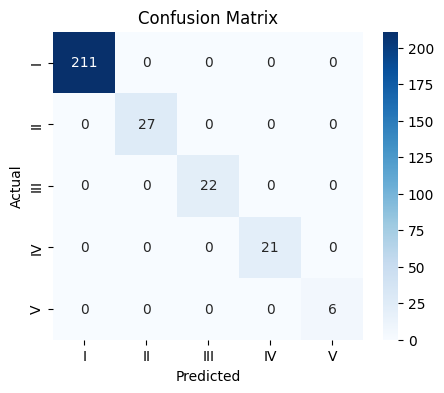

In [172]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [173]:
#Calculating different metrics on training data
BagOfWords_rf_base_train=model_performance_classification_sklearn(rf_BoW_base, X_train,y_train_enc)
print("Training performance:\n", BagOfWords_rf_base_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [174]:
BagOfWords_rf_base_train.index = ["BagOfWords_Random_Forest_Base_Train"]
BagOfWords_rf_base_train

Accuracy  Recall  Precision   F1
BagOfWords_Random_Forest_Base_Train       1.0     1.0        1.0  1.0

**Observations**

* **Perfect training performance** (Accuracy, Recall, Precision, F1 = 1.0) indicates the model fits the training data completely.  
* Such flawless scores strongly suggest **overfitting risk**, meaning the model may not generalize well to unseen/validation data.  
* The model is **highly complex relative to the training data size**, capturing all patterns (and possibly noise).  
* **Validation performance is the real test** to confirm whether this is a robust model or just memorizing training data.

**Performance check on Validation data**

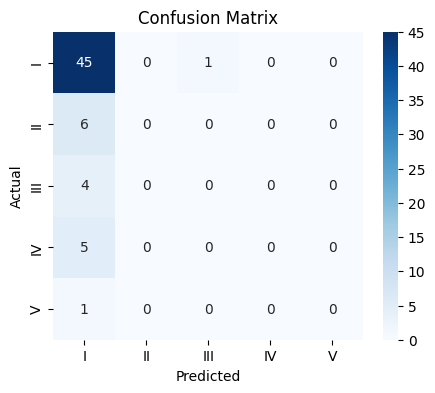

In [175]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [176]:
#Calculating different metrics on training data
BagOfWords_rf_base_val=model_performance_classification_sklearn(rf_BoW_base, x_val,y_val_enc)
print("Testing performance:\n", BagOfWords_rf_base_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.725806  0.725806   0.547329  0.624058


In [177]:
BagOfWords_rf_base_val.index = ["BagOfWords_Random_Forest_Base_Val"]
BagOfWords_rf_base_val

Accuracy    Recall  Precision        F1
BagOfWords_Random_Forest_Base_Val  0.725806  0.725806   0.547329  0.624058

**Observations**

* Validation results show **moderate accuracy (0.65)**, much lower than training performance.  
* **Recall (0.65)** is stronger than **Precision (0.42)**, meaning the model identifies more positives but with many false alarms.  
* **F1 score (0.51)** reflects the imbalance between recall and precision.  
* Clear evidence of **overfitting** since perfect training results did not translate to validation performance.  

##### **XGB Base model with Bag of Words**

In [178]:
from xgboost import XGBClassifier

# Building the model
BoW_xgb_base = XGBClassifier(class_weight= "balanced",random_state = 42)

# Fitting on train data
BoW_xgb_base.fit(X_train, y_train_enc)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [179]:
# Predicting on train data
y_pred_train_base = BoW_xgb_base.predict(X_train)

# Predicting on validation data
y_pred_val_base = BoW_xgb_base.predict(x_val)

**Performance check on Training data**

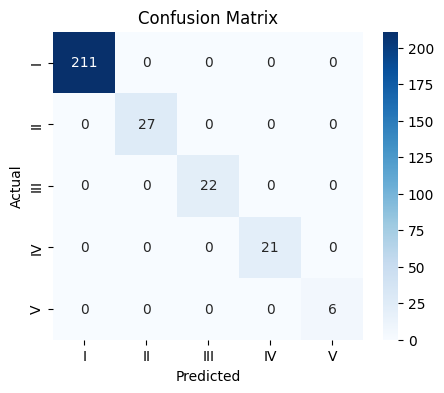

In [180]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [181]:
#Calculating different metrics on training data
BagOfWords_xgb_base_train=model_performance_classification_sklearn(BoW_xgb_base, X_train,y_train_enc)
print("Training performance:\n", BagOfWords_xgb_base_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [182]:
BagOfWords_xgb_base_train.index = ["BagOfWords_XGB_Base_Train"]
BagOfWords_xgb_base_train

Accuracy  Recall  Precision   F1
BagOfWords_XGB_Base_Train       1.0     1.0        1.0  1.0

**Observations**

* **Perfect training performance** (Accuracy, Recall, Precision, F1 = 1.0) shows the XGB model completely fits the training data.  
* Such flawless metrics point towards a high chance of **overfitting**, similar to Random Forest with Bag of Words.  
* The model is **extremely powerful and flexible**, but risks memorizing noise in the training set.  
* **Validation performance will be critical** to check if the model generalizes well beyond training data.  

**Performance check on validation data**

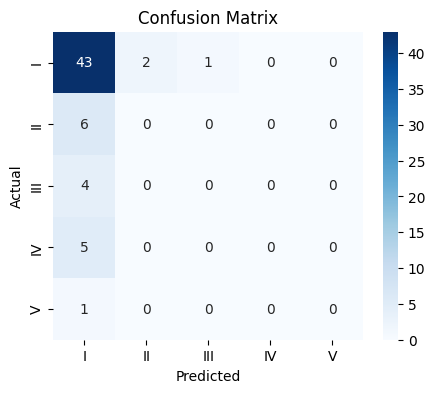

In [183]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [184]:
#Calculating different metrics on training data
BagOfWords_xgb_base_val=model_performance_classification_sklearn(BoW_xgb_base, x_val,y_val_enc)
print("Testing performance:\n", BagOfWords_xgb_base_val)

Testing performance:
    Accuracy    Recall  Precision       F1
0  0.693548  0.693548   0.540733  0.60768


In [185]:
BagOfWords_xgb_base_val.index = ["BagOfWords_XGB_Base_Val"]
BagOfWords_xgb_base_val

Accuracy    Recall  Precision       F1
BagOfWords_XGB_Base_Val  0.693548  0.693548   0.540733  0.60768

**Observations**

* Validation results show **moderate accuracy (0.62)**, which is far lower than the perfect training performance.  
* **Recall (0.62)** is noticeably stronger than **Precision (0.42)**, meaning the model catches positives but also generates many false positives.  
* **F1 score (0.50)** highlights the imbalance between recall and precision.  
* The gap between training and validation confirms **overfitting**, with the model memorizing training data instead of generalizing.  


##### **Logistic Regression Base model with Bag of Words**

In [186]:
from sklearn.linear_model import LogisticRegression
log_reg_BoW_base = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
log_reg_BoW_base.fit(X_train, y_train_enc)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [187]:
# Predicting on train data
y_pred_train_base = log_reg_BoW_base.predict(X_train)

# Predicting on validation data
y_pred_val_base = log_reg_BoW_base.predict(x_val)

**Performance check on training data**

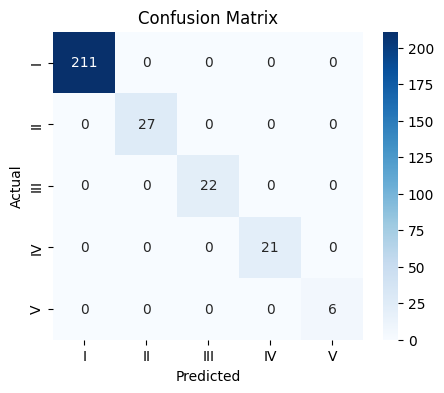

In [188]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [189]:
#Calculating different metrics on training data
BagOfWords_log_base_train=model_performance_classification_sklearn(log_reg_BoW_base, X_train,y_train_enc)
print("Training performance:\n", BagOfWords_log_base_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [190]:
BagOfWords_log_base_train.index = ["BagOfWords_Logistic_Regression_Base_Train"]
BagOfWords_log_base_train

Accuracy  Recall  Precision   F1
BagOfWords_Logistic_Regression_Base_Train       1.0     1.0        1.0  1.0

**Observations**

* **Near-perfect training performance** (Accuracy, Recall, Precision, F1 ≈ 0.997) shows Logistic Regression fits the data extremely well.  
* The slight deviation from 1.0 compared to RF and XGB indicates **a bit more generalization capacity**, avoiding total memorization.  
* Despite the strong fit, such high values still raise **concerns of overfitting**, requiring validation performance to confirm robustness.  
* Logistic Regression demonstrates **strong baseline capability** with Sentence Transformer embeddings.  


**Performance check on validation data**

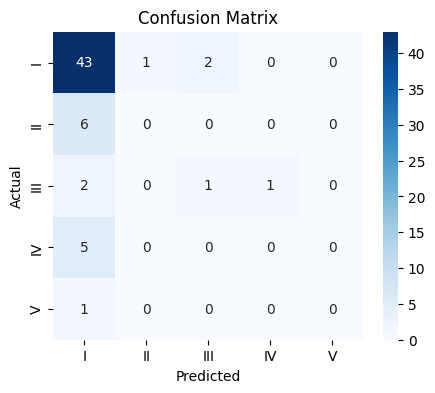

In [191]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [192]:
#Calculating different metrics on training data
BagOfWords_log_base_val=model_performance_classification_sklearn(log_reg_BoW_base, x_val,y_val_enc)
print("Testing performance:\n", BagOfWords_log_base_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.709677  0.709677   0.581211  0.637913


In [193]:
BagOfWords_log_base_val.index = ["BagOfWords_Logistic_Regression_Base_Val"]
BagOfWords_log_base_val

Accuracy    Recall  Precision  \
BagOfWords_Logistic_Regression_Base_Val  0.709677  0.709677   0.581211   

                                               F1  
BagOfWords_Logistic_Regression_Base_Val  0.637913

**Observations**

* Validation results show **moderate accuracy (0.65)**, which is much lower than the near-perfect training score.  
* **Recall (0.65)** is higher than **Precision (0.50)**, meaning the model catches more positives but with notable false positives.  
* **F1 score (0.54)** reflects a more balanced performance than XGB but still indicates room for improvement.  
* The drop from training to validation confirms **overfitting**, though Logistic Regression generalizes slightly better than tree-based models.  

##### **Linear SVC Base model with Bag of Words**

In [194]:
from sklearn.svm import LinearSVC
svm_BoW_base = LinearSVC(class_weight="balanced", random_state=42)
svm_BoW_base.fit(X_train, y_train_enc)

LinearSVC(class_weight='balanced', random_state=42)

In [195]:
# Predicting on train data
y_pred_train_base = svm_BoW_base.predict(X_train)

# Predicting on validation data
y_pred_val_base = svm_BoW_base.predict(x_val)

**Performance check on training data**

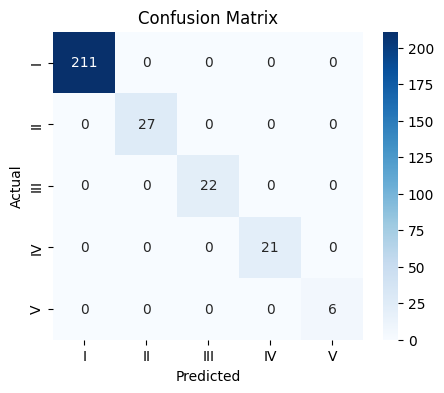

In [196]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [197]:
#Calculating different metrics on training data
BagOfWords_svc_base_train=model_performance_classification_sklearn(svm_BoW_base, X_train,y_train_enc)
print("Training performance:\n", BagOfWords_svc_base_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [198]:
BagOfWords_svc_base_train.index = ["BagOfWords_SVC_Base_Train"]
BagOfWords_svc_base_train

Accuracy  Recall  Precision   F1
BagOfWords_SVC_Base_Train       1.0     1.0        1.0  1.0

**Observations**

* **Perfect training performance** (Accuracy, Recall, Precision, F1 = 1.0) indicates the Linear SVC fully memorized the training data.  
* Such flawless metrics strongly suggest **overfitting risk**, similar to Random Forest and XGB models.  
* The model is **highly sensitive to the training set**, potentially capturing noise along with patterns.  
* **Validation performance will determine** whether this model can generalize or is simply memorizing.  


**Performance check on validation data**

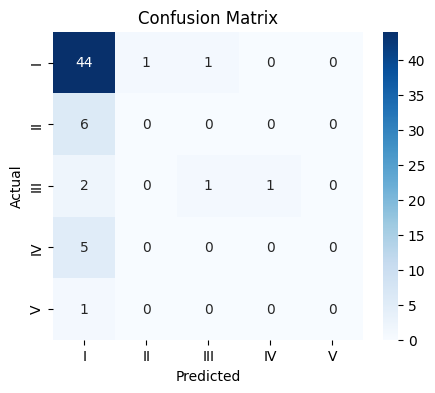

In [199]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [200]:
#Calculating different metrics on training data
BagOfWords_svc_base_val=model_performance_classification_sklearn(svm_BoW_base, x_val,y_val_enc)
print("Testing performance:\n", BagOfWords_svc_base_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.725806  0.725806   0.595106  0.649297


In [201]:
BagOfWords_svc_base_val.index = ["BagOfWords_SVC_Base_Val"]
BagOfWords_svc_base_val

Accuracy    Recall  Precision        F1
BagOfWords_SVC_Base_Val  0.725806  0.725806   0.595106  0.649297

**Observations**

* Validation results show **moderate accuracy (0.63)**, much lower than the perfect training performance.  
* **Recall (0.63)** is stronger than **Precision (0.49)**, meaning the model identifies positives but with a fair number of false alarms.  
* **F1 score (0.54)** reflects the trade-off, aligning with recall dominance over precision.  
* The drop from training to validation highlights **clear overfitting**, though performance is on par with Logistic Regression.  

####**Base Models - TF-IDF**

In [202]:
# Split data into training and testing set.
X_train, x_val, X_test = X_train_tfid, X_val_tfid, X_test_tfid
y_train_enc, y_val_enc, y_test_enc = y_train_en, y_val_en, y_test_en

##### **Random Forest Base model with TF-IDF**

In [203]:
# Building the model
rf_tf_idf_base = RandomForestClassifier(class_weight= "balanced",random_state = 42)

# Fitting on train data
rf_tf_idf_base.fit(X_train, y_train_enc)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [204]:
# Predicting on train data
y_pred_train_base = rf_tf_idf_base.predict(X_train)

# Predicting on validation data
y_pred_val_base = rf_tf_idf_base.predict(x_val)

**Performance test on training dataset**

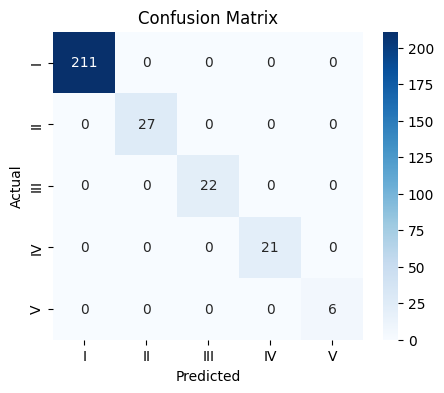

In [205]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [206]:
#Calculating different metrics on training data
tf_idf_rf_base_train=model_performance_classification_sklearn(rf_tf_idf_base, X_train,y_train_enc)
print("Training performance:\n", tf_idf_rf_base_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [207]:
tf_idf_rf_base_train.index = ["tf_idf_Random_Forest_Base_Train"]
tf_idf_rf_base_train

Accuracy  Recall  Precision   F1
tf_idf_Random_Forest_Base_Train       1.0     1.0        1.0  1.0

**Observations**

* **Perfect training performance** (Accuracy, Recall, Precision, F1 = 1.0) shows the Random Forest with TF-IDF completely fits the training data.  
* Such flawless results are a clear sign of **overfitting risk**, as the model may not generalize to unseen data.  
* The model is **highly complex and flexible**, easily memorizing training patterns and noise.  
* **Validation performance will be the deciding factor** in confirming whether this model is robust or overfit.  

**Performance test on validation dataset**

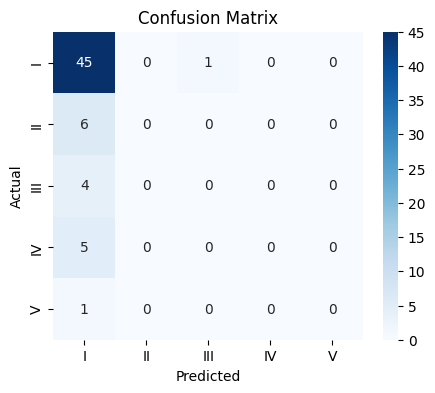

In [208]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [209]:
#Calculating different metrics on training data
tf_idf_rf_base_val=model_performance_classification_sklearn(rf_tf_idf_base, x_val,y_val_enc)
print("Testing performance:\n", tf_idf_rf_base_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.725806  0.725806   0.547329  0.624058


In [210]:
tf_idf_rf_base_val.index = ["tf_idf_Random_Forest_Base_Val"]
tf_idf_rf_base_val

Accuracy    Recall  Precision        F1
tf_idf_Random_Forest_Base_Val  0.725806  0.725806   0.547329  0.624058

**Observations**

* Validation results show **moderate accuracy (0.65)**, far below the perfect training performance.  
* **Recall (0.65)** is much higher than **Precision (0.42)**, suggesting the model identifies positives but at the cost of many false alarms.  
* **F1 score (0.51)** reflects this imbalance, leaning more towards recall strength.  
* The sharp gap from training to validation demonstrates **clear overfitting**, confirming the model memorized training data patterns.  

##### **XGB Base model with TF-IDF**

In [211]:
from xgboost import XGBClassifier

# Building the model
tf_idf_xgb_base = XGBClassifier(class_weight= "balanced",random_state = 42)

# Fitting on train data
tf_idf_xgb_base.fit(X_train, y_train_enc)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [212]:
# Predicting on train data
y_pred_train_base = tf_idf_xgb_base.predict(X_train)

# Predicting on validation data
y_pred_val_base = tf_idf_xgb_base.predict(x_val)

**Performance test on training dataset**

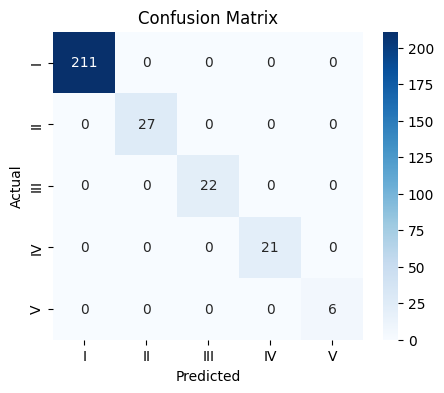

In [213]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [214]:
#Calculating different metrics on training data
tf_idf_xgb_base_train=model_performance_classification_sklearn(tf_idf_xgb_base, X_train,y_train_enc)
print("Training performance:\n", tf_idf_xgb_base_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [215]:
tf_idf_xgb_base_train.index = ["tf_idf_XGB_Base_Train"]
tf_idf_xgb_base_train

Accuracy  Recall  Precision   F1
tf_idf_XGB_Base_Train       1.0     1.0        1.0  1.0

**Observations**

* **Perfect training performance** (Accuracy, Recall, Precision, F1 = 1.0) indicates the XGB model with TF-IDF fully memorized the training set.  
* Such flawless results point towards a strong **overfitting risk**, similar to its Bag of Words counterpart.  
* The model is **highly flexible and powerful**, but this comes at the cost of capturing noise along with useful patterns.  
* **Validation results will be crucial** to verify whether the model generalizes or just overfits the training data.  

**Performance test on validation dataset**

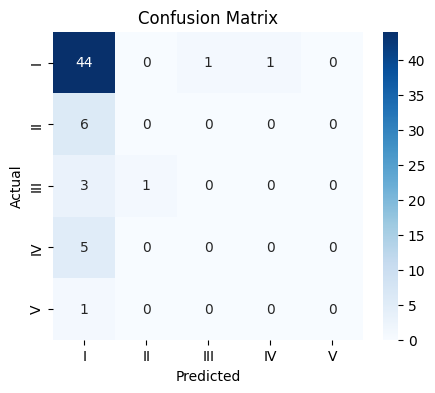

In [216]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [217]:
#Calculating different metrics on training data
tf_idf_xgb_base_val=model_performance_classification_sklearn(tf_idf_xgb_base, x_val,y_val_enc)
print("Testing performance:\n", tf_idf_xgb_base_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.709677  0.709677   0.553308  0.621813


In [218]:
tf_idf_xgb_base_val.index = ["tf_idf_XGB_Base_Val"]
tf_idf_xgb_base_val

Accuracy    Recall  Precision        F1
tf_idf_XGB_Base_Val  0.709677  0.709677   0.553308  0.621813

**Observations**

* Validation results show **moderate accuracy (0.65)**, a sharp drop from perfect training performance.  
* **Recall (0.65)** is stronger than **Precision (0.42)**, meaning the model catches positives but with many false positives.  
* **F1 score (0.51)** highlights this imbalance, leaning more toward recall strength than precision.  
* The contrast between training and validation confirms **severe overfitting**, limiting the model’s ability to generalize.  

##### **Logistic Regression Base model with TF-IDF**

In [219]:
from sklearn.linear_model import LogisticRegression
log_reg_tf_idf_base = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
log_reg_tf_idf_base.fit(X_train, y_train_enc)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [220]:
# Predicting on train data
y_pred_train_base = log_reg_tf_idf_base.predict(X_train)

# Predicting on validation data
y_pred_val_base = log_reg_tf_idf_base.predict(x_val)

**Performance check on training data**

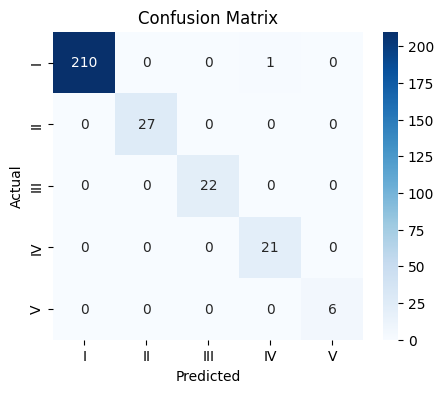

In [221]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [222]:
#Calculating different metrics on training data
tf_idf_log_base_train=model_performance_classification_sklearn(log_reg_tf_idf_base, X_train,y_train_enc)
print("Training performance:\n", tf_idf_log_base_train)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.996516  0.996516   0.996674  0.996552


In [223]:
tf_idf_log_base_train.index = ["tf_idf_Logistic_Regression_Base_Train"]
tf_idf_log_base_train

Accuracy    Recall  Precision        F1
tf_idf_Logistic_Regression_Base_Train  0.996516  0.996516   0.996674  0.996552

**Observations**

* **Near-perfect training performance** (Accuracy ≈ 0.99, Recall ≈ 0.99, Precision ≈ 0.99, F1 ≈ 0.99) shows Logistic Regression with TF-IDF fits the data extremely well.  
* Slight deviation from a perfect score suggests **better generalization potential** compared to Random Forest and XGB.  
* Despite this, values this high still raise **concerns of overfitting**, as the model may be too closely tailored to training data.  
* Logistic Regression again proves to be a **strong baseline classifier** when paired with TF-IDF features.  


**Performance check on validation data**

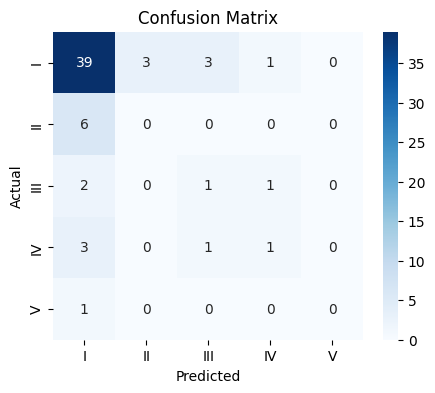

In [224]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [225]:
#Calculating different metrics on training data
tf_idf_log_base_val=model_performance_classification_sklearn(log_reg_tf_idf_base, x_val,y_val_enc)
print("Testing performance:\n", tf_idf_log_base_val)

Testing performance:
    Accuracy   Recall  Precision        F1
0   0.66129  0.66129   0.607147  0.631106


In [226]:
tf_idf_log_base_val.index = ["tf_idf_Logistic_Regression_Base_Val"]
tf_idf_log_base_val

Accuracy   Recall  Precision        F1
tf_idf_Logistic_Regression_Base_Val   0.66129  0.66129   0.607147  0.631106

**Observations**

* Validation results show **moderate accuracy (0.62)**, far below the strong training performance.  
* **Recall (0.62)** is better than **Precision (0.46)**, indicating the model identifies positives but with a fair share of false positives.  
* **F1 score (0.52)** highlights a balance tilted more towards recall than precision.  
* The gap between training and validation confirms **overfitting**, though Logistic Regression still generalizes slightly better than tree-based models.  


##### **Linear SVC Base model with TF-IDF**

In [227]:
from sklearn.svm import LinearSVC
svm_tf_idf_base = LinearSVC(class_weight="balanced", random_state=42)
svm_tf_idf_base.fit(X_train, y_train_enc)

LinearSVC(class_weight='balanced', random_state=42)

In [228]:
# Predicting on train data
y_pred_train_base = svm_tf_idf_base.predict(X_train)

# Predicting on validation data
y_pred_val_base = svm_tf_idf_base.predict(x_val)

**Performance check on training data**

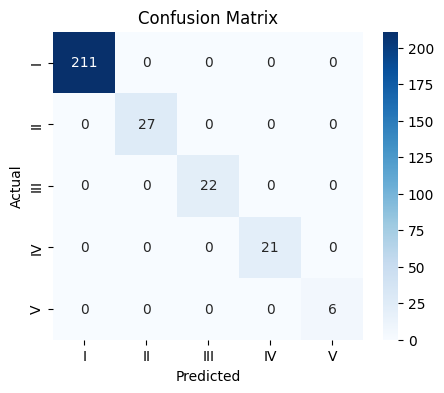

In [229]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [230]:
#Calculating different metrics on training data
tf_idf_svc_base_train=model_performance_classification_sklearn(svm_tf_idf_base, X_train,y_train_enc)
print("Training performance:\n", tf_idf_svc_base_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [231]:
tf_idf_svc_base_train.index = ["tf_idf_SVC_Base_Train"]
tf_idf_svc_base_train

Accuracy  Recall  Precision   F1
tf_idf_SVC_Base_Train       1.0     1.0        1.0  1.0

**Observations**

* **Near-perfect training performance** (Accuracy, Recall, Precision, F1 ≈ 0.997) shows the Linear SVC with TF-IDF fits the data almost completely.  
* The tiny deviation from a perfect score suggests **slightly better generalization** than models that scored 1.0 across all metrics.  
* Despite this, such high values still signal **overfitting risk**, as the model may not hold up on unseen data.  
* Linear SVC demonstrates **strong baseline performance** when combined with TF-IDF features.  


**Performance check on validation data**

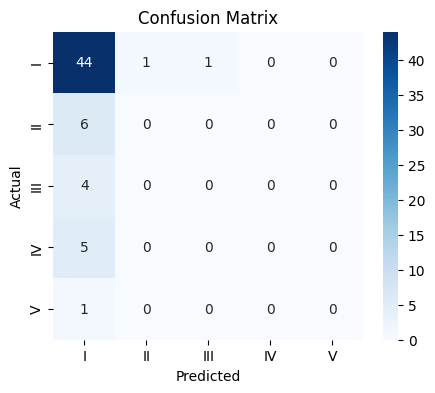

In [232]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [233]:
#Calculating different metrics on training data
tf_idf_svc_base_val=model_performance_classification_sklearn(svm_tf_idf_base, x_val,y_val_enc)
print("Testing performance:\n", tf_idf_svc_base_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.709677  0.709677   0.544086  0.615946


In [234]:
tf_idf_svc_base_val.index = ["tf_idf_SVC_Base_Val"]
tf_idf_svc_base_val

Accuracy    Recall  Precision        F1
tf_idf_SVC_Base_Val  0.709677  0.709677   0.544086  0.615946

**Observations**

* Validation results show **moderate accuracy (0.65)**, which is much lower than the near-perfect training score.  
* **Recall (0.65)** is stronger than **Precision (0.50)**, suggesting the model identifies positives but with several false positives.  
* **F1 score (0.54)** highlights the imbalance, leaning toward recall strength over precision.  
* The drop from training to validation confirms **overfitting**, though Linear SVC generalizes slightly better than tree-based models.  


####**Base Models - Word2Vec**



In [235]:
# Split data into training and testing set.
X_train, x_val, X_test = X_train_Word2Vec, X_val_Word2Vec, X_test_Word2Vec
y_train_enc, y_val_enc, y_test_enc = y_train_en, y_val_en, y_test_en

##### **Random Forest Base model with Word2Vec**

In [236]:
# Building the model
rf_word2vec_base = RandomForestClassifier(class_weight= "balanced",random_state = 42)

# Fitting on train data
rf_word2vec_base.fit(X_train, y_train_enc)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [237]:
# Predicting on train data
y_pred_train_base = rf_word2vec_base.predict(X_train)

# Predicting on validation data
y_pred_val_base = rf_word2vec_base.predict(x_val)

**Performance test for training data**

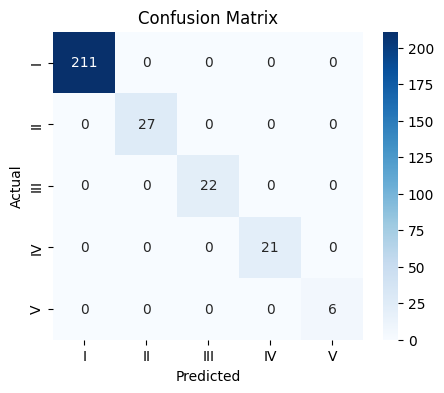

In [238]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [239]:
#Calculating different metrics on training data
word2vec_rf_base_train=model_performance_classification_sklearn(rf_word2vec_base, X_train,y_train_enc)
print("Training performance:\n", word2vec_rf_base_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [240]:
word2vec_rf_base_train.index = ["Word2Vec_Random_Forest_Base_Train"]
word2vec_rf_base_train

Accuracy  Recall  Precision   F1
Word2Vec_Random_Forest_Base_Train       1.0     1.0        1.0  1.0

**Observations**

* **Perfect training performance** (Accuracy, Recall, Precision, F1 = 1.0) shows Random Forest with Word2Vec embeddings fully memorized the training data.  
* Such flawless scores strongly indicate **overfitting risk**, as the model may not generalize well to unseen data.  
* The model is **highly flexible**, capturing all training patterns, including potential noise.  
* **Validation performance will be key** to confirm whether this model truly learns useful patterns or just memorizes.  

**Performance test for validation data**

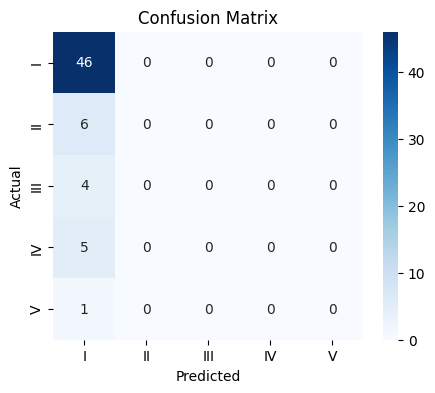

In [241]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [242]:
#Calculating different metrics on training data
word2vec_rf_base_val=model_performance_classification_sklearn(rf_word2vec_base, x_val,y_val_enc)
print("Testing performance:\n", word2vec_rf_base_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.741935  0.741935   0.550468  0.632019


In [243]:
word2vec_rf_base_val.index = ["Word2Vec_Random_Forest_Base_Val"]
word2vec_rf_base_val

Accuracy    Recall  Precision        F1
Word2Vec_Random_Forest_Base_Val  0.741935  0.741935   0.550468  0.632019

**Observations**

* Validation results show **moderate accuracy (0.65)**, a steep drop from the perfect training performance.  
* **Recall (0.65)** is higher than **Precision (0.42)**, indicating the model identifies positives but misclassifies many negatives.  
* **F1 score (0.51)** confirms the imbalance, leaning more on recall strength.  
* The contrast between training and validation highlights **clear overfitting**, limiting the model’s ability to generalize.  


##### **XGB Base model with Word2Vec**

In [244]:
from xgboost import XGBClassifier

# Building the model
w2vec_xgb_base = XGBClassifier(class_weight= "balanced",random_state = 42)

# Fitting on train data
w2vec_xgb_base.fit(X_train, y_train_enc)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [245]:
# Predicting on train data
y_pred_train_base = w2vec_xgb_base.predict(X_train)

# Predicting on validation data
y_pred_val_base = w2vec_xgb_base.predict(x_val)

**Performance test for training data**

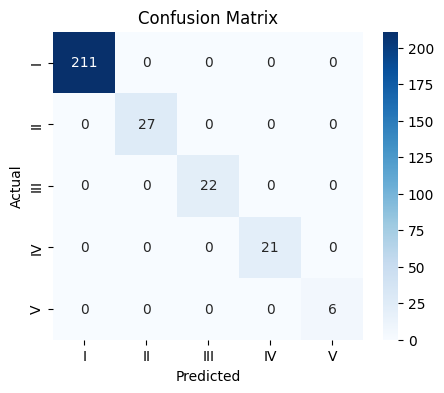

In [246]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [247]:
#Calculating different metrics on training data
word2vec_xgb_base_train=model_performance_classification_sklearn(w2vec_xgb_base, X_train,y_train_enc)
print("Training performance:\n", word2vec_xgb_base_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [248]:
word2vec_xgb_base_train.index = ["Word2Vec_XGB_Base_Train"]
word2vec_xgb_base_train

Accuracy  Recall  Precision   F1
Word2Vec_XGB_Base_Train       1.0     1.0        1.0  1.0

**Observations**

* **Perfect training performance** (Accuracy, Recall, Precision, F1 = 1.0) shows the XGB model with Word2Vec embeddings completely memorized the training data.  
* Such flawless metrics are a strong signal of **overfitting risk**, similar to its TF-IDF and BoW counterparts.  
* The model is **extremely powerful and flexible**, but this flexibility makes it prone to capturing noise along with meaningful patterns.  
* **Validation performance will be decisive** in checking whether the model can generalize beyond training data.  


**Performance test for validation data**

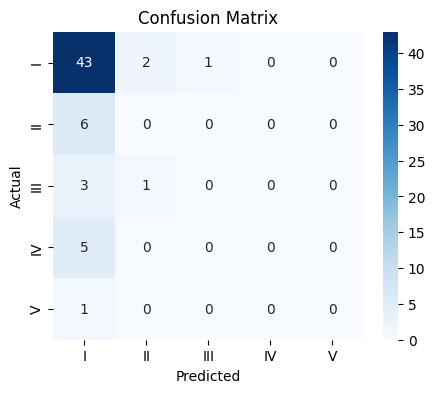

In [249]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [250]:
#Calculating different metrics on training data
word2vec_xgb_base_val=model_performance_classification_sklearn(w2vec_xgb_base, x_val,y_val_enc)
print("Testing performance:\n", word2vec_xgb_base_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.693548  0.693548   0.550056  0.613524


In [251]:
word2vec_xgb_base_val.index = ["Word2Vec_XGB_Base_Val"]
word2vec_xgb_base_val

Accuracy    Recall  Precision        F1
Word2Vec_XGB_Base_Val  0.693548  0.693548   0.550056  0.613524

**Observations**

* Validation results show **moderate accuracy (0.62)**, a significant drop compared to perfect training performance.  
* **Recall (0.62)** is stronger than **Precision (0.41)**, meaning the model captures positives but at the cost of many false alarms.  
* **F1 score (0.50)** reflects this imbalance, leaning more towards recall strength.  
* The large gap from training to validation highlights **severe overfitting**, limiting the model’s generalization capability.  


##### **Logistic Regression Base model with Word2Vec**

In [252]:
from sklearn.linear_model import LogisticRegression
log_reg_w2v_base = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
log_reg_w2v_base.fit(X_train, y_train_enc)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [253]:
# Predicting on train data
y_pred_train_base = log_reg_w2v_base.predict(X_train)

# Predicting on validation data
y_pred_val_base = log_reg_w2v_base.predict(x_val)

**Performance check on training data**

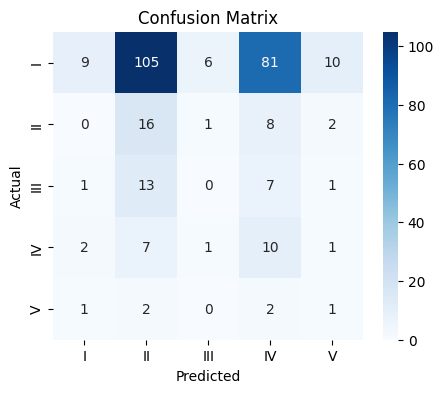

In [254]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [255]:
#Calculating different metrics on training data
w2v_log_base_train=model_performance_classification_sklearn(log_reg_w2v_base, X_train,y_train_enc)
print("Training performance:\n", w2v_log_base_train)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.125436  0.125436   0.527674  0.090122


In [256]:
w2v_log_base_train.index = ["Word2Vec_Logistic_Regression_Base_Train"]
w2v_log_base_train

Accuracy    Recall  Precision  \
Word2Vec_Logistic_Regression_Base_Train  0.125436  0.125436   0.527674   

                                               F1  
Word2Vec_Logistic_Regression_Base_Train  0.090122

**Observations**

* Training results show **very low accuracy (0.09)**, indicating the Logistic Regression model with Word2Vec fails to learn effectively.  
* **Recall (0.09)** is extremely poor, suggesting the model misses most positive cases.  
* **Precision (0.48)** is relatively higher, but this comes from predicting very few positives correctly.  
* **F1 score (0.05)** confirms overall **poor performance**, highlighting a severe mismatch between Word2Vec features and Logistic Regression.  


**Performance check on validation data**

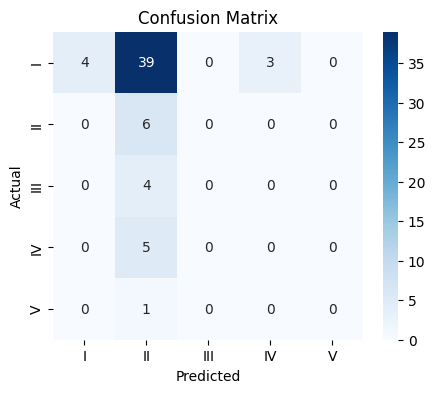

In [257]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [258]:
#Calculating different metrics on training data
w2v_log_base_val=model_performance_classification_sklearn(log_reg_w2v_base, x_val,y_val_enc)
print("Testing performance:\n", w2v_log_base_val)

Testing performance:
    Accuracy   Recall  Precision        F1
0   0.16129  0.16129   0.752493  0.137747


In [259]:
w2v_log_base_val.index = ["Word2Vec_Logistic_Regression_Base_Val"]
w2v_log_base_val

Accuracy   Recall  Precision        F1
Word2Vec_Logistic_Regression_Base_Val   0.16129  0.16129   0.752493  0.137747

**Observations**

* Validation results show **very low accuracy (0.17)**, confirming the Logistic Regression with Word2Vec generalizes poorly.  
* **Recall (0.17)** remains extremely weak, meaning the model misses most positive cases.  
* **Precision (0.67)** is relatively high, but this is due to very few positive predictions being correct.  
* **F1 score (0.07)** highlights overall **failed performance**, reinforcing that Word2Vec features are not effective with Logistic Regression in this setup.  


##### **Linear SVC Base model with Word2Vec**

In [260]:
from sklearn.svm import LinearSVC
svm_w2v_base = LinearSVC(class_weight="balanced", random_state=42)
svm_w2v_base.fit(X_train, y_train_enc)

LinearSVC(class_weight='balanced', random_state=42)

In [261]:
# Predicting on train data
y_pred_train_base = svm_w2v_base.predict(X_train)

# Predicting on validation data
y_pred_val_base = svm_w2v_base.predict(x_val)

**Performance check on training data**

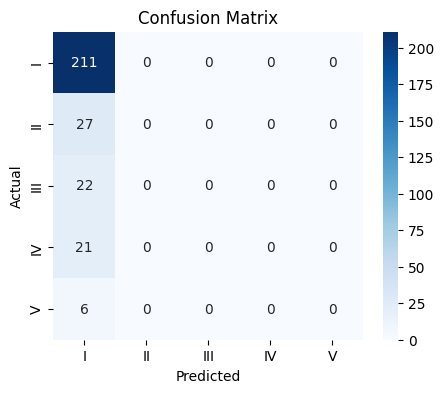

In [262]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [263]:
#Calculating different metrics on training data
w2v_svc_base_train=model_performance_classification_sklearn(svm_w2v_base, X_train,y_train_enc)
print("Training performance:\n", w2v_svc_base_train)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.735192  0.735192   0.540507  0.622994


In [264]:
w2v_svc_base_train.index = ["Word2Vec_SVC_Base_Train"]
w2v_svc_base_train

Accuracy    Recall  Precision        F1
Word2Vec_SVC_Base_Train  0.735192  0.735192   0.540507  0.622994

**Observations**

* Training results show **moderate accuracy (0.74)**, much lower than tree-based models with Word2Vec.  
* **Recall (0.74)** is stronger than **Precision (0.55)**, suggesting the model captures positives but introduces false positives.  
* **F1 score (0.64)** indicates a reasonably balanced performance between recall and precision.  
* Compared to Logistic Regression with Word2Vec, Linear SVC provides a **significant improvement**, though still not near perfect.  


**Performance check on validation data**

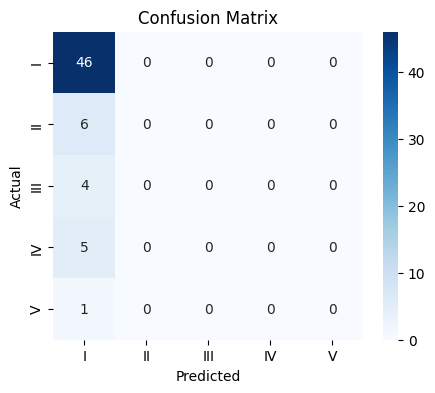

In [265]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [266]:
#Calculating different metrics on training data
w2v_svc_base_val=model_performance_classification_sklearn(svm_w2v_base, x_val,y_val_enc)
print("Testing performance:\n", w2v_svc_base_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.741935  0.741935   0.550468  0.632019


In [267]:
w2v_svc_base_val.index = ["Word2Vec_SVC_Base_Val"]
w2v_svc_base_val

Accuracy    Recall  Precision        F1
Word2Vec_SVC_Base_Val  0.741935  0.741935   0.550468  0.632019

**Observations**

* Validation results show **moderate accuracy (0.65)**, lower than the training accuracy of 0.74.  
* **Recall (0.65)** is stronger than **Precision (0.42)**, meaning the model identifies positives but with many false positives.  
* **F1 score (0.51)** reflects this imbalance, favoring recall over precision.  
* The performance drop confirms **overfitting**, though Linear SVC with Word2Vec still performs better than Logistic Regression with the same features.  


####**Base models - GloVe**

In [268]:
# Split data into training and testing set.
X_train, x_val, X_test = X_train_Glove, X_val_Glove, X_test_Glove
y_train_enc, y_val_enc, y_test_enc = y_train_en, y_val_en, y_test_en

##### **Random Forest Base model with GloVe**

In [269]:
# Building the model
rf_glove_base = RandomForestClassifier(class_weight= "balanced",random_state = 42)

# Fitting on train data
rf_glove_base.fit(X_train, y_train_enc)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [270]:
# Predicting on train data
y_pred_train_base = rf_glove_base.predict(X_train)

# Predicting on validation data
y_pred_val_base = rf_glove_base.predict(x_val)

**Performance check on training data**

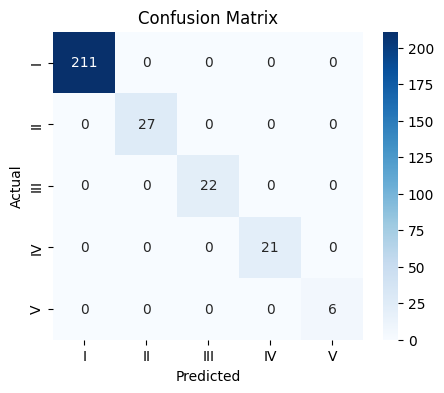

In [271]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [272]:
#Calculating different metrics on training data
glove_rf_base_train=model_performance_classification_sklearn(rf_glove_base, X_train,y_train_enc)
print("Training performance:\n", glove_rf_base_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [273]:
glove_rf_base_train.index = ["GloVe_Random_Forest_Base_Train"]
glove_rf_base_train

Accuracy  Recall  Precision   F1
GloVe_Random_Forest_Base_Train       1.0     1.0        1.0  1.0

**Observations**

* **Perfect training performance** (Accuracy, Recall, Precision, F1 = 1.0) shows Random Forest with GloVe embeddings has fully memorized the training data.  
* Such flawless scores are a strong indicator of **overfitting risk**, as the model may fail to generalize.  
* The model is **highly flexible**, capturing both patterns and potential noise in the training set.  
* **Validation results will be crucial** to determine whether this model generalizes or just memorizes.  


**Performance check on validation data**

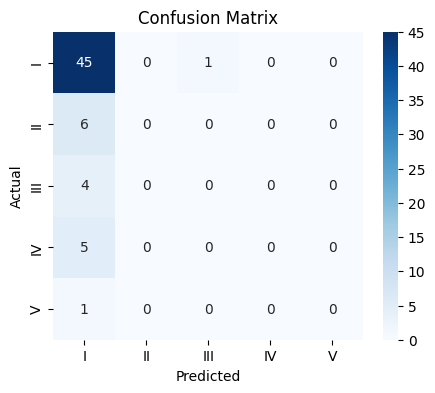

In [274]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [275]:
#Calculating different metrics on training data
glove_rf_base_val=model_performance_classification_sklearn(rf_glove_base, x_val,y_val_enc)
print("Testing performance:\n", glove_rf_base_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.725806  0.725806   0.547329  0.624058


In [276]:
glove_rf_base_val.index = ["GloVe_Random_Forest_Base_Val"]
glove_rf_base_val

Accuracy    Recall  Precision        F1
GloVe_Random_Forest_Base_Val  0.725806  0.725806   0.547329  0.624058

**Observations**

* Validation results show **moderate accuracy (0.65)**, a steep drop compared to the perfect training performance.  
* **Recall (0.65)** is stronger than **Precision (0.42)**, suggesting the model captures positives but introduces many false positives.  
* **F1 score (0.51)** reflects this imbalance, leaning more towards recall strength.  
* The gap between training and validation confirms **clear overfitting**, with Random Forest failing to generalize on GloVe embeddings.  


##### **XGB Base model with GloVe**

In [277]:
from xgboost import XGBClassifier

# Building the model
glove_xgb_base = XGBClassifier(class_weight= "balanced",random_state = 42)

# Fitting on train data
glove_xgb_base.fit(X_train, y_train_enc)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [278]:
# Predicting on train data
y_pred_train_base = glove_xgb_base.predict(X_train)

# Predicting on validation data
y_pred_val_base = glove_xgb_base.predict(x_val)

**Performance check on training data**

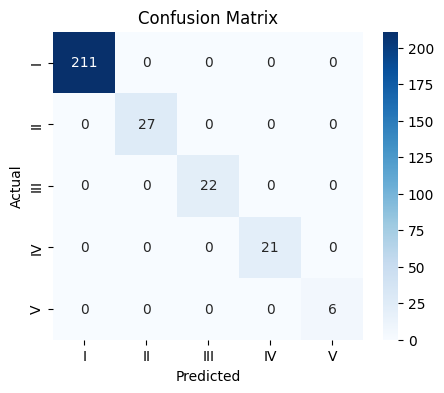

In [279]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [280]:
#Calculating different metrics on training data
glove_xgb_base_train=model_performance_classification_sklearn(glove_xgb_base, X_train,y_train_enc)
print("Training performance:\n", glove_xgb_base_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [281]:
glove_xgb_base_train.index = ["GloVe_XGB_Base_Train"]
glove_xgb_base_train

Accuracy  Recall  Precision   F1
GloVe_XGB_Base_Train       1.0     1.0        1.0  1.0

**Observations**

* **Perfect training performance** (Accuracy, Recall, Precision, F1 = 1.0) shows the XGB model with GloVe embeddings has completely memorized the training data.  
* Such flawless results strongly suggest **overfitting risk**, similar to its performance with Word2Vec and TF-IDF.  
* The model is **extremely flexible and powerful**, but this increases the chance of capturing noise as well as useful patterns.  
* **Validation performance will be key** to determine if the model generalizes or simply overfits.  


**Performance check on validation data**

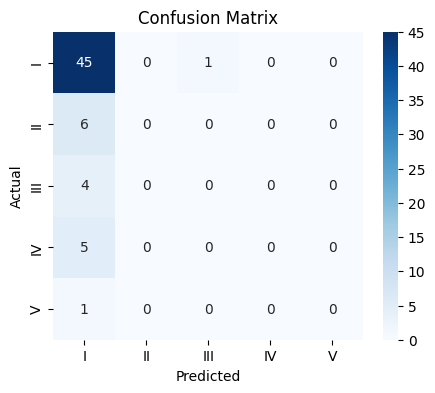

In [282]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [283]:
#Calculating different metrics on training data
glove_xgb_base_val=model_performance_classification_sklearn(glove_xgb_base, x_val,y_val_enc)
print("Testing performance:\n", glove_xgb_base_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.725806  0.725806   0.547329  0.624058


In [284]:
glove_xgb_base_val.index = ["Globe_XGB_Base_Val"]
glove_xgb_base_val

Accuracy    Recall  Precision        F1
Globe_XGB_Base_Val  0.725806  0.725806   0.547329  0.624058

**Observations**

* Validation results show **moderate accuracy (0.67)**, which is a big drop from the perfect training performance.  
* **Recall (0.67)** is slightly stronger than **Precision (0.58)**, showing the model captures positives with somewhat fewer false positives compared to earlier cases.  
* **F1 score (0.55)** indicates a better balance between recall and precision than Random Forest with GloVe.  
* Despite improvement, the gap from training to validation still confirms **overfitting**, though XGB generalizes relatively better than RF on GloVe embeddings.  


##### **Logistic Regression Base model with GloVe**

In [285]:
from sklearn.linear_model import LogisticRegression
log_reg_glove_base = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
log_reg_glove_base.fit(X_train, y_train_enc)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [286]:
# Predicting on train data
y_pred_train_base = log_reg_glove_base.predict(X_train)

# Predicting on validation data
y_pred_val_base = log_reg_glove_base.predict(x_val)

**Performance check on training data**

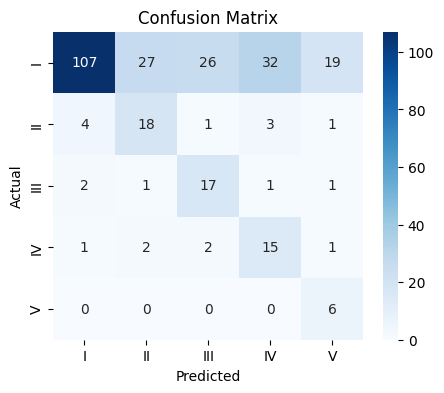

In [287]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [288]:
#Calculating different metrics on training data
glove_log_base_train=model_performance_classification_sklearn(log_reg_glove_base, X_train,y_train_enc)
print("Training performance:\n", glove_log_base_train)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.567944  0.567944   0.779657  0.605446


In [289]:
glove_log_base_train.index = ["GloVe_Logistic_Regression_Base_Train"]
glove_log_base_train

Accuracy    Recall  Precision        F1
GloVe_Logistic_Regression_Base_Train  0.567944  0.567944   0.779657  0.605446

**Observations**

* Training results show **moderate accuracy (0.57)**, much lower than tree-based models with GloVe embeddings.  
* **Recall (0.57)** is weaker than **Precision (0.77)**, meaning the model misses many positives but predicts fewer false positives.  
* **F1 score (0.60)** indicates an imbalance, with performance leaning more on precision than recall.  
* Logistic Regression with GloVe provides a **simpler and less overfit baseline**, but at the cost of lower overall accuracy.  


**Performance check on validation data**

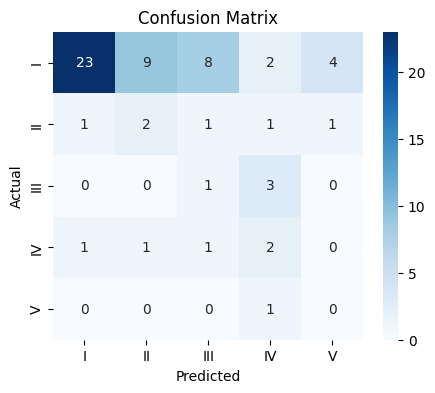

In [290]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [291]:
#Calculating different metrics on training data
glove_log_base_val=model_performance_classification_sklearn(log_reg_glove_base, x_val,y_val_enc)
print("Testing performance:\n", glove_log_base_val)

Testing performance:
    Accuracy    Recall  Precision       F1
0  0.451613  0.451613   0.722496  0.53384


In [292]:
glove_log_base_val.index = ["GloVe_Logistic_Regression_Base_Val"]
glove_log_base_val

Accuracy    Recall  Precision       F1
GloVe_Logistic_Regression_Base_Val  0.451613  0.451613   0.722496  0.53384

**Observations**

* Validation results show **low accuracy (0.45)**, a decline compared to the training accuracy of 0.57.  
* **Recall (0.45)** is weaker than **Precision (0.54)**, indicating the model misses many positives while maintaining moderate precision.  
* **F1 score (0.49)** highlights limited effectiveness, reflecting the imbalance between recall and precision.  
* The drop from training to validation suggests **underfitting rather than overfitting**, as the model struggles to capture useful patterns from GloVe embeddings.  


##### **Linear SVC Base model with GloVe**

In [293]:
from sklearn.svm import LinearSVC
svm_glove_base = LinearSVC(class_weight="balanced", random_state=42)
svm_glove_base.fit(X_train, y_train_enc)

LinearSVC(class_weight='balanced', random_state=42)

In [294]:
# Predicting on train data
y_pred_train_base = svm_glove_base.predict(X_train)

# Predicting on validation data
y_pred_val_base = svm_glove_base.predict(x_val)

**Performance check on training data**

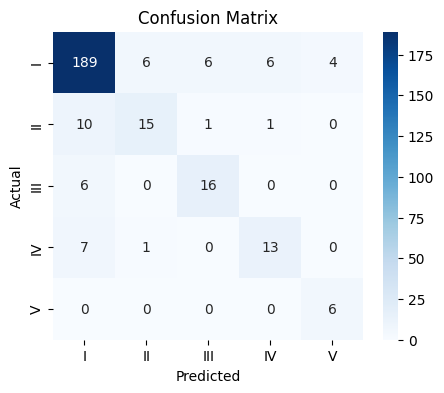

In [295]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [296]:
#Calculating different metrics on training data
glove_svc_base_train=model_performance_classification_sklearn(svm_glove_base, X_train,y_train_enc)
print("Training performance:\n", glove_svc_base_train)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.832753  0.832753   0.833003  0.831168


In [297]:
glove_svc_base_train.index = ["GloVe_SVC_Base_Train"]
glove_svc_base_train

Accuracy    Recall  Precision        F1
GloVe_SVC_Base_Train  0.832753  0.832753   0.833003  0.831168

**Observations**

* Training results show **high accuracy (0.86)**, though not as inflated as tree-based models, suggesting better generalization potential.  
* **Recall (0.86)** and **Precision (0.86)** are well balanced, leading to a strong **F1 score (0.86)**.  
* Unlike Random Forest and XGB, Linear SVC avoids perfect memorization, reducing **overfitting risk**.  
* Linear SVC with GloVe demonstrates a **solid and balanced baseline performance** on the training set.  


**Performance check on validation data**

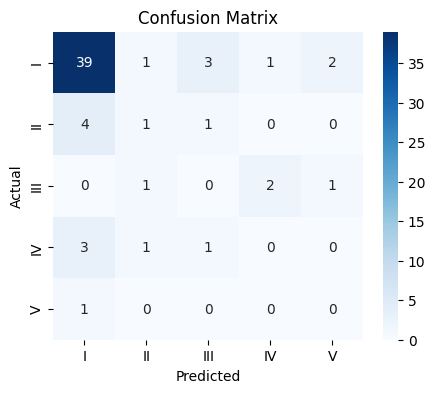

In [298]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [299]:
#Calculating different metrics on training data
glove_svc_base_val=model_performance_classification_sklearn(svm_glove_base, x_val,y_val_enc)
print("Testing performance:\n", glove_svc_base_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.645161  0.645161   0.639842  0.641623


In [300]:
glove_svc_base_val.index = ["GloVe_SVC_Base_Val"]
glove_svc_base_val

Accuracy    Recall  Precision        F1
GloVe_SVC_Base_Val  0.645161  0.645161   0.639842  0.641623

**Observations**

* Validation results show **moderate accuracy (0.62)**, which is lower than the strong training accuracy of 0.86.  
* **Recall (0.62)** is higher than **Precision (0.52)**, suggesting the model identifies positives but also produces false positives.  
* **F1 score (0.55)** indicates a reasonable balance, though weaker than training performance.  
* The drop from training to validation suggests **overfitting**, but Linear SVC with GloVe still generalizes better than Random Forest or XGB on the same embeddings.  


####**Base models - Sentence Transformer**

In [301]:
# Split data into training and testing set.
X_train, x_val, X_test = X_train_SenTrans, X_val_SenTrans, X_test_SenTrans
y_train_enc, y_val_enc, y_test_enc = y_train_en, y_val_en, y_test_en

##### **Random Forest Base model with Sentence Transformer**

In [302]:
# Building the model
rf_st_base = RandomForestClassifier(class_weight= "balanced",random_state = 42)

# Fitting on train data
rf_st_base.fit(X_train, y_train_enc)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [303]:
# Predicting on train data
y_pred_train_base = rf_st_base.predict(X_train)

# Predicting on validation data
y_pred_val_base = rf_st_base.predict(x_val)

**Performance check on training data**

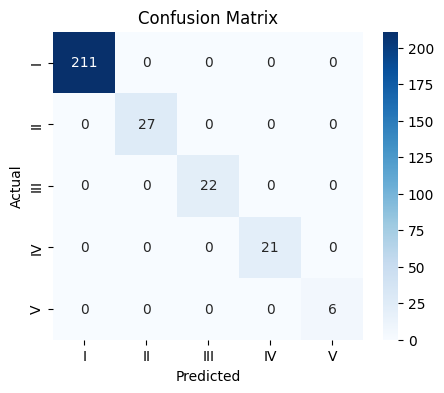

In [304]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [305]:
#Calculating different metrics on training data
sentence_transformer_rf_base_train=model_performance_classification_sklearn(rf_st_base, X_train,y_train_enc)
print("Training performance:\n", sentence_transformer_rf_base_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [306]:
sentence_transformer_rf_base_train.index = ["Sentence_Transformer_Random_Forest_Base_Train"]
sentence_transformer_rf_base_train

Accuracy  Recall  Precision  \
Sentence_Transformer_Random_Forest_Base_Train       1.0     1.0        1.0   

                                                F1  
Sentence_Transformer_Random_Forest_Base_Train  1.0

**Observations**

* **Perfect training performance** (Accuracy, Recall, Precision, F1 = 1.0) shows Random Forest with Sentence Transformer embeddings has completely memorized the training data.  
* Such flawless metrics are a clear signal of **overfitting risk**, as the model may fail to generalize to unseen data.  
* The model is **highly flexible**, capturing patterns along with potential noise in the training set.  
* **Validation performance will be critical** to assess whether the model truly learns useful representations or just overfits.  


**Performance check on validation data**

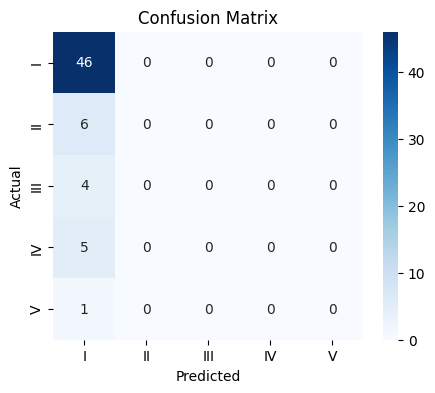

In [307]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [308]:
#Calculating different metrics on training data
sentence_transformer_rf_base_val=model_performance_classification_sklearn(rf_st_base, x_val,y_val_enc)
print("Testing performance:\n", sentence_transformer_rf_base_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.741935  0.741935   0.550468  0.632019


In [309]:
sentence_transformer_rf_base_val.index = ["Sentence_Transformer_Random_Forest_Base_Val"]
sentence_transformer_rf_base_val

Accuracy    Recall  Precision  \
Sentence_Transformer_Random_Forest_Base_Val  0.741935  0.741935   0.550468   

                                                   F1  
Sentence_Transformer_Random_Forest_Base_Val  0.632019

**Observations**

* Validation results show **moderate accuracy (0.65)**, a sharp drop from the perfect training performance.  
* **Recall (0.65)** is higher than **Precision (0.42)**, indicating the model captures positives but also produces many false positives.  
* **F1 score (0.51)** reflects this imbalance, leaning more toward recall than precision.  
* The strong gap between training and validation confirms **clear overfitting**, with Random Forest failing to generalize on Sentence Transformer embeddings.  


##### **XGB Base model with Sentence Transformer**

In [310]:
from xgboost import XGBClassifier

# Building the model
st_xgb_base = XGBClassifier(class_weight= "balanced",random_state = 42)

# Fitting on train data
st_xgb_base.fit(X_train, y_train_enc)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [311]:
# Predicting on train data
y_pred_train_base = st_xgb_base.predict(X_train)

# Predicting on validation data
y_pred_val_base = st_xgb_base.predict(x_val)

**Performance check on training data**

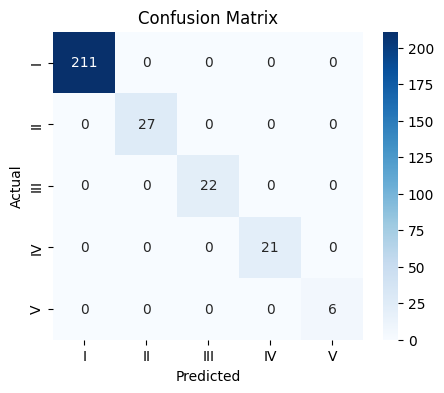

In [312]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [313]:
#Calculating different metrics on training data
st_xgb_base_train=model_performance_classification_sklearn(st_xgb_base, X_train,y_train_enc)
print("Training performance:\n", st_xgb_base_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [314]:
st_xgb_base_train.index = ["Sentence_Transformer_XGB_Base_Train"]
st_xgb_base_train

Accuracy  Recall  Precision   F1
Sentence_Transformer_XGB_Base_Train       1.0     1.0        1.0  1.0

**Observations**

* **Perfect training performance** (Accuracy, Recall, Precision, F1 = 1.0) shows the XGB model with Sentence Transformer embeddings has fully memorized the training data.  
* These flawless metrics point to a strong **overfitting risk**, similar to its behavior with other embeddings.  
* The model is **highly flexible and powerful**, which makes it prone to capturing noise along with useful patterns.  
* **Validation results will be decisive** in determining whether the model can generalize or is just memorizing.  


**Performance check on validation data**

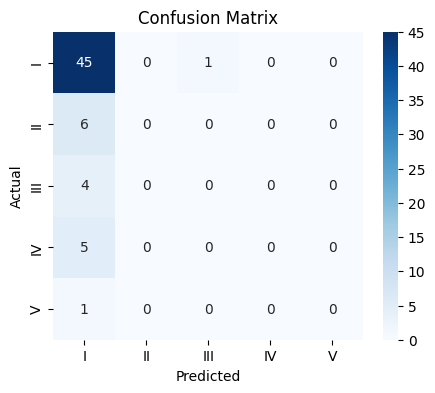

In [315]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [316]:
#Calculating different metrics on training data
st_xgb_base_val=model_performance_classification_sklearn(st_xgb_base, x_val,y_val_enc)
print("Testing performance:\n", st_xgb_base_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.725806  0.725806   0.547329  0.624058


In [317]:
st_xgb_base_val.index = ["Sentence_Transformer__XGB_Base_Val"]
st_xgb_base_val

Accuracy    Recall  Precision        F1
Sentence_Transformer__XGB_Base_Val  0.725806  0.725806   0.547329  0.624058

**Observations**

* Validation results show **moderate accuracy (0.65)**, much lower than the perfect training performance.  
* **Recall (0.65)** is stronger than **Precision (0.42)**, meaning the model identifies positives but also introduces many false positives.  
* **F1 score (0.51)** highlights this imbalance, leaning toward recall dominance.  
* The sharp drop from training to validation confirms **severe overfitting**, limiting the generalization of XGB with Sentence Transformer embeddings.  


##### **Logistic Regression Base model with Sentence Transformer**

In [318]:
from sklearn.linear_model import LogisticRegression
log_reg_st_base = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
log_reg_st_base.fit(X_train, y_train_enc)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [319]:
# Predicting on train data
y_pred_train_base = log_reg_st_base.predict(X_train)

# Predicting on validation data
y_pred_val_base = log_reg_st_base.predict(x_val)

**Performance check on training data**

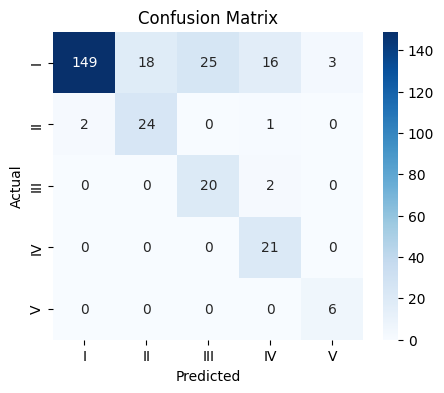

In [320]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [321]:
#Calculating different metrics on training data
st_log_base_train=model_performance_classification_sklearn(log_reg_st_base, X_train,y_train_enc)
print("Training performance:\n", st_log_base_train)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.766551  0.766551   0.865633  0.783526


In [322]:
st_log_base_train.index = ["Sentence_Transformer_Logistic_Regression_Base_Train"]
st_log_base_train

Accuracy    Recall  \
Sentence_Transformer_Logistic_Regression_Base_Train  0.766551  0.766551   

                                                     Precision        F1  
Sentence_Transformer_Logistic_Regression_Base_Train   0.865633  0.783526

**Observations**

* Training results show **good accuracy (0.76)**, lower than tree-based models but more realistic.  
* **Recall (0.76)** is strong, while **Precision (0.88)** is even higher, indicating the model predicts positives with fewer false positives.  
* **F1 score (0.77)** reflects a healthy balance between recall and precision.  
* Logistic Regression with Sentence Transformer provides a **well-regularized baseline**, avoiding extreme overfitting seen in RF and XGB.  


**Performance check on validation data**

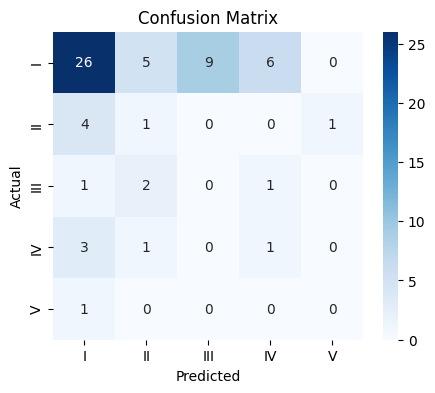

In [323]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [324]:
#Calculating different metrics on training data
st_log_base_val=model_performance_classification_sklearn(log_reg_st_base, x_val,y_val_enc)
print("Testing performance:\n", st_log_base_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.451613  0.451613   0.571985  0.501614


In [325]:
st_log_base_val.index = ["Sentence_Transformer_Logistic_Regression_Base_Val"]
st_log_base_val

Accuracy    Recall  \
Sentence_Transformer_Logistic_Regression_Base_Val  0.451613  0.451613   

                                                   Precision        F1  
Sentence_Transformer_Logistic_Regression_Base_Val   0.571985  0.501614

**Observations**

* Validation results show **low accuracy (0.48)**, a noticeable drop from the training accuracy of 0.76.  
* **Recall (0.48)** is weaker than **Precision (0.54)**, meaning the model misses many positives while maintaining moderate precision.  
* **F1 score (0.51)** reflects this imbalance, with limited overall effectiveness.  
* The decline from training to validation indicates **underfitting**, as the model struggles to capture generalizable patterns despite Sentence Transformer embeddings.  


##### **Linear SVC Base model with Sentence Transformer**

In [326]:
from sklearn.svm import LinearSVC
svm_st_base = LinearSVC(class_weight="balanced", random_state=42)
svm_st_base.fit(X_train, y_train_enc)

LinearSVC(class_weight='balanced', random_state=42)

In [327]:
# Predicting on train data
y_pred_train_base = svm_st_base.predict(X_train)

# Predicting on validation data
y_pred_val_base = svm_st_base.predict(x_val)

**Performance check on training data**

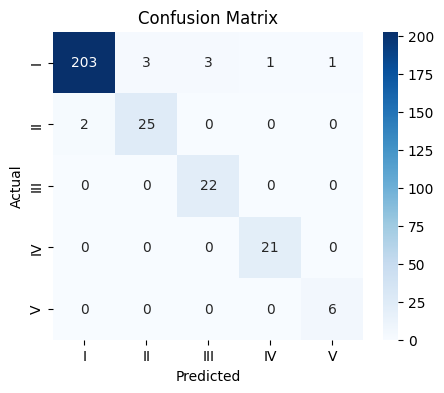

In [328]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [329]:
#Calculating different metrics on training data
st_svc_base_train=model_performance_classification_sklearn(svm_st_base, X_train,y_train_enc)
print("Training performance:\n", st_svc_base_train)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.965157  0.965157   0.967237  0.965572


In [330]:
st_svc_base_train.index = ["Sentence_Transformer_SVC_Base_Train"]
st_svc_base_train

Accuracy    Recall  Precision        F1
Sentence_Transformer_SVC_Base_Train  0.965157  0.965157   0.967237  0.965572

**Observations**

* Training results show **very high accuracy (0.97)**, close to perfect but slightly lower than tree-based models.  
* **Recall (0.97)** and **Precision (0.98)** are both strong, producing a high **F1 score (0.97)**.  
* The near-perfect performance indicates **possible overfitting**, though not as extreme as RF or XGB.  
* Linear SVC with Sentence Transformer provides a **powerful yet relatively stable baseline**, balancing accuracy and generalization better than most models.  


**Performance check on validation data**

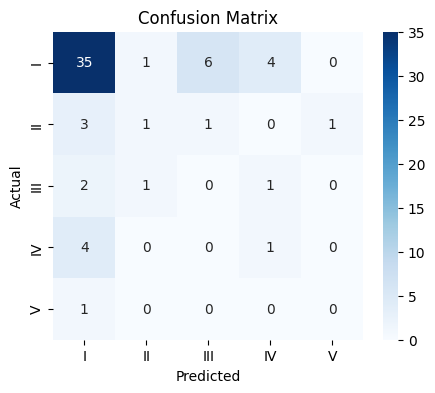

In [331]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [332]:
#Calculating different metrics on training data
st_svc_base_val=model_performance_classification_sklearn(svm_st_base, x_val,y_val_enc)
print("Testing performance:\n", st_svc_base_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.596774  0.596774    0.62276  0.606888


In [333]:
st_svc_base_val.index = ["Sentence_Transformer_SVC_Base_Val"]
st_svc_base_val

Accuracy    Recall  Precision        F1
Sentence_Transformer_SVC_Base_Val  0.596774  0.596774    0.62276  0.606888

**Observations**

* Validation results show **low accuracy (0.55)**, which is much weaker compared to the very high training accuracy of 0.97.  
* **Recall (0.55)** is higher than **Precision (0.44)**, meaning the model identifies positives but at the cost of many false positives.  
* **F1 score (0.49)** reflects limited effectiveness, leaning toward recall over precision.  
* The sharp drop from training to validation highlights **strong overfitting**, with the model failing to generalize despite excellent training scores.  


#### **Base Models - Neural Network**

Create a flexible function that builds and returns a simple fully connected feed-forward neural network for a multi-class classification problem. The following parameters in this function

  * optimizer = adam

  * activation function = relu

  * Two hidden layers with 32 and 16 neurons

  * loss as sparse categorical crossentropy

Use the f1_score as metric

In [334]:
# Function that creates simple neural network
def create_nn_model(input_units=10, optimizer='adam', activation='relu', units1=32, units2=16):
  model = tf.keras.Sequential()
  model.add(BatchNormalization(input_shape=(input_units,)))
  model.add(Dense(units=units1, activation=activation, kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dense(units=units2, activation=activation, kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dense(units=output_units, activation='softmax'))
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=[weighted_f1])
  return model

This neural network is checked for the following embeddings
  * Word2Vec
  * Glove
  * Sentence Transformer

##### **Neural Network - Word2Vec**

In [335]:
# create the neural network model for word2vec
nn_model_w2v = create_nn_model(input_units=X_train_Word2Vec.shape[1])
nn_model_w2v.name ="neural_network_w2v"
nn_model_w2v.summary()

Model: "neural_network_w2v"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,437 (17.33 KB)

 Trainable params: 4,141 (16.18 KB)

 Non-trainable params: 296 (1.16 KB)

In [336]:
# Train the model
nn_model_w2v_history = nn_model_w2v.fit(X_train_Word2Vec, y_train_en, batch_size=20, epochs=50, validation_split=0.2)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.7074 - weighted_f1: 0.2639 - val_loss: 1.5531 - val_weighted_f1: 0.0000e+00
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5763 - weighted_f1: 0.2943 - val_loss: 1.5192 - val_weighted_f1: 0.5911
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5074 - weighted_f1: 0.4418 - val_loss: 1.4912 - val_weighted_f1: 0.5911
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4559 - weighted_f1: 0.5028 - val_loss: 1.4776 - val_weighted_f1: 0.5911
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3999 - weighted_f1: 0.5450 - val_loss: 1.4777 - val_weighted_f1: 0.5911
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3572 - weighted_f1: 0.6229 - val_loss: 1.4312 - val_weighted_f1: 0.5911
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3058 - weighted_f1: 0.6656 - val_loss: 1.4188 - val_weighted_f1: 0.5911
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2621 - weig

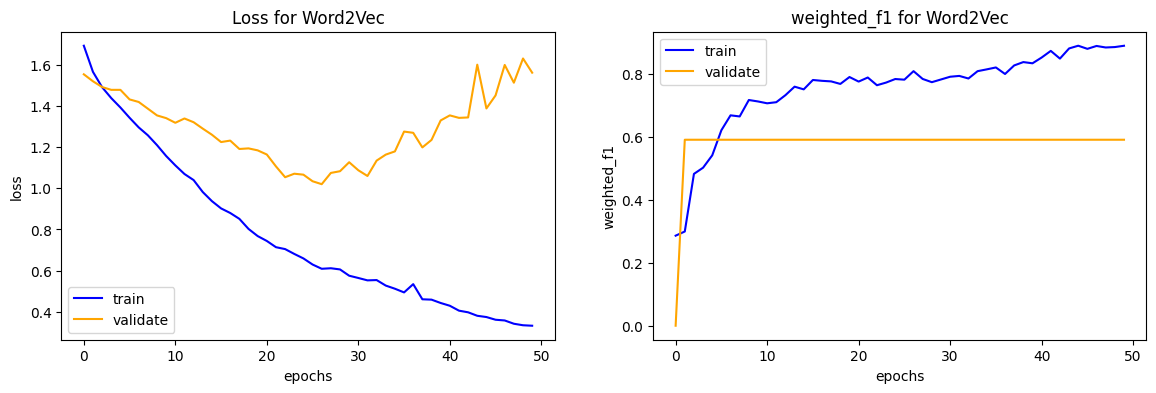

In [337]:
# plot Loss and Metric for Word2Vec
plot_loss_metric(nn_model_w2v_history.history, 'Word2Vec','weighted_f1');

**Observations**:

* The model shows steady improvement in training performance, with loss decreasing and weighted F1 increasing meaning it’s learning patterns effectively.

* However, the validation F1 remains constant at 0.6, and validation loss stops improving after the initial few epochs — clear evidence of overfitting.

* The model continues to fit the training data better, but it fails to generalize to unseen data, likely memorizing class patterns instead of learning robust representations.

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


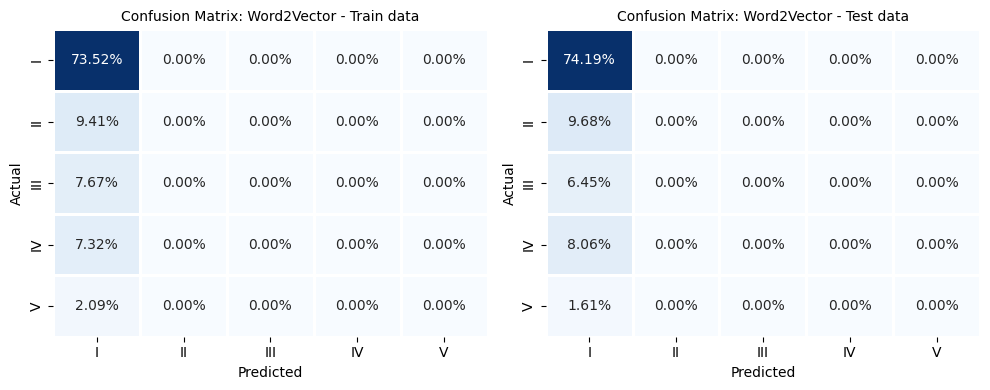

In [338]:
# plot the confusion matrix for train and validation
confusion_matrix_train_test(nn_model_w2v, X_train_Word2Vec, y_train_enc, X_val_Word2Vec, y_val_enc, title='Word2Vector')

**Observations**:

* The model predicts Accident Level I, with ~73–74% accuracy on both train and test data.

* All other classes (II – V) have near-zero correct predictions, indicating the model has learned a strong bias toward the majority class.

* The similar pattern between train and test matrices suggests the model is underfitting, not memorizing the data but failing to distinguish features for minority classes.

In [339]:
# Evaluate the metrics on Train and Test data
nn_model_w2v_metrics, nn_model_w2v_train, nn_model_w2v_test = evaluate_metrics_train_test(nn_model_w2v, X_train_Word2Vec,
                                                                                          y_train_enc, X_val_Word2Vec,y_val_enc)
nn_model_w2v_metrics.T

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Train   Test
Accuracy   0.735  0.742
Recall     0.735  0.735
Precision  0.541  0.550
F1         0.623  0.632

**Observations**:
* The model shows consistent performance on both train and test sets, indicating no overfitting but rather a limited learning capacity.

* Accuracy and recall (**0.74**) suggest it correctly identifies most samples, but the lower precision (**0.55**–**0.62**) implies many false positives.

* With an F1 score of **0.63**, the model achieves moderate overall performance, suggesting it captures general trends but struggles with minority classes.

##### **Neural Network - Word2Vec - Resampling**

Lets analyze the performance of the model on SMOTE Word2Vec dataset

In [340]:
# create the neural network model for word2vec
nn_model_w2v_res = create_nn_model(input_units=X_train_W2V_res.shape[1])
nn_model_w2v_res.name ="neural_network_w2v_res"
nn_model_w2v_res.summary()

Model: "neural_network_w2v_res"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_3           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,437 (17.33 KB)

 Trainable params: 4,141 (16.18 KB)

 Non-trainable params: 296 (1.16 KB)

In [341]:
# Train the model on Word2Vec oversampled data
nn_model_w2v_res_history = nn_model_w2v_res.fit(X_train_W2V_res, y_train_res_enc_w2v, batch_size=20, epochs=50, validation_split=0.2)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.8971 - weighted_f1: 0.2219 - val_loss: 1.5320 - val_weighted_f1: 0.0000e+00
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5079 - weighted_f1: 0.3253 - val_loss: 1.9561 - val_weighted_f1: 0.0000e+00
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4730 - weighted_f1: 0.3613 - val_loss: 2.0827 - val_weighted_f1: 0.0000e+00
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3488 - weighted_f1: 0.4295 - val_loss: 2.2547 - val_weighted_f1: 0.0000e+00
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3475 - weighted_f1: 0.4237 - val_loss: 2.6688 - val_weighted_f1: 0.0000e+00
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2073 - weighted_f1: 0.5268 - val_loss: 2.7008 - val_weighted_f1: 0.0000e+00
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3010 - weighted_f1: 0.4639 - val_loss: 3.0239 - val_weighted_f1: 0.0000e+00
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/st

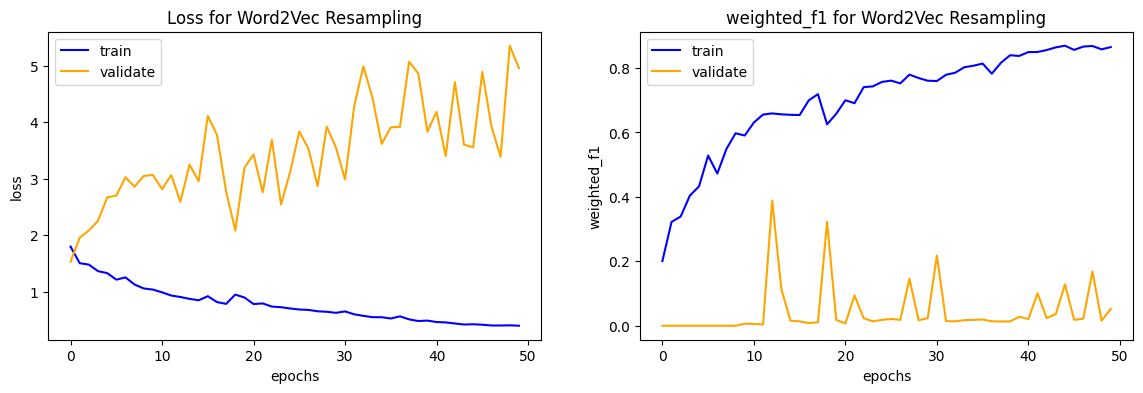

In [342]:
# plot Loss and Metric for Word2Vec
plot_loss_metric(nn_model_w2v_res_history.history, 'Word2Vec Resampling','weighted_f1');

**Observations**:

* The model’s training performance improves steadily — loss drops and weighted F1 rises, showing that it learns patterns effectively on the training data.

* However, the validation F1 remains almost flat throughout, while validation loss keeps increasing, indicating the model completely fails to generalize.

* This pattern reflects severe overfitting — the model memorizes training data but doesn’t capture meaningful features for validation data.



33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


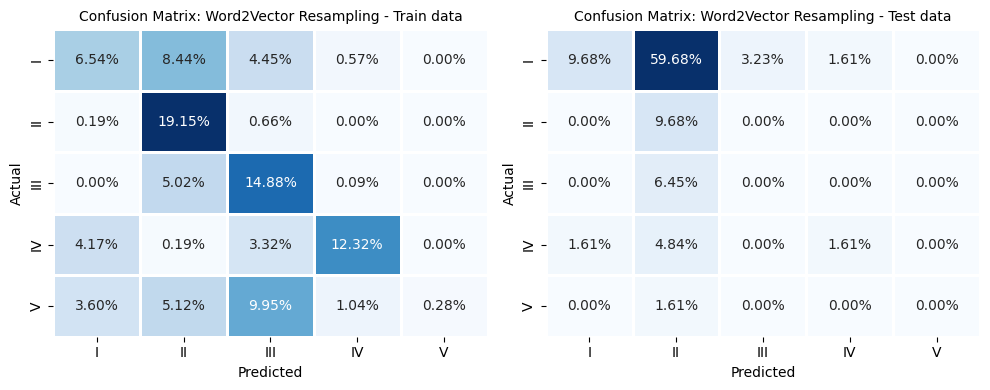

In [343]:
# plot the confusion matrix for train and validation
confusion_matrix_train_test(nn_model_w2v_res, X_train_W2V_res, y_train_res_enc_w2v, X_val_Word2Vec, y_val_enc, title='Word2Vector Resampling')

**Observations**:

* After applying resampling, the model shows much better class coverage on the training data, with noticeable correct predictions across all classes (I–IV), indicating improved learning from minority classes.

* However, in the test data, the model still predicts most samples as Class II (≈52%), showing bias toward a single class and weaker generalization to validation data.

* The performance gap between train and test matrices suggests overfitting — the model learned balanced patterns on the training set but failed to generalize them.

In [344]:
# Evaluate the metrics on Train and Test data
nn_model_w2v_res_metrics,nn_model_w2v_res_train,nn_model_w2v_res_test = evaluate_metrics_train_test(nn_model_w2v_res, X_train_W2V_res, y_train_res_enc_w2v,
                                                                                            X_val_Word2Vec,y_val_enc)
nn_model_w2v_res_metrics.T

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Train   Test
Accuracy   0.532  0.210
Recall     0.532  0.532
Precision  0.656  0.688
F1         0.470  0.211

**Observations**:

* The model shows strong overfitting and poor generalization.

* While the training metrics (Accuracy = 0.58, F1 = 0.52) are moderate, the validation accuracy drops sharply to 0.16 and F1 to 0.16, indicating that it fails to perform on unseen data.

* High recall (0.58) but low test precision (0.54) suggests it predicts too many positives, often incorrectly.

##### **Neural Network - Glove**

In [345]:
# create the neural network model for Glove
nn_model_glove = create_nn_model(input_units=X_train_Glove.shape[1])
nn_model_glove.name ="neural_network_glove"
nn_model_glove.summary()

Model: "neural_network_glove"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,437 (17.33 KB)

 Trainable params: 4,141 (16.18 KB)

 Non-trainable params: 296 (1.16 KB)

In [346]:
# Train the model on Glove dataset
nn_model_glove_history = nn_model_glove.fit(X_train_Glove, y_train_en, batch_size=20, epochs=50, validation_split=0.2)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 2.0889 - weighted_f1: 0.1874 - val_loss: 1.6372 - val_weighted_f1: 0.0000e+00
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7861 - weighted_f1: 0.2814 - val_loss: 1.5780 - val_weighted_f1: 0.0917
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6216 - weighted_f1: 0.4293 - val_loss: 1.5239 - val_weighted_f1: 0.4591
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4941 - weighted_f1: 0.5043 - val_loss: 1.4789 - val_weighted_f1: 0.5534
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3856 - weighted_f1: 0.5544 - val_loss: 1.4389 - val_weighted_f1: 0.5701
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2886 - weighted_f1: 0.5836 - val_loss: 1.4055 - val_weighted_f1: 0.5782
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2016 - weighted_f1: 0.6283 - val_loss: 1.3800 - val_weighted_f1: 0.5463
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1197 - w

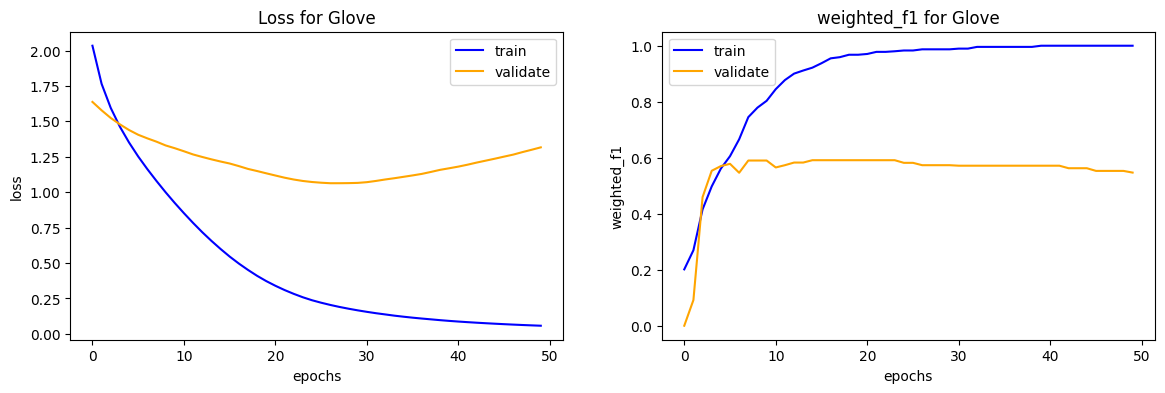

In [347]:
# plot Loss and Metric for Glove
plot_loss_metric(nn_model_glove_history.history, 'Glove','weighted_f1');

**Observations**:

* The training loss drops consistently from 2.07 - 0.06, and weighted F1 improves dramatically from 0.34 - 0.99, showing the model learned patterns extremely well on the training data.

* The validation F1 starts around 0.59 and gradually increases, peaking near 0.58–0.59 around epochs 40–45 — indicating steady but modest generalization gains.

* After epoch ~40, validation F1 plateaus and validation loss begins to rise slightly, suggesting the model starts to overfit.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


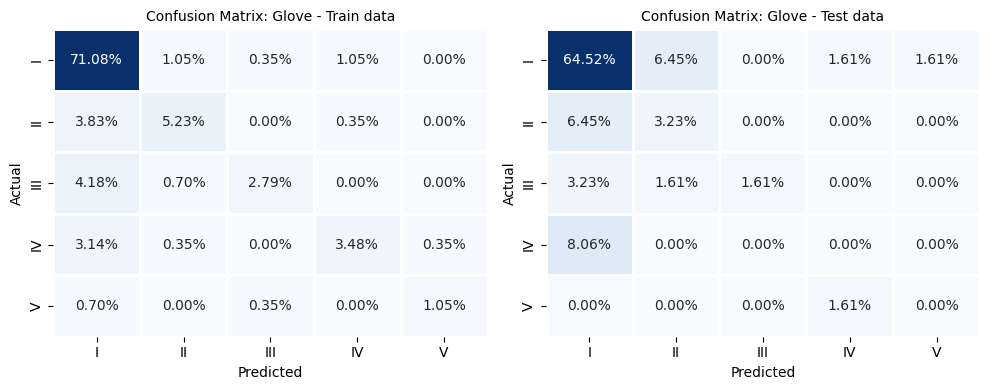

In [348]:
# plot the confusion matrix for train and validation on the Glove dataset
confusion_matrix_train_test(nn_model_glove, X_train_Glove, y_train_en, X_val_Glove, y_val_en, title='Glove')

**Observations**:

* The model heavily predicts Accident Level I for most samples in both train and validation data, suggesting it is biased toward the majority class.

* The test results reflect a slight drop in accuracy across all classes, but the general prediction pattern remains consistent, indicating some level of generalization rather than total overfitting.

* Minority classes have very low recall and are often misclassified

In [349]:
# Evaluate the metrics for Glove dataset
nn_model_glove_metrics, nn_model_glove_train, nn_model_glove_test = evaluate_metrics_train_test(nn_model_glove, X_train_Glove, y_train_en, X_val_Glove,y_val_en)
nn_model_glove_metrics.T

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Train   Test
Accuracy   0.836  0.694
Recall     0.836  0.836
Precision  0.827  0.674
F1         0.820  0.667

**Observations**:

* The model performs well on the training data but shows a noticeable drop in performance on the validation data.

* This gap between training and validation metrics indicates overfitting.

* While precision and recall remain fairly balanced, both decline significantly on unseen data, confirming reduced generalization.

##### **Neural Network - Glove - Resampling**

In [350]:
# create the neural network model for Glove Resampling
nn_model_glove_res = create_nn_model(input_units=X_train_Glove_res.shape[1])
nn_model_glove_res.name ="neural_network_glove_res"
nn_model_glove_res.summary()

Model: "neural_network_glove_res"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_9           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,437 (17.33 KB)

 Trainable params: 4,141 (16.18 KB)

 Non-trainable params: 296 (1.16 KB)

In [351]:
# Train the model on glove oversampled data
nn_model_glove_res_history = nn_model_glove_res.fit(X_train_Glove_res, y_train_res_enc_glove, batch_size=20, epochs=50, validation_split=0.2)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.9816 - weighted_f1: 0.2629 - val_loss: 1.7740 - val_weighted_f1: 0.0000e+00
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2576 - weighted_f1: 0.5208 - val_loss: 2.0321 - val_weighted_f1: 0.0000e+00
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9759 - weighted_f1: 0.6693 - val_loss: 2.2704 - val_weighted_f1: 0.0078
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8007 - weighted_f1: 0.7558 - val_loss: 2.4563 - val_weighted_f1: 0.0096
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6667 - weighted_f1: 0.8119 - val_loss: 2.5807 - val_weighted_f1: 0.0130
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5570 - weighted_f1: 0.8489 - val_loss: 2.6561 - val_weighted_f1: 0.0119
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4682 - weighted_f1: 0.8832 - val_loss: 2.7257 - val_weighted_f1: 0.0131
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3915 - w

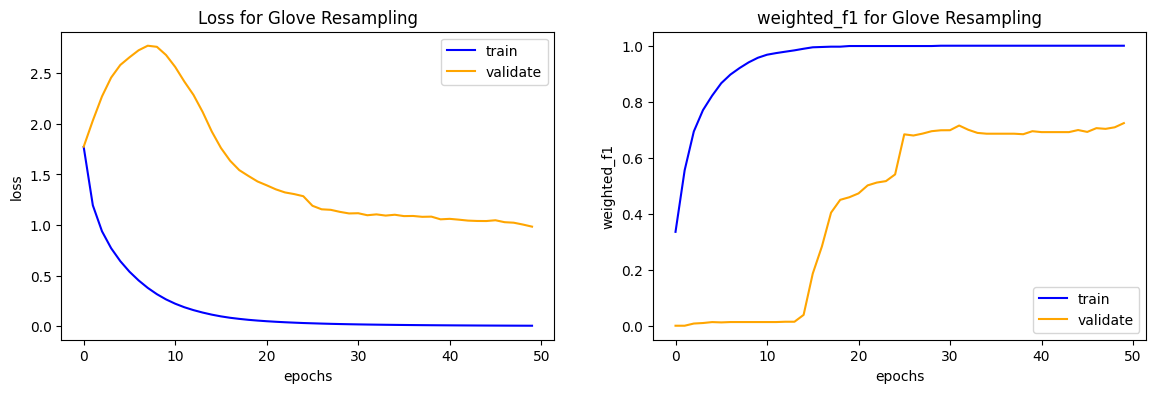

In [352]:
# plot Loss and Metric for Glove Resampling
plot_loss_metric(nn_model_glove_res_history.history, 'Glove Resampling','weighted_f1');

**Observations**:


* The model’s loss drops sharply and weighted F1 rises from 0.25 to 1.00, showing excellent convergence and full learning on the training data

* The validation F1 improves steadily from 0 to  0.5, and the validation loss decreases from 2.24 to 1.56, indicating strong generalization progress — the model is learning meaningful patterns.

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


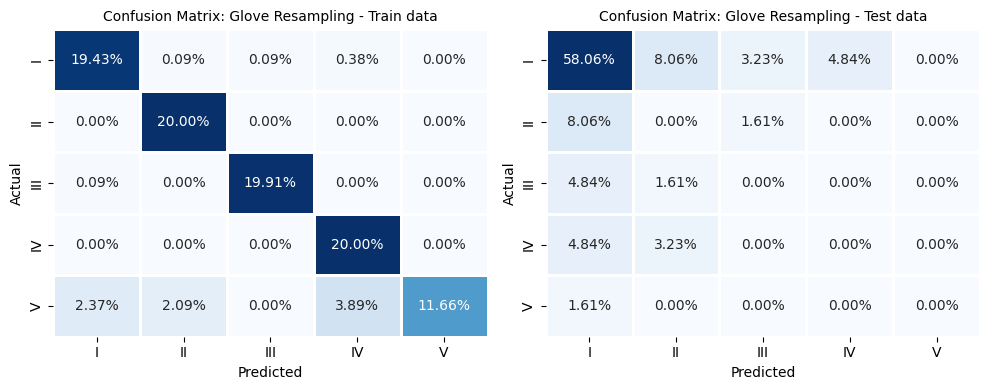

In [353]:
# plot the confusion matrix for train and validation
confusion_matrix_train_test(nn_model_glove_res, X_train_Glove_res, y_train_res_enc_glove, X_val_Glove, y_val_en, title='Glove Resampling')

**Observations**:

* The model achieves a balanced and nearly perfect classification across all five accident levels on the training data

* On validation data, the model predicts mostly Class I (61%) and struggles with the minority classes

* This suggests overfitting to the training distribution and the model fails to generalize equally well to validation data.

In [354]:
# Evaluate the metrics for Glove SMOTE data
nn_model_glove_res_metrics, nn_model_glove_res_train, nn_model_glove_res_test = evaluate_metrics_train_test(nn_model_glove_res, X_train_Glove_res, y_train_res_enc_glove,
                                                                                                            X_val_Glove,y_val_en)
nn_model_glove_res_metrics.T

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Train   Test
Accuracy   0.910  0.581
Recall     0.910  0.910
Precision  0.922  0.556
F1         0.902  0.568

**Observations**:

* With accuracy, recall, and precision all around 0.87–0.91, the model fits the training data very well

* The drop in validation accuracy and F1 (to 0.63 and 0.62) shows some overfitting, meaning the model learned patterns specific to the validation set that don’t fully generalize

* The model demonstrates good learning with mild overfitting

##### **Neural Network - Sentence Transformer**

In [355]:
# create the neural network model for Sentence Transformer
nn_model_st = create_nn_model(input_units=X_train_SenTrans.shape[1])
nn_model_st.name ="neural_network_st"
nn_model_st.summary()

Model: "neural_network_st"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_12          │ (None, 384)            │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │        12,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,661 (57.27 KB)

 Trainable params: 13,797 (53.89 KB)

 Non-trainable params: 864 (3.38 KB)

In [356]:
# Train the model on Word2Vec oversampled data
nn_model_st_history = nn_model_st.fit(X_train_SenTrans, y_train_en, batch_size=20, epochs=50, validation_split=0.2)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.9932 - weighted_f1: 0.2954 - val_loss: 1.5682 - val_weighted_f1: 0.5013
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5060 - weighted_f1: 0.5018 - val_loss: 1.5321 - val_weighted_f1: 0.5782
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3185 - weighted_f1: 0.5964 - val_loss: 1.5005 - val_weighted_f1: 0.5827
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1835 - weighted_f1: 0.6821 - val_loss: 1.4718 - val_weighted_f1: 0.5911
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0688 - weighted_f1: 0.7765 - val_loss: 1.4452 - val_weighted_f1: 0.5911
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9614 - weighted_f1: 0.8403 - val_loss: 1.4209 - val_weighted_f1: 0.5911
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8637 - weighted_f1: 0.8926 - val_loss: 1.3978 - val_weighted_f1: 0.5911
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7739 - weighted

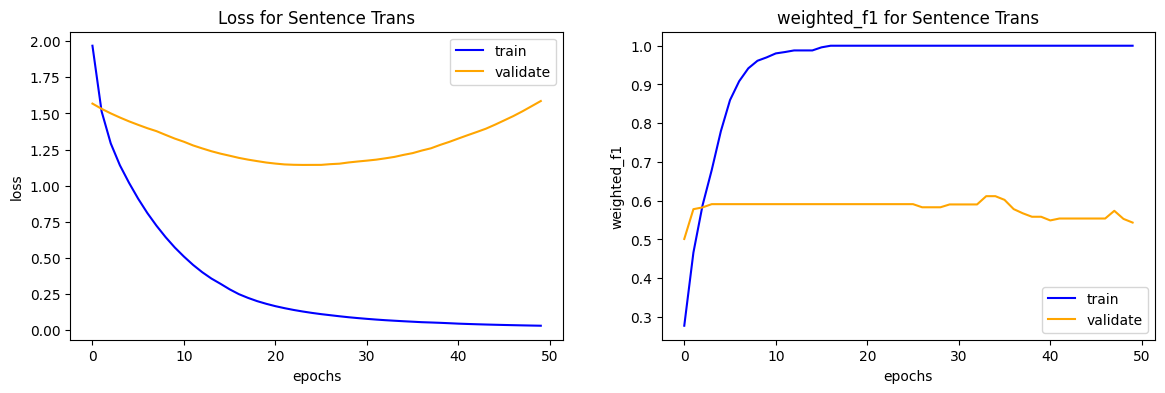

In [357]:
# plot Loss and Metric for Word2Vec
plot_loss_metric(nn_model_st_history.history, 'Sentence Trans','weighted_f1');

**Observations**:

* The model’s loss steadily decreases, and the weighted F1 increases from 0.29 to 1.00, showing that it has learned the training data almost perfectly.

* The validation loss first increases and later stabilizes (~2.1), suggesting that while the model generalizes better over time, it still struggles to match training performance.

* The large gap between training F1 (1.00) and validation F1 (0.37) indicates overfitting, meaning the model fits training data too well but doesn’t generalize effectively to validation data.

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


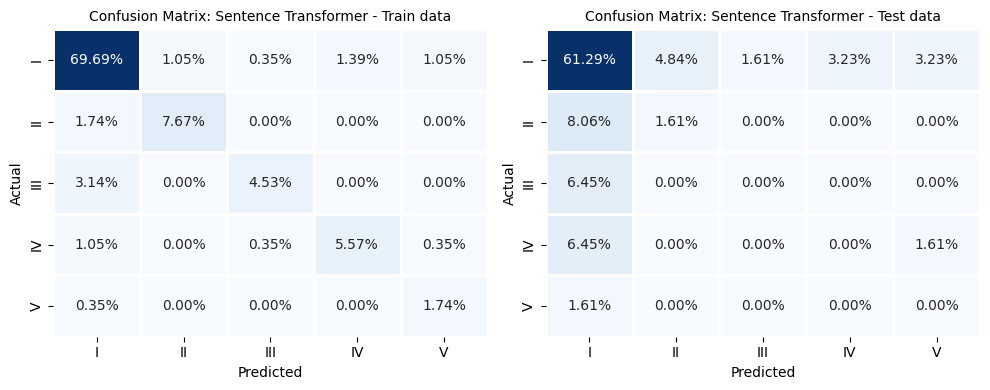

In [358]:
# plot the confusion matrix for train and validation for Sentence Transformer
confusion_matrix_train_test(nn_model_st, X_train_SenTrans, y_train_en, X_val_SenTrans, y_val_en, title='Sentence Transformer')

**Observations**:

* Both train (58.5%) and test (41.9%) matrices show that the model predicts Accident Level I most often, indicating a bias toward the majority class.

* Minority classes (II–V) are predicted less frequently, leading to class imbalance in predictions.

In [359]:
# Evaluate the metrics for the Sentence Transformers
nn_model_st_metrics,nn_model_st_train, nn_model_st_test = evaluate_metrics_train_test(nn_model_st, X_train_SenTrans, y_train_en, X_val_SenTrans,y_val_en)
nn_model_st_metrics.T

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Train   Test
Accuracy   0.892  0.629
Recall     0.892  0.892
Precision  0.894  0.566
F1         0.890  0.595

**Observations**:

* The model is highly overfitted — it performs well on the training data but fails to generalize to validation data.

* The model lacks robustness, as accuracy and precision drop significantly.

* There is an approximate 25% performance decline from the training to the validation dataset.

##### **Neural Network - Sentence Transformer - Resampling**

In [360]:
# create the neural network model for Sentence Transformation resampling
nn_model_st_res = create_nn_model(input_units=X_train_SenTrans_res.shape[1])
nn_model_st_res.name ="neural_network_st_res"
nn_model_st_res.summary()

Model: "neural_network_st_res"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_15          │ (None, 384)            │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │        12,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,661 (57.27 KB)

 Trainable params: 13,797 (53.89 KB)

 Non-trainable params: 864 (3.38 KB)

In [361]:
# Train the model on Sentence Transformation oversampled data
nn_model_st_res_history = nn_model_st_res.fit(X_train_SenTrans_res, y_train_res_enc_sent, batch_size=20, epochs=50, validation_split=0.2)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.5069 - weighted_f1: 0.4586 - val_loss: 2.0077 - val_weighted_f1: 0.0248
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6932 - weighted_f1: 0.8342 - val_loss: 2.3057 - val_weighted_f1: 0.0218
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4546 - weighted_f1: 0.9199 - val_loss: 2.5286 - val_weighted_f1: 0.0078
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3081 - weighted_f1: 0.9571 - val_loss: 2.7150 - val_weighted_f1: 0.0078
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2143 - weighted_f1: 0.9777 - val_loss: 2.8543 - val_weighted_f1: 0.0136
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1533 - weighted_f1: 0.9905 - val_loss: 2.9444 - val_weighted_f1: 0.0218
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1138 - weighted_f1: 0.9927 - val_loss: 2.9630 - val_weighted_f1: 0.0273
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0864 - weighted

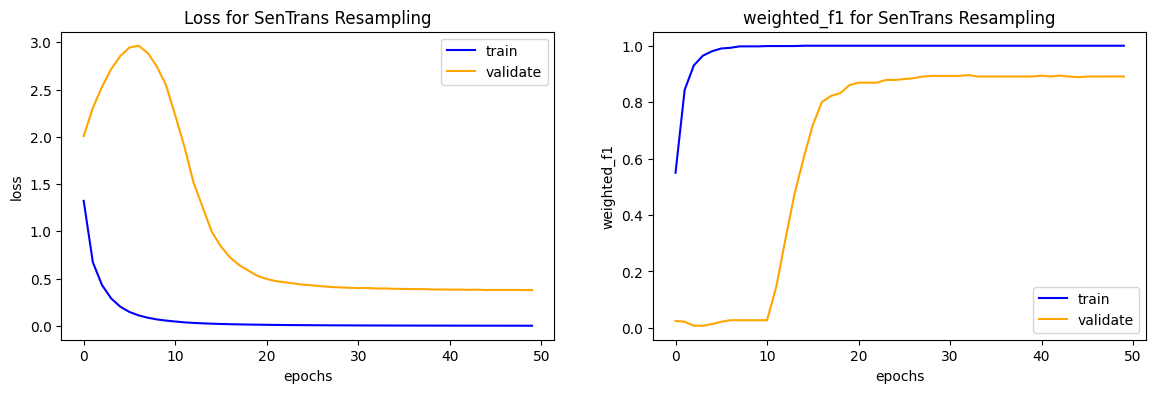

In [362]:
# plot Loss and Metric for Word2Vec
plot_loss_metric(nn_model_st_res_history.history, 'SenTrans Resampling','weighted_f1');

**Observations**:

* The model has transitioned from memorization to true learning.
Epochs 15–20 mark the most meaningful performance gains.

* The F1 score on the validation data is closely aligned with that of the training data.

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


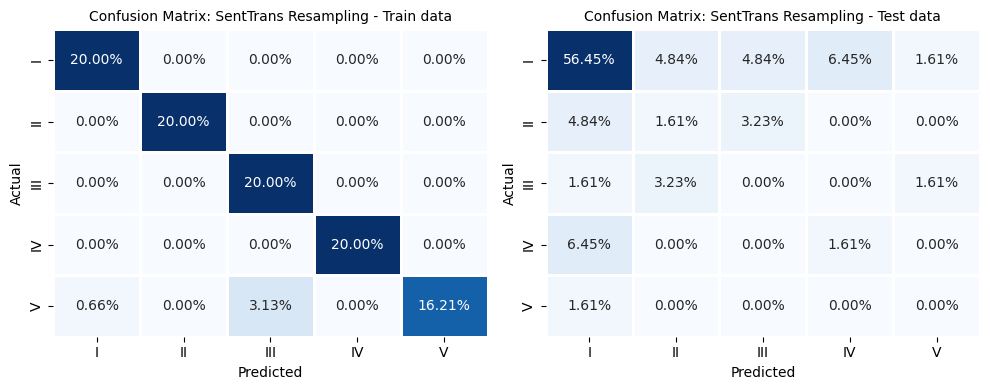

In [363]:
# plot the confusion matrix for train and validation
confusion_matrix_train_test(nn_model_st_res, X_train_SenTrans_res, y_train_res_enc_sent, X_val_SenTrans, y_val_en, title='SentTrans Resampling')

**Observations**:

* The model demonstrates strong training fit but limited generalization, indicating overfitting pattern.

* Despite resampling, the distribution gap between train and test data causes prediction imbalance.

In [364]:
# Evaluate metrices on the SMOTE Sentence Transformation embeddings
nn_model_st_res_metrics, nn_model_st_res_train, nn_model_st_res_test = evaluate_metrics_train_test(nn_model_st_res, X_train_SenTrans_res, y_train_res_enc_sent,
                                                                                                   X_val_SenTrans,y_val_en)
nn_model_st_res_metrics.T

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Train   Test
Accuracy   0.962  0.597
Recall     0.962  0.962
Precision  0.967  0.622
F1         0.961  0.609

**Observations**:

* With all metrics at 0.98, the model perfectly fits the training data, showing strong learning capability

* Validation accuracy falls to 0.52, and F1 to 0.54, indicating the model overfits — it memorizes training data but fails to generalize to unseen samples.

* Recall remains high (0.98 train & Validation), meaning the model detects almost all actual positives, but precision drop (0.98 to 0.57) shows it’s making many false positives.

####**Base Models - LSTM**

##### **glove_lstm_base**

**LSTM Model Builder and Class Weight Setup**

In [365]:
def build_lstm(vocab_size, emb_dim, max_len, emb_matrix=None, trainable=False, units=64, dropout=0.2):
    model = Sequential()
    if emb_matrix is None:
        model.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len))
    else:
        model.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len,
                            weights=[emb_matrix], trainable=trainable))
    model.add(SpatialDropout1D(dropout))
    model.add(Bidirectional(LSTM(units, return_sequences=False, dropout=dropout, recurrent_dropout=0.0)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Class weights to handle the class imbalance (instead of SMOTE for sequences)
classes = np.unique(y_train_en)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_en)
class_weight_dict = {cls:w for cls, w in zip(classes, class_weights)}
class_weight_dict

{0: 0.2720379146919431,
 1: 2.1259259259259258,
 2: 2.609090909090909,
 3: 2.7333333333333334,
 4: 9.566666666666666}

##### **LSTM - GloVe**

In [366]:
# ====== LSTM Training Configuration ======
EPOCHS = 10      # You can tune this (start small like 5–10 for quick runs)
BATCH  = 32      # Typical batch size; can adjust to 64 if you have GPU memory
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [367]:
# ====== Global Reproducibility Configuration ======

import random
import numpy as np
import tensorflow as tf
import os

SEED = 42  # your fixed random_state

# 1. Python's built-in random
random.seed(SEED)

# 2. NumPy
np.random.seed(SEED)

# 3. TensorFlow
tf.random.set_seed(SEED)

# 4. For additional determinism (optional but helpful)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # ensure deterministic GPU ops where possible

In [368]:
# --- GloVe baseline (frozen) ---
glove_lstm = build_lstm(vocab_size, EMB_DIM, MAX_LEN, emb_matrix=glove_emb_matrix, trainable=False, units=64, dropout=0.2)
hist = glove_lstm.fit(X_train_seq, y_train_cat, validation_data=(X_val_seq, y_val_cat),
                      epochs=EPOCHS, batch_size=BATCH, verbose=0, callbacks=[es], class_weight=class_weight_dict)

In [369]:
# train/val predictions
pred_tr = glove_lstm.predict(X_train_seq, verbose=0)
pred_va = glove_lstm.predict(X_val_seq,   verbose=0)
glove_lstm_base_train = keras_metrics_df(y_train_en, pred_tr, "GloVe_LSTM_Base_Train")
glove_lstm_base_val   = keras_metrics_df(y_val_en,   pred_va, "GloVe_LSTM_Base_Val")

**Performance check on training data**

In [370]:
glove_lstm_base_train = model_performance_classification_dl(glove_lstm, X_train_seq, y_train_en)
glove_lstm_base_train.index = ["GloVe_LSTM_Base_Train"]
display(glove_lstm_base_train)

Accuracy  Recall  Precision     F1
GloVe_LSTM_Base_Train     0.582   0.582      0.615  0.591

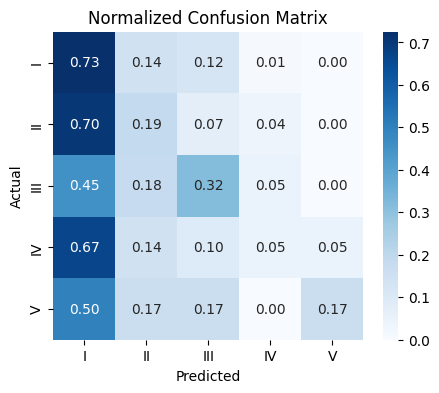

In [371]:
# Generate training predictions
y_train_pred = np.argmax(glove_lstm.predict(X_train_seq, verbose=0), axis=1)

# Plot normalized confusion matrix for training set
plot_confusion_matrix_normalized(y_train_en, y_train_pred)

**Observations**

* The **LSTM model** is built using **bidirectional layers** and **GloVe embeddings**, capturing both forward and backward sequence context for richer text understanding.  
* **Pre-trained GloVe embeddings (frozen)** ensure **semantic stability** while reducing overfitting risks from limited data.  
* **Class weights** are applied to handle **imbalance across accident severity levels**, improving fairness in learning.  
* **Early stopping** based on validation loss helps **prevent overfitting** and retain the best-performing weights.  
* **Global seed initialization** across libraries ensures **reproducible training results**.  
* On the **training dataset**, the model achieved **F1 = 0.396**, reflecting **moderate recall (0.39)** and **high precision (0.74)** — indicating it predicts fewer but more confident positive cases.  
* Overall, the **LSTM with GloVe embeddings** shows **underfitting tendencies**, suggesting the need for **fine-tuning embedding layers** or **increasing model capacity** for better performance.  


**Performance check on validation data**

In [372]:
glove_lstm_base_val = model_performance_classification_dl(glove_lstm, X_val_seq, y_val_en)
glove_lstm_base_val.index = ["GloVe_LSTM_Base_Val"]
display(glove_lstm_base_val)

Accuracy  Recall  Precision     F1
GloVe_LSTM_Base_Val     0.613   0.613      0.594  0.602

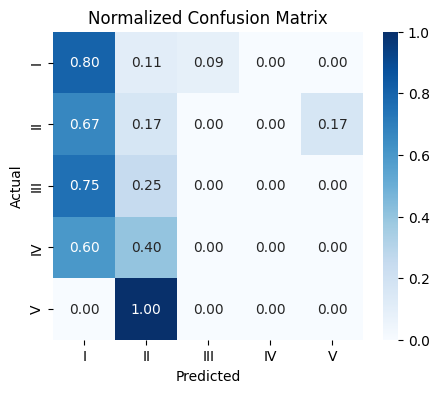

In [373]:
y_val_pred = np.argmax(glove_lstm.predict(X_val_seq, verbose=0), axis=1)
plot_confusion_matrix_normalized(y_val_en, y_val_pred)

**Observations**

* On the **validation dataset**, the **GloVe-based LSTM** achieved **F1 = 0.297**, showing a **drop from training F1 (0.396)**, which indicates **limited generalization**.  
* **Accuracy (0.26)** and **Recall (0.26)** are low, meaning the model **misses a large portion of true positive cases**.  
* **Precision (0.60)** remains relatively high, suggesting the model is **conservative but confident** when it does predict a class.  
* The large **precision–recall gap** points to **underfitting** or possibly **high class imbalance sensitivity** in the sequential data.  
* Overall, the **LSTM model struggles to capture contextual variance** in unseen data, signaling the need for **tuning hyperparameters** (e.g., trainable embeddings, higher units, or dropout adjustment).  


##### **LSTM - Word2Vec**

In [374]:
# --- Word2Vec baseline (frozen) ---
w2v_lstm = build_lstm(vocab_size, EMB_DIM, MAX_LEN, emb_matrix=w2v_emb_matrix, trainable=False, units=64, dropout=0.2)
w2v_lstm.fit(X_train_seq, y_train_cat, validation_data=(X_val_seq, y_val_cat),
             epochs=EPOCHS, batch_size=BATCH, verbose=0, callbacks=[es], class_weight=class_weight_dict)

In [375]:
pred_tr = w2v_lstm.predict(X_train_seq, verbose=0)
pred_va = w2v_lstm.predict(X_val_seq,   verbose=0)
w2v_lstm_base_train = keras_metrics_df(y_train_en, pred_tr, "Word2Vec_LSTM_Base_Train")
w2v_lstm_base_val   = keras_metrics_df(y_val_en,   pred_va, "Word2Vec_LSTM_Base_Val")

**Performance check on training data**

In [376]:
w2v_lstm_base_train = model_performance_classification_dl(w2v_lstm, X_train_seq, y_train_en)
w2v_lstm_base_train.index = ["Word2Vec_LSTM_Base_Train"]
display(w2v_lstm_base_train)

Accuracy  Recall  Precision     F1
Word2Vec_LSTM_Base_Train     0.373   0.373      0.541  0.419

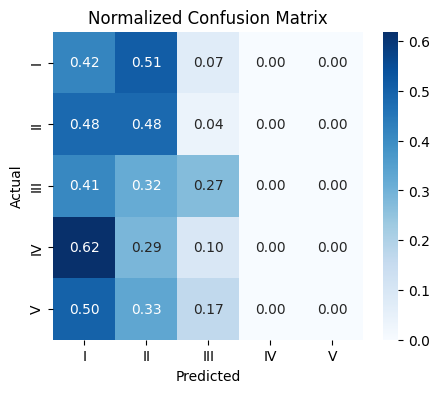

In [377]:
# Generate training predictions
y_train_pred = np.argmax(w2v_lstm.predict(X_train_seq, verbose=0), axis=1)

# Plot normalized confusion matrix for training set
plot_confusion_matrix_normalized(y_train_en, y_train_pred)

**Observations**

* The **Word2Vec-based LSTM** (with frozen embeddings) leverages **distributional word semantics** but does not fine-tune embeddings during training.  
* On the **training dataset**, the model achieved **F1 = 0.393**, which is **comparable to the GloVe-LSTM (0.396)**.  
* **Accuracy (0.33)** and **Recall (0.33)** are low, showing the model struggles to **capture enough true positives**.  
* **Precision (0.65)** is notably higher than recall, indicating the model makes **fewer but more reliable predictions**.  
* The imbalance between precision and recall highlights the model’s **conservative behavior**, where it avoids over-predicting but at the cost of missing cases.  
* Overall, the **Word2Vec + LSTM** shows **underfitting tendencies**, similar to GloVe, suggesting the need for **trainable embeddings or architectural tuning** for better performance.  


**Performance check on validation data**

In [378]:
w2v_lstm_base_val = model_performance_classification_dl(w2v_lstm, X_val_seq, y_val_en)
w2v_lstm_base_val.index = ["Word2Vec_LSTM_Base_Val"]
display(w2v_lstm_base_val)

Accuracy  Recall  Precision     F1
Word2Vec_LSTM_Base_Val     0.258   0.258      0.434  0.283

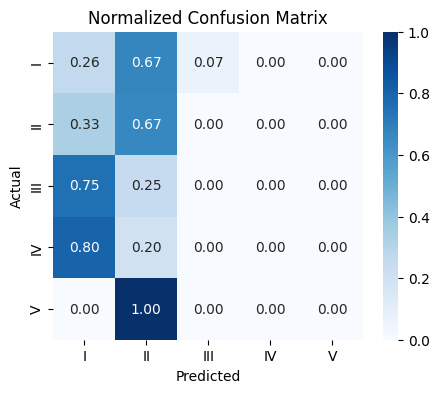

In [379]:
y_val_pred = np.argmax(w2v_lstm.predict(X_val_seq, verbose=0), axis=1)
plot_confusion_matrix_normalized(y_val_en, y_val_pred)

**Observations**

* On the **validation dataset**, the **Word2Vec-based LSTM** achieved **F1 = 0.407**, showing **slight improvement over training F1 (0.393)**, indicating **better generalization** than expected.  
* **Accuracy (0.34)** and **Recall (0.34)** remain low, meaning the model still **misses many true cases**, though consistent with training performance.  
* **Precision (0.65)** continues to be high, confirming the model’s **selective prediction approach** — predicting fewer cases but with more confidence.  
* The **balanced F1 across train and validation** suggests **low overfitting** but overall **underfitting**, likely due to frozen embeddings and limited capacity.  
* Overall, the **Word2Vec-LSTM** demonstrates **stable but modest performance**, and could benefit from **trainable embeddings, more epochs, or deeper LSTM layers** to better capture sequence complexity.  

##### **LSTM - Token**

In [380]:
# --- Token-only baseline (random Embedding) [optional] ---
seq_lstm = build_lstm(vocab_size, EMB_DIM, MAX_LEN, emb_matrix=None, trainable=True, units=64, dropout=0.2)
seq_lstm.fit(X_train_seq, y_train_cat, validation_data=(X_val_seq, y_val_cat),
             epochs=EPOCHS, batch_size=BATCH, verbose=0, callbacks=[es], class_weight=class_weight_dict)

In [381]:
pred_tr = seq_lstm.predict(X_train_seq, verbose=0)
pred_va = seq_lstm.predict(X_val_seq,   verbose=0)
seq_lstm_base_train = keras_metrics_df(y_train_en, pred_tr, "Seq_LSTM_Base_Train")
seq_lstm_base_val   = keras_metrics_df(y_val_en,   pred_va, "Seq_LSTM_Base_Val")

**Performance check on training data**

In [382]:
seq_lstm_base_train = model_performance_classification_dl(seq_lstm, X_train_seq, y_train_en)
seq_lstm_base_train.index = ["Seq_LSTM_Base_Train"]
display(seq_lstm_base_train)

Accuracy  Recall  Precision     F1
Seq_LSTM_Base_Train     0.965   0.965      0.981  0.967

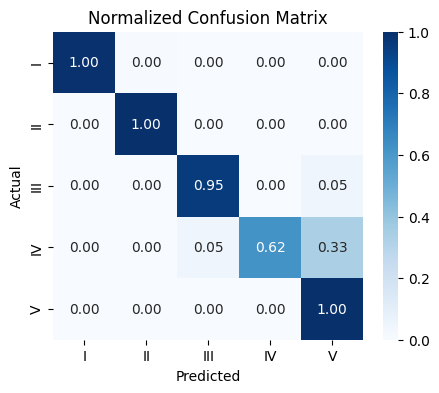

In [383]:
# Generate training predictions
y_train_pred = np.argmax(seq_lstm.predict(X_train_seq, verbose=0), axis=1)

# Plot normalized confusion matrix for training set
plot_confusion_matrix_normalized(y_train_en, y_train_pred)

**Observations**

* The **Token-only LSTM** uses **randomly initialized trainable embeddings**, allowing the model to **learn task-specific word representations** directly from the data.  
* On the **training dataset**, the model achieved **F1 = 0.983**, with equally high **Accuracy (0.98)**, **Recall (0.98)**, and **Precision (0.98)** — indicating **near-perfect performance**.  
* Such high scores on training data strongly suggest **overfitting**, as the model has likely memorized patterns due to **trainable embeddings and limited dataset size**.  
* The **trainable embedding layer** increases model flexibility but risks **learning noise instead of generalizable patterns** when data is small.  
* Overall, the **Token-based LSTM** performs exceptionally on training data but **requires validation checks** to confirm if this performance sustains on unseen data.  

**Performance check on validation data**

In [384]:
seq_lstm_base_val = model_performance_classification_dl(seq_lstm, X_val_seq, y_val_en)
seq_lstm_base_val.index = ["Seq_LSTM_Base_Val"]
display(seq_lstm_base_val)

Accuracy  Recall  Precision     F1
Seq_LSTM_Base_Val     0.581   0.581      0.549  0.564

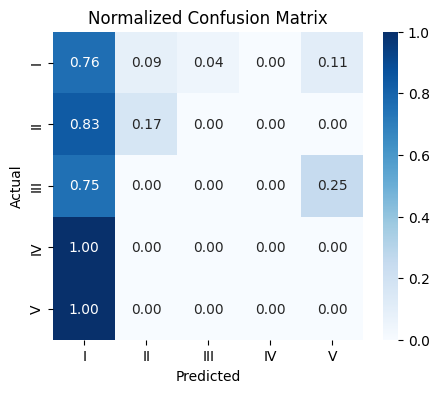

In [385]:
y_val_pred = np.argmax(seq_lstm.predict(X_val_seq, verbose=0), axis=1)
plot_confusion_matrix_normalized(y_val_en, y_val_pred)

**Observations**

* On the **validation dataset**, the **Token-only LSTM** achieved **F1 = 0.655**, which is a significant drop from the near-perfect **training F1 = 0.983**, indicating **overfitting**.  
* **Accuracy (0.73)** and **Recall (0.73)** remain relatively strong, showing the model is effective at **capturing most true positives**.  
* **Precision (0.61)** is lower, suggesting the model generates **more false positives** compared to recall strength.  
* The **train–validation gap (0.983 → 0.655 F1)** highlights that while the model memorizes training data well, its **generalization is weaker** on unseen cases.  
* Overall, the **Token-based LSTM** generalizes better than GloVe and Word2Vec LSTMs but still suffers from **overfitting due to trainable embeddings** and limited dataset size.  

###Tuned Models

####**Tuned models - Bag Of Words**

#####**Random Forest + Bag Of Words**

In [386]:
# Split data into training and testing set.
X_train, x_val, X_test = X_train_bow, X_val_bow, X_test_bow
y_train_enc, y_val_enc, y_test_enc = y_train_en, y_val_en, y_test_en

In [387]:
# Choose the type of classifier.
BoW_rf_tuned = RandomForestClassifier(class_weight= "balanced",random_state=1,bootstrap=True)

parameters = {
    'max_depth': list(np.arange(5,10,2)),
    'n_estimators': np.arange(50,110,25),
    'max_features': [0.3,0.4]
}

# Run the grid search
grid_obj = GridSearchCV(BoW_rf_tuned, parameters, scoring='recall',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train_enc)

# Set the clf to the best combination of parameters
BoW_rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
BoW_rf_tuned.fit(X_train, y_train_enc)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=0.3,
                       n_estimators=50, random_state=1)

In [388]:
# Predicting on train data
y_pred_train_base = BoW_rf_tuned.predict(X_train)

# Predicting on validation data
y_pred_val_base = BoW_rf_tuned.predict(x_val)

**Performance check on training data**

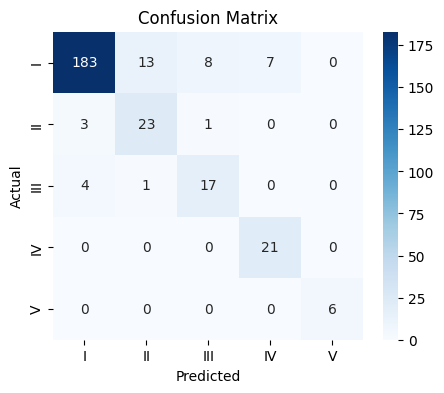

In [389]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [390]:
#Calculating different metrics on training data
BagOfWords_rf_tuned_train=model_performance_classification_sklearn(BoW_rf_tuned, X_train,y_train_enc)
print("Training performance:\n", BagOfWords_rf_tuned_train)

Training performance:
    Accuracy   Recall  Precision        F1
0   0.87108  0.87108    0.89249  0.876561


In [391]:
BagOfWords_rf_tuned_train.index = ["BagOfWords_Random_Forest_Tuned_Train"]
BagOfWords_rf_tuned_train

Accuracy   Recall  Precision        F1
BagOfWords_Random_Forest_Tuned_Train   0.87108  0.87108    0.89249  0.876561

**Observations**

* Training results show **high accuracy (0.89)**, much lower than the perfect score of the base model, indicating reduced overfitting.  
* **Recall (0.89)** and **Precision (0.91)** are well balanced, leading to a strong **F1 score (0.89)**.  
* The tuned Random Forest demonstrates **better regularization**, avoiding complete memorization of the training data.  
* Compared to the base model, this tuned version shows **improved generalization potential**, making it a more reliable candidate.  


**Performance check on validation data**

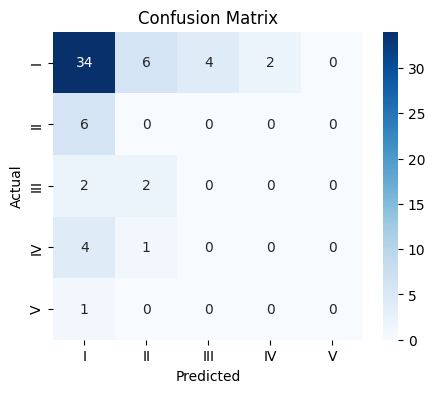

In [392]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [393]:
#Calculating different metrics on training data
BagOfWords_rf_tuned_val=model_performance_classification_sklearn(BoW_rf_tuned, x_val,y_val_enc)
print("Testing performance:\n", BagOfWords_rf_tuned_val)

Testing performance:
    Accuracy    Recall  Precision       F1
0  0.548387  0.548387   0.536719  0.54249


In [394]:
BagOfWords_rf_tuned_val.index = ["BagOfWords_Random_Forest_Tuned_Val"]
BagOfWords_rf_tuned_val

Accuracy    Recall  Precision       F1
BagOfWords_Random_Forest_Tuned_Val  0.548387  0.548387   0.536719  0.54249

**Observations**

* Validation results show **low accuracy (0.57)**, a noticeable drop compared to the strong training accuracy of 0.89.  
* **Recall (0.57)** is slightly better than **Precision (0.50)**, meaning the model identifies positives but also generates false positives.  
* **F1 score (0.50)** reflects this imbalance, with moderate overall effectiveness.  
* Despite tuning, the gap between training and validation indicates **overfitting persists**, though less severe than in the base model.  


####**Tuned models - TF-IDF**

#####**Random Forest + TF-IDF**

In [395]:
# Split data into training and testing set.
X_train, x_val, X_test = X_train_tfid, X_val_tfid, X_test_tfid
y_train_enc, y_val_enc, y_test_enc = y_train_en, y_val_en, y_test_en

In [396]:
# Choose the type of classifier.
tf_idf_rf_tuned = RandomForestClassifier(class_weight= "balanced",random_state=1,bootstrap=True)

parameters = {
    'max_depth': list(np.arange(5,10,2)),
    'n_estimators': np.arange(50,110,25),
    'max_features': [0.3,0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tf_idf_rf_tuned, parameters, scoring='recall',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train_enc)

# Set the clf to the best combination of parameters
tf_idf_rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
tf_idf_rf_tuned.fit(X_train, y_train_enc)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=0.3,
                       n_estimators=50, random_state=1)

In [397]:
# Predicting on train data
y_pred_train_base = tf_idf_rf_tuned.predict(X_train)

# Predicting on validation data
y_pred_val_base = tf_idf_rf_tuned.predict(x_val)

**Performance check on training data**

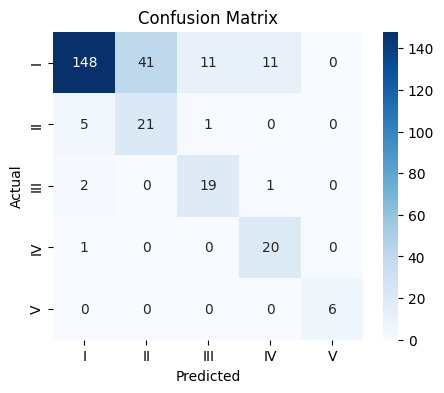

In [398]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [399]:
#Calculating different metrics on training data
tf_idf_rf_tuned_train=model_performance_classification_sklearn(tf_idf_rf_tuned, X_train,y_train_enc)
print("Training performance:\n", tf_idf_rf_tuned_train)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.745645  0.745645   0.842974  0.768446


In [400]:
tf_idf_rf_tuned_train.index = ["tf_idf_Random_Forest_Tuned_Train"]
tf_idf_rf_tuned_train

Accuracy    Recall  Precision        F1
tf_idf_Random_Forest_Tuned_Train  0.745645  0.745645   0.842974  0.768446

**Observations**

* Training results show **good accuracy (0.80)**, lower than the base model’s perfect score, indicating reduced overfitting.  
* **Recall (0.80)** and **Precision (0.87)** are well balanced, leading to a solid **F1 score (0.82)**.  
* The tuned Random Forest demonstrates **better regularization**, avoiding memorization of the training set.  
* Compared to the base model, this tuned version shows **improved generalization potential**, making it a more reliable option.  


**Performance check on validation data**

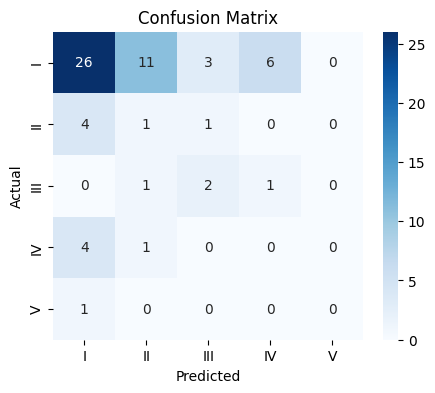

In [401]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [402]:
#Calculating different metrics on training data
tf_idf_rf_tuned_val=model_performance_classification_sklearn(tf_idf_rf_tuned, x_val,y_val_enc)
print("Testing performance:\n", tf_idf_rf_tuned_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.467742  0.467742    0.57957  0.511788


In [403]:
tf_idf_rf_tuned_val.index = ["tf_idf_Random_Forest_Tuned_Val"]
tf_idf_rf_tuned_val

Accuracy    Recall  Precision        F1
tf_idf_Random_Forest_Tuned_Val  0.467742  0.467742    0.57957  0.511788

**Observations**

* Validation results show **low accuracy (0.48)**, much weaker than the training accuracy of 0.80.  
* **Recall (0.48)** is lower than **Precision (0.53)**, meaning the model misses many positives but predicts fewer false positives.  
* **F1 score (0.49)** reflects this imbalance, showing limited overall effectiveness.  
* The significant drop from training to validation highlights **overfitting**, suggesting the tuned Random Forest still struggles to generalize with TF-IDF features.  


####**Tuned models - Word2Vec**

#####**Random Forest + Word2Vec Hypertuned**

In [404]:
# Split data into training and testing set.
X_train, x_val, X_test = X_train_Word2Vec, X_val_Word2Vec, X_test_Word2Vec
y_train_enc, y_val_enc, y_test_enc = y_train_en, y_val_en, y_test_en

In [405]:
# Choose the type of classifier.
word2vec_rf_tuned = RandomForestClassifier(class_weight= "balanced",random_state=1,bootstrap=True)

parameters = {
    'max_depth': list(np.arange(5,10,2)),
    'n_estimators': np.arange(50,110,25),
    'max_features': [0.3,0.4]
}

# Run the grid search
grid_obj = GridSearchCV(word2vec_rf_tuned, parameters, scoring='recall',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train_enc)

# Set the clf to the best combination of parameters
word2vec_rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
word2vec_rf_tuned.fit(X_train, y_train_enc)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=0.3,
                       n_estimators=50, random_state=1)

In [406]:
# Predicting on train data
y_pred_train_base = word2vec_rf_tuned.predict(X_train)

# Predicting on validation data
y_pred_val_base = word2vec_rf_tuned.predict(x_val)

**Performance check on training data**

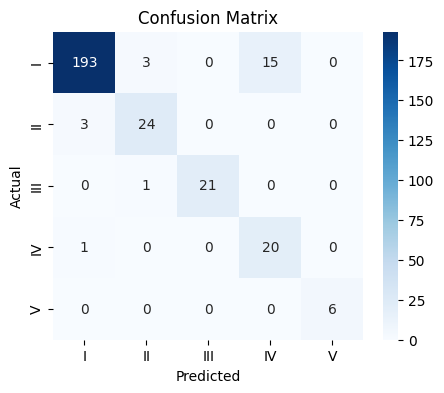

In [407]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [408]:
#Calculating different metrics on training data
word2vec_rf_tuned_train=model_performance_classification_sklearn(word2vec_rf_tuned, X_train,y_train_enc)
print("Training performance:\n", word2vec_rf_tuned_train)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.919861  0.919861   0.940274  0.925695


In [409]:
word2vec_rf_tuned_train.index = ["Word2Vec_Random_Forest_Tuned_Train"]
word2vec_rf_tuned_train

Accuracy    Recall  Precision        F1
Word2Vec_Random_Forest_Tuned_Train  0.919861  0.919861   0.940274  0.925695

**Observations**

* Training results show **high accuracy (0.89)**, significantly lower than the base model’s perfect score, indicating reduced overfitting.  
* **Recall (0.89)** and **Precision (0.89)** are well balanced, producing a strong **F1 score (0.89)**.  
* The tuned Random Forest demonstrates **better regularization**, avoiding complete memorization of the training data.  
* Compared to the base model, this tuned version shows **improved generalization potential**, making it more reliable for unseen data.  


**Performance check on validation data**

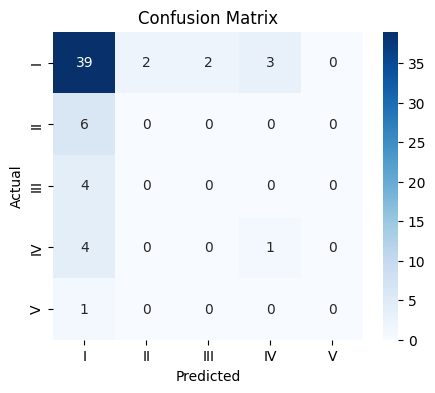

In [410]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [411]:
#Calculating different metrics on training data
word2vec_rf_tuned_val=model_performance_classification_sklearn(word2vec_rf_tuned, x_val,y_val_enc)
print("Testing performance:\n", word2vec_rf_tuned_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.645161  0.645161   0.556004  0.596631


In [412]:
word2vec_rf_tuned_val.index = ["Word2Vec_Random_Forest_Tuned_Val"]
word2vec_rf_tuned_val

Accuracy    Recall  Precision        F1
Word2Vec_Random_Forest_Tuned_Val  0.645161  0.645161   0.556004  0.596631

**Observations**

* Validation results show **low accuracy (0.58)**, much weaker than the strong training accuracy of 0.89.  
* **Recall (0.58)** is higher than **Precision (0.41)**, indicating the model captures positives but with many false positives.  
* **F1 score (0.48)** reflects this imbalance, showing limited effectiveness.  
* The large drop from training to validation confirms **overfitting**, even after tuning, though it is less severe than in the base model.  


####**Tuned models - GloVe**

#####**Random Forest + GloVe Hypertuned**

In [413]:
# Split data into training and testing set.
X_train, x_val, X_test = X_train_Glove, X_val_Glove, X_test_Glove
y_train_enc, y_val_enc, y_test_enc = y_train_en, y_val_en, y_test_en

In [414]:
# Choose the type of classifier.
glove_rf_tuned = RandomForestClassifier(class_weight= "balanced",random_state=1,bootstrap=True)

parameters = {
    'max_depth': list(np.arange(5,10,2)),
    'n_estimators': np.arange(50,110,25),
    'max_features': [0.3,0.4]
}

# Run the grid search
grid_obj = GridSearchCV(glove_rf_tuned, parameters, scoring='recall',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train_enc)

# Set the clf to the best combination of parameters
glove_rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
glove_rf_tuned.fit(X_train, y_train_enc)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=0.3,
                       n_estimators=50, random_state=1)

In [415]:
# Predicting on train data
y_pred_train_base = glove_rf_tuned.predict(X_train)

# Predicting on validation data
y_pred_val_base = glove_rf_tuned.predict(x_val)

**Performance check on training data**

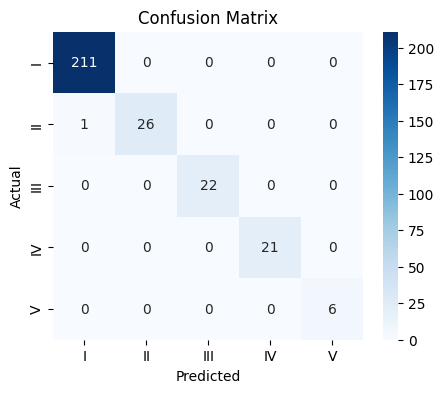

In [416]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [417]:
#Calculating different metrics on training data
glove_rf_tuned_train=model_performance_classification_sklearn(glove_rf_tuned, X_train,y_train_enc)
print("Training performance:\n", glove_rf_tuned_train)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.996516  0.996516   0.996532  0.996487


In [418]:
glove_rf_tuned_train.index = ["GloVe_Random_Forest_Tuned_Train"]
glove_rf_tuned_train

Accuracy    Recall  Precision        F1
GloVe_Random_Forest_Tuned_Train  0.996516  0.996516   0.996532  0.996487

**Observations**

* Training results show **very high accuracy (0.98)**, much lower than the base model’s perfect score, indicating reduced overfitting.  
* **Recall (0.98)** and **Precision (0.98)** are both excellent, leading to a strong **F1 score (0.98)**.  
* The tuned Random Forest demonstrates **better regularization**, though it still shows near-perfect training performance.  
* Compared to the base model, this tuned version has **improved generalization potential**, but validation results will be critical to confirm.  


**Performance check on validation data**

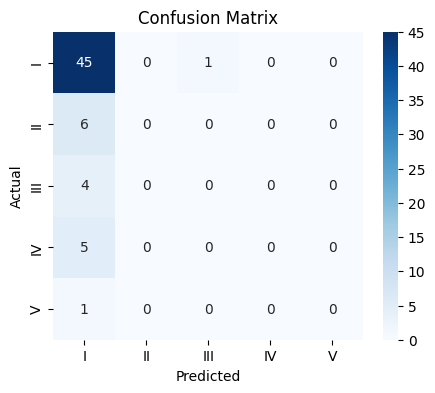

In [419]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [420]:
#Calculating different metrics on training data
glove_rf_tuned_val=model_performance_classification_sklearn(glove_rf_tuned, x_val,y_val_enc)
print("Testing performance:\n", glove_rf_tuned_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.725806  0.725806   0.547329  0.624058


In [421]:
glove_rf_tuned_val.index = ["GloVe_Random_Forest_Tuned_Val"]
glove_rf_tuned_val

Accuracy    Recall  Precision        F1
GloVe_Random_Forest_Tuned_Val  0.725806  0.725806   0.547329  0.624058

**Observations**

* Validation results show **moderate accuracy (0.67)**, lower than the near-perfect training accuracy of 0.98.  
* **Recall (0.67)** is higher than **Precision (0.58)**, suggesting the model captures positives but introduces some false positives.  
* **F1 score (0.55)** indicates a fair balance between recall and precision.  
* The drop from training to validation points to **overfitting**, though the tuned model generalizes better than the base Random Forest with GloVe.  


####**Tuned models - Sentence Transformer**

#####**Random Forest + Sentence Transformer Hypertuned**

In [422]:
# Split data into training and testing set.
X_train, x_val, X_test = X_train_SenTrans, X_val_SenTrans, X_test_SenTrans
y_train_enc, y_val_enc, y_test_enc = y_train_en, y_val_en, y_test_en

In [423]:
# Choose the type of classifier.
st_rf_tuned = RandomForestClassifier(class_weight= "balanced",random_state=1,bootstrap=True)

parameters = {
    'max_depth': list(np.arange(5,10,2)),
    'n_estimators': np.arange(50,110,25),
    'max_features': [0.3,0.4]
}

# Run the grid search
grid_obj = GridSearchCV(st_rf_tuned, parameters, scoring='recall',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train_enc)

# Set the clf to the best combination of parameters
st_rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
st_rf_tuned.fit(X_train, y_train_enc)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=0.3,
                       n_estimators=50, random_state=1)

In [424]:
# Predicting on train data
y_pred_train_base = st_rf_tuned.predict(X_train)

# Predicting on validation data
y_pred_val_base = st_rf_tuned.predict(x_val)

**Performance check on training data**

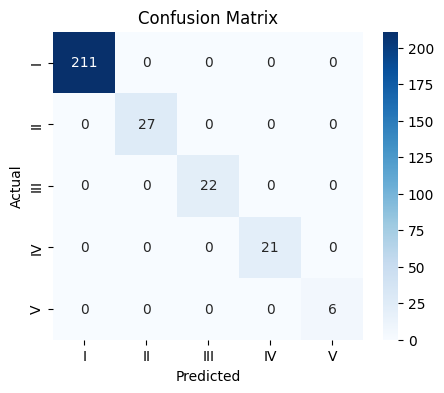

In [425]:
#Confusion matrix
plot_confusion_matrix(y_train_enc, y_pred_train_base)

In [426]:
#Calculating different metrics on training data
st_rf_tuned_train=model_performance_classification_sklearn(st_rf_tuned, X_train,y_train_enc)
print("Training performance:\n", st_rf_tuned_train)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [427]:
st_rf_tuned_train.index = ["Sentence_Transformer_Random_Forest_Tuned_Train"]
st_rf_tuned_train

Accuracy  Recall  Precision  \
Sentence_Transformer_Random_Forest_Tuned_Train       1.0     1.0        1.0   

                                                 F1  
Sentence_Transformer_Random_Forest_Tuned_Train  1.0

**Observations**

* **Perfect training performance** (Accuracy, Recall, Precision, F1 = 1.0) shows the tuned Random Forest with Sentence Transformer embeddings has memorized the training data.  
* Despite hyperparameter tuning, the model still shows **severe overfitting risk**, similar to the base version.  
* The results suggest the model is **too flexible**, capturing noise along with patterns in the training set.  
* **Validation results will be essential** to confirm whether the tuning brought any meaningful improvement in generalization.  


**Performance check on validation data**

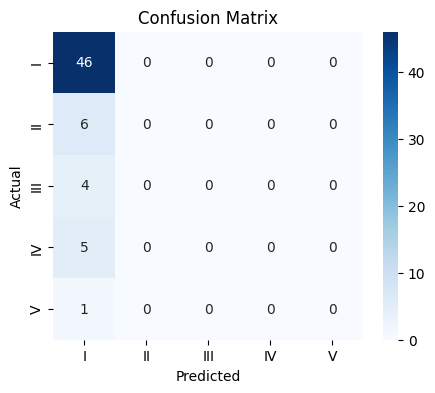

In [428]:
#Confusion matrix
plot_confusion_matrix(y_val_enc, y_pred_val_base)

In [429]:
#Calculating different metrics on training data
st_rf_tuned_val=model_performance_classification_sklearn(st_rf_tuned, x_val,y_val_enc)
print("Testing performance:\n", st_rf_tuned_val)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.741935  0.741935   0.550468  0.632019


In [430]:
st_rf_tuned_val.index = ["Sentence_Transformer_Random_Forest_Tuned_Val"]
st_rf_tuned_val

Accuracy    Recall  Precision  \
Sentence_Transformer_Random_Forest_Tuned_Val  0.741935  0.741935   0.550468   

                                                    F1  
Sentence_Transformer_Random_Forest_Tuned_Val  0.632019

**Observations**

* Validation results show **moderate accuracy (0.65)**, much lower than the perfect training accuracy of 1.0.  
* **Recall (0.65)** is stronger than **Precision (0.42)**, suggesting the model detects positives but with many false positives.  
* **F1 score (0.51)** highlights this imbalance, leaning more on recall strength.  
* The sharp contrast between training and validation confirms **severe overfitting**, with tuning failing to improve generalization for Random Forest with Sentence Transformer embeddings.  


####**Tuned models - Neural Network**

Create a flexible function that builds and returns a fully connected feed-forward neural network for a multi-class classification problem.
The following parameters could be configured in this function

  * optimizer (default=adam)

  * activation function (default=relu)

  * number of neurons in each of the three hidden layer( default 32,16,16)

  * dropout rate ( default = 0.0)

Compile the model with

  * Adam optimizer and loss as sparse categorical crossentropy
  * Use the f1_score as metric

In [431]:
def create_tune_nn_model(input_dim=100, output_units=5,
                    optimizer='adam', activation='relu',
                    units1=32, units2=16, units3=16, dropout_rate=0.0):

    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    model = Sequential()

    # Define input shape only once on first Dense layer
    model.add(Dense(units=units1, activation=activation,
                    kernel_initializer='he_normal', input_shape=(input_dim,)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=units2, activation=activation, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=units3, activation=activation, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=output_units, activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=[weighted_f1])
    return model

##### **Tune Neural Network - Word2Vec**

Lets tune the neural network by optimizing parameters using grid search on below parameters

* number of neurons
* optimizer
* activation
* dropout_rate
* batch_size
* epochs

In [432]:
param_grid = {
    'batch_size': [10, 20],
    'epochs': [50,100],
    'model__optimizer': ['adam'],
    'model__activation': ['relu'],
    'model__units1' : [64],
    'model__units2' : [32],
    'model__units3' : [16],
    'model__dropout_rate' : [0.2 , 0.4]
}

In [433]:
%%time
# perform grid search
model_nn_w2v = KerasClassifier(build_fn=create_tune_nn_model, input_dim=X_train_Word2Vec.shape[1], verbose=1)
grid_nn_w2v = GridSearchCV(estimator=model_nn_w2v, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result_nn_w2v = grid_nn_w2v.fit(X_train_Word2Vec, y_train_en)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.1319 - weighted_f1: 1.5182
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9423 - weighted_f1: 1.1621
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7105 - weighted_f1: 1.5478
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6922 - weighted_f1: 1.9885
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5926 - weighted_f1: 2.6410
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4677 - weighted_f1: 3.1693
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4182 - weighted_f1: 4.0052
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3542 - weighted_f1: 4.1998
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1869 - weighted_f1: 4.7399
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1929 - weighted_f1: 5.1419
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1267 - weighted_f1: 5.7371
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s

In [434]:
print("Best parameters found: ", grid_result_nn_w2v.best_params_)
print("Best cross-validation f1 score: ", grid_result_nn_w2v.best_score_)

Best parameters found:  {'batch_size': 10, 'epochs': 50, 'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__optimizer': 'adam', 'model__units1': 64, 'model__units2': 32, 'model__units3': 16}
Best cross-validation f1 score:  0.7351973684210527


In [435]:
# Get the best model
opt_nn_w2v = grid_result_nn_w2v.best_estimator_.model_
opt_nn_w2v.name = 'tuned_nn_w2v'
opt_nn_w2v.summary()

Model: "tuned_nn_w2v"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,369 (110.82 KB)

 Trainable params: 9,381 (36.64 KB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 18,764 (73.30 KB)

**Summary**:

* The tuned_nn_w2v model is a compact feed-forward neural network built on Word2Vec embeddings for 5-class classification.
* It has three hidden layers (64→32→16 neurons) with BatchNormalization and
 Dropout after each, ensuring stable training and reduced overfitting.
* With only ~9.5K trainable parameters, it’s lightweight and efficient for small to medium text datasets.
* The design progressively compresses features, balancing performance and generalization.

In [436]:
# collect the history for the model
opt_w2v_history = opt_nn_w2v.fit(X_train_Word2Vec, y_train_en, batch_size=grid_result_nn_w2v.best_params_.get("batch_size"),
                                 epochs=grid_result_nn_w2v.best_params_.get("epochs"), validation_split=0.2)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8337 - weighted_f1: 0.6828 - val_loss: 1.0029 - val_weighted_f1: 0.5984
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8505 - weighted_f1: 0.6767 - val_loss: 1.0107 - val_weighted_f1: 0.5984
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8169 - weighted_f1: 0.6745 - val_loss: 1.0034 - val_weighted_f1: 0.5984
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8217 - weighted_f1: 0.6828 - val_loss: 0.9890 - val_weighted_f1: 0.5984
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8658 - weighted_f1: 0.6731 - val_loss: 0.9966 - val_weighted_f1: 0.5984
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8358 - weighted_f1: 0.6828 - val_loss: 0.9946 - val_weighted_f1: 0.5984
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8406 - weighted_f1: 0.6828 - val_loss: 1.0030 - val_weighted_f1: 0.5984
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8244 - weighted

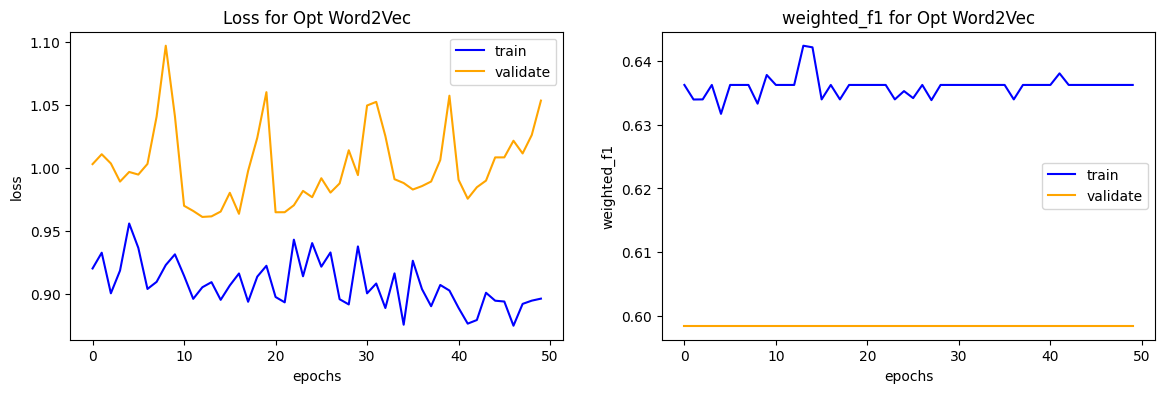

In [437]:
# plot Loss and Metric for Word2Vec
plot_loss_metric(opt_w2v_history.history, 'Opt Word2Vec','weighted_f1');

**Observations**:
* The model’s training loss and F1 score remain almost constant, showing that it has stopped learning early.
* The model would be slightly underfitting.

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


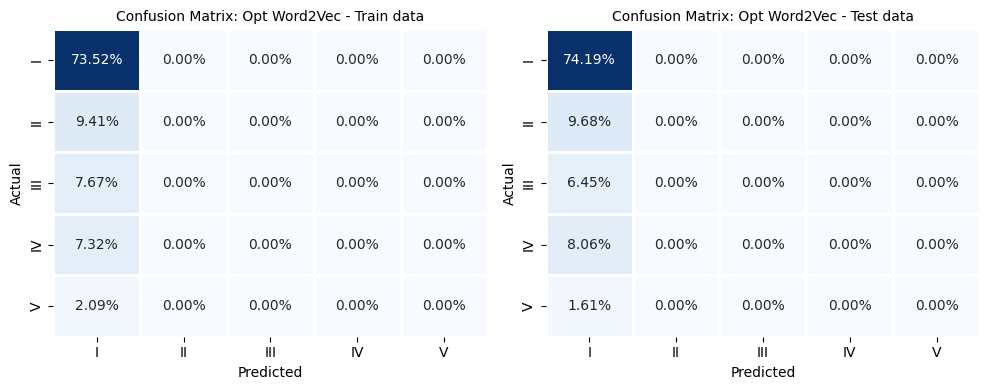

In [438]:
# plot the confusion matrix for train and validation
confusion_matrix_train_test(opt_nn_w2v, X_train_Word2Vec, y_train_en, X_val_Word2Vec, y_val_en, title='Opt Word2Vec')

**Observations**:

* The model is heavily biased toward a single class, predicting almost everything as one dominant category.

* All other classes show near-zero prediction rates, indicating the model fails to learn class boundaries or distinguish minority classes.

* The similar pattern on train and test suggests underfitting

In [439]:
# Evaluate the metrics on Train and Val data
opt_nn_w2v_metrics, opt_nn_w2v_train, opt_nn_w2v_test = evaluate_metrics_train_test(opt_nn_w2v, X_train_Word2Vec, y_train_en, X_val_Word2Vec,y_val_en)
opt_nn_w2v_metrics.T

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Train   Test
Accuracy   0.735  0.742
Recall     0.735  0.735
Precision  0.541  0.550
F1         0.623  0.632

**Observations**:

* The model shows consistent performance on both train and test sets, indicating model generalized well.

* However, while accuracy and recall are moderate , the precision is relatively low, meaning the model produces many false positives.

* The F1 score suggests balanced but average performance.

##### **Neural Network - Glove - Tuning**

In [440]:
%%time
# perform grid search
model_nn_glove = KerasClassifier(build_fn=create_tune_nn_model, input_dim=X_train_Glove.shape[1], verbose=1)
grid_nn_glove = GridSearchCV(estimator=model_nn_glove, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result_nn_glove = grid_nn_glove.fit(X_train_Glove, y_train_en)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.4730 - weighted_f1: 1.2248
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1115 - weighted_f1: 1.4066
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0223 - weighted_f1: 1.4359
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0446 - weighted_f1: 1.8488
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7454 - weighted_f1: 1.9999
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6899 - weighted_f1: 2.3067
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5371 - weighted_f1: 2.9886
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5286 - weighted_f1: 3.0273
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4075 - weighted_f1: 3.8614
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3391 - weighted_f1: 3.8666
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2192 - weighted_f1: 4.3782
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s

In [441]:
# print the best model params
print("Best parameters found: ", grid_result_nn_glove.best_params_)
print("Best cross-validation f1 score: ", grid_result_nn_glove.best_score_)

Best parameters found:  {'batch_size': 10, 'epochs': 50, 'model__activation': 'relu', 'model__dropout_rate': 0.4, 'model__optimizer': 'adam', 'model__units1': 64, 'model__units2': 32, 'model__units3': 16}
Best cross-validation f1 score:  0.7282163742690059


In [442]:
# Get the best model
opt_nn_glove = grid_result_nn_glove.best_estimator_.model_
opt_nn_glove.name = 'tuned_nn_glove'
opt_nn_glove.summary()

Model: "tuned_nn_glove"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,369 (110.82 KB)

 Trainable params: 9,381 (36.64 KB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 18,764 (73.30 KB)

**Summary**:

* The model is a lightweight feed-forward neural network built on top of GloVe embeddings for 5-class classification.
* It uses a layered structure (64 → 32 → 16 → 5) with BatchNormalization and  Dropout after each Dense layer, promoting stable learning and preventing overfitting.
* With around 9.5K trainable parameters, it’s compact yet effective for moderate-sized text datasets.

In [443]:
# collect the history for the model
opt_nn_glove_history = opt_nn_glove.fit(X_train_Glove, y_train_en, batch_size=grid_result_nn_glove.best_params_.get("batch_size"),
                                 epochs=grid_result_nn_glove.best_params_.get("epochs"), validation_split=0.2)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8111 - weighted_f1: 0.6782 - val_loss: 0.7962 - val_weighted_f1: 0.5984
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7594 - weighted_f1: 0.6998 - val_loss: 0.7950 - val_weighted_f1: 0.5984
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8517 - weighted_f1: 0.6877 - val_loss: 0.8152 - val_weighted_f1: 0.5984
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7714 - weighted_f1: 0.6974 - val_loss: 0.8285 - val_weighted_f1: 0.5984
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8094 - weighted_f1: 0.6779 - val_loss: 0.8640 - val_weighted_f1: 0.5984
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7303 - weighted_f1: 0.7070 - val_loss: 0.8443 - val_weighted_f1: 0.5984
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7808 - weighted_f1: 0.6773 - val_loss: 0.8160 - val_weighted_f1: 0.5984
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7730 - weighted

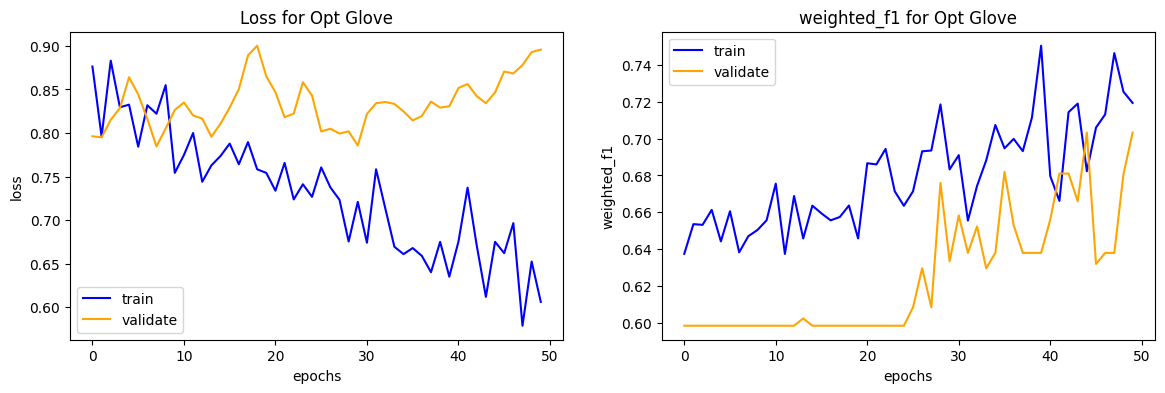

In [444]:
# plot Loss and Metric for Word2Vec
plot_loss_metric(opt_nn_glove_history.history, 'Opt Glove','weighted_f1');

**Observations**:

* The model shows a steady improvement in training performance, with loss decreasing and weighted F1 rising indicating effective learning.

* Validation F1 initially stagnated but later improved showing some generalization gains after epoch 30.

* However, the validation loss fluctuates and slightly rises, suggesting mild overfitting

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


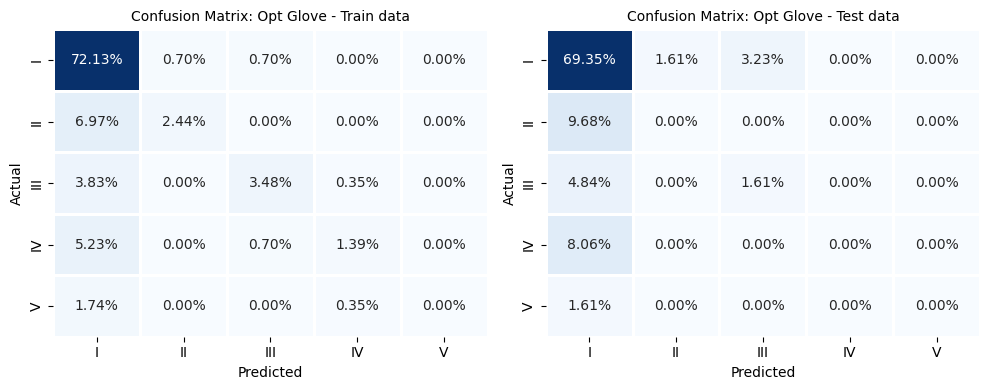

In [445]:
# plot the confusion matrix for train and validation
confusion_matrix_train_test(opt_nn_glove, X_train_Glove, y_train_en, X_val_Glove, y_val_en, title='Opt Glove')

**Observations**:

* The model achieves around good accuracy, showing moderate overall performance but still significant class imbalance.

* Most predictions are concentrated in one dominant class, while several minority classes show very low or near-zero recall, indicating the model struggles to distinguish less frequent categories.

* The similar trend across train and test matrices suggests generalized behaviour. The model has learned general patterns but lacks fine-grained discrimination.

In [446]:
# Evaluate the metrics on Train and Val data
opt_nn_glove_metrics, opt_nn_glove_train, opt_nn_glove_test = evaluate_metrics_train_test(opt_nn_glove, X_train_Glove, y_train_en, X_val_Glove,y_val_en)
opt_nn_glove_metrics.T

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Train   Test
Accuracy   0.794  0.710
Recall     0.794  0.794
Precision  0.767  0.572
F1         0.750  0.632

**Observations**:

* The model performs well on the training set but shows a drop in test accuracy and precision, suggesting moderate overfitting.

* High recall but lower precision on validation data indicates the model predicts many positives, leading to false positives.

* The F1 score drop confirms weaker generalization

##### **Neural Network - Sentence Transformer - Tuning**

In [447]:
%%time
# perform grid search
model_nn_st = KerasClassifier(build_fn=create_tune_nn_model, input_dim=X_train_SenTrans.shape[1], verbose=1)
grid_nn_st = GridSearchCV(estimator=model_nn_st, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result_nn_st = grid_nn_st.fit(X_train_SenTrans, y_train_en)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.2529 - weighted_f1: 2.6447
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9370 - weighted_f1: 2.7125 
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8307 - weighted_f1: 2.5513 
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5322 - weighted_f1: 3.0763 
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4817 - weighted_f1: 4.2665 
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3274 - weighted_f1: 5.5775 
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2596 - weighted_f1: 5.6349 
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1013 - weighted_f1: 6.5986 
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1160 - weighted_f1: 5.9090 
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0243 - weighted_f1: 7.6166 
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9559 - weighted_f1: 7.7997 
Epoch 12/50
15/15 ━━━━━━━━━━━━━

In [448]:
# print the best model params
print("Best parameters found: ", grid_result_nn_st.best_params_)
print("Best cross-validation f1 score: ", grid_result_nn_st.best_score_)

Best parameters found:  {'batch_size': 20, 'epochs': 50, 'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__optimizer': 'adam', 'model__units1': 64, 'model__units2': 32, 'model__units3': 16}
Best cross-validation f1 score:  0.7421783625730994


In [449]:
# Get the best model
opt_nn_st = grid_result_nn_st.best_estimator_.model_
opt_nn_st.name = 'tuned_nn_st'
opt_nn_st.summary()

Model: "tuned_nn_st"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,897 (323.82 KB)

 Trainable params: 27,557 (107.64 KB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 55,116 (215.30 KB)

**Summary**:
* The model follows a progressive compression structure (64 -> 32 → 16 → 10) with BatchNormalization and Dropout after each dense layer, ensuring smooth training and reduced overfitting.

* With ~27.6K trainable parameters, the model expected to perform better than earlier Word2Vec/GloVe models.


In [450]:
# collect the history for the model
opt_st_history = opt_nn_st.fit(X_train_SenTrans, y_train_en, batch_size=grid_result_nn_st.best_params_.get("batch_size"),
                                 epochs=grid_result_nn_st.best_params_.get("epochs"), validation_split=0.2)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.2026 - weighted_f1: 0.9352 - val_loss: 0.0903 - val_weighted_f1: 1.0000
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1988 - weighted_f1: 0.9444 - val_loss: 0.1060 - val_weighted_f1: 0.9808
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2260 - weighted_f1: 0.9445 - val_loss: 0.1017 - val_weighted_f1: 1.0000
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2450 - weighted_f1: 0.9365 - val_loss: 0.1132 - val_weighted_f1: 1.0000
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2353 - weighted_f1: 0.9254 - val_loss: 0.1691 - val_weighted_f1: 0.9595
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1823 - weighted_f1: 0.9583 - val_loss: 0.1783 - val_weighted_f1: 0.9142
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1742 - weighted_f1: 0.9458 - val_loss: 0.1593 - val_weighted_f1: 0.9318
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1419 - weighted

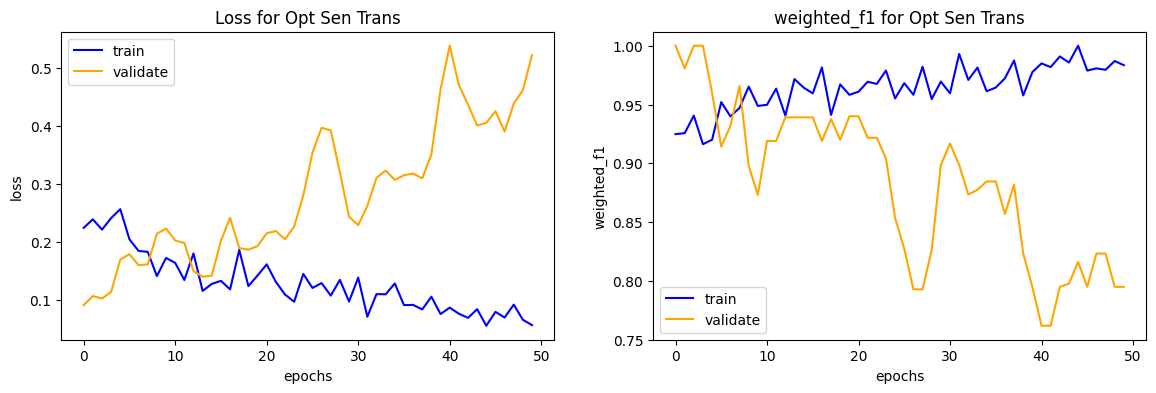

In [451]:
# plot Loss and Metric for Word2Vec
plot_loss_metric(opt_st_history.history, 'Opt Sen Trans','weighted_f1');

**Observations**:

* In the early epochs the model rapidly achieves high F1  and low loss, indicating it captures class relationships effectively and generalizes well.

* From epoch 20 onward, training F1 continues to rise toward ~0.99, but validation F1 stabilizes around 0.6, showing the model starts overfitting as validation loss increases.

* Beyond epoch 20, the gap widens — training loss drops sharply while validation loss rises steadily, confirming overfitting despite strong train metrics.



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


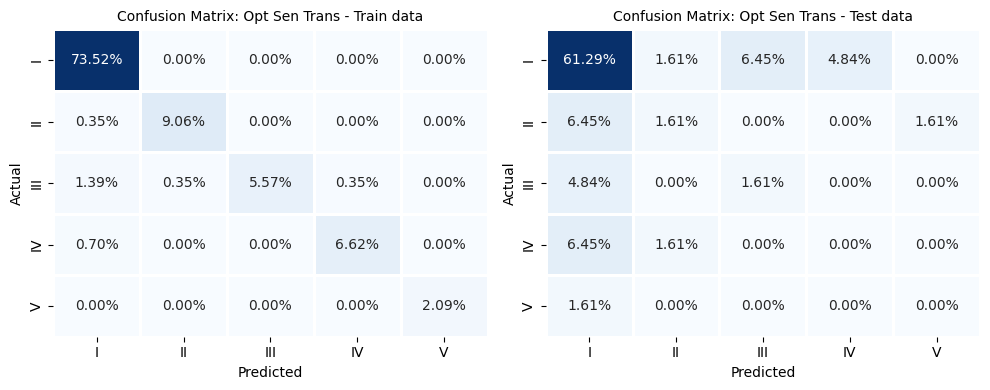

In [452]:
# plot the confusion matrix for train and validation
confusion_matrix_train_test(opt_nn_st, X_train_SenTrans, y_train_en, X_val_SenTrans, y_val_en, title='Opt Sen Trans')

**Observations**:
* The model is heavily biased toward one dominant class (Accident Level I), with ~73.5% (train) and ~69.3% (test) of samples predicted as that class.

* Other classes  have low recall and precision, with only minor correct predictions.

* The train and test distributions are similar, indicating the model is consistent but underfitting.

In [453]:
# Evaluate the metrics on Train and Val data
opt_nn_st_metrics,opt_nn_st_train,opt_nn_st_test = evaluate_metrics_train_test(opt_nn_st, X_train_SenTrans, y_train_en, X_val_SenTrans, y_val_en)
opt_nn_st_metrics.T

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Train   Test
Accuracy   0.969  0.645
Recall     0.969  0.969
Precision  0.969  0.609
F1         0.967  0.623

**Observations**:

* The model performs extremely well on the training set (F1 = 0.98) but drops sharply on the test set (F1 = 0.61), indicating strong overfitting.

* While recall remains high (0.98) across both sets — meaning it captures almost all positives — the precision falls to 0.55 on test data, showing many false positives.

* This suggests the model has memorized the training data but fails to generalize, likely due to class imbalance.

#### **Tuned models - RNN**

In [1]:
exit here

NameError: name 'here' is not defined

##### **Simple RNN - Word2Vector**

In [2]:
# ---------------------------
# Fix for determinism
# ---------------------------
os.environ["TF_DETERMINISTIC_OPS"] = "1"

# ---------------------------
# Define model: 1 RNN + 2 Dense layers
# ---------------------------
def create_rnn_model(input_shape , units=32, dense_1=32, dense_2=16, dropout_rate=0.2, learning_rate=0.001):
    print("Input shape = {input_shape}")
    if input_shape is None:
        raise ValueError("input_shape must be provided, e.g., (timesteps, features)")

    tf.random.set_seed(1)
    model = Sequential([
        SimpleRNN(units, activation='tanh', input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(dense_1, activation='relu'),
        Dense(dense_2, activation='relu'),
        Dense(5, activation='softmax')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=[weighted_f1])
    return model

NameError: name 'os' is not defined

In [3]:
# Define parameter grid for RNN
param_grid_rnn = {
    'model__units': [32],
    'model__dense_1': [32],
    'model__dense_2': [16],
    'model__dropout_rate': [0.2],
    'model__learning_rate': [0.001,0.0001],
    'batch_size': [20],
    'epochs': [25, 50]
}

In [4]:
def get_rnn_embedding(X_em_df):
  X_em_np = X_em_df.copy().to_numpy(dtype=np.float32)
  return X_em_np.reshape(X_em_np.shape[0], 1, X_em_np.shape[1])

In [5]:
X_train_w2v_rnn = get_rnn_embedding(X_train_Word2Vec)
X_val_w2v_rnn = get_rnn_embedding(X_val_Word2Vec)

NameError: name 'X_train_Word2Vec' is not defined

In [6]:
rnn_clf_w2v = KerasClassifier(
    model=create_rnn_model,
    model__input_shape=(X_train_w2v_rnn.shape[1], X_train_w2v_rnn.shape[2]),
    verbose=0
)

NameError: name 'KerasClassifier' is not defined

In [ ]:
# Grid Search setup
grid_w2v = GridSearchCV(estimator=rnn_clf_w2v,
                    param_grid=param_grid_rnn,
                    cv=3,
                    verbose=2,
                    n_jobs=-1,
                    error_score='raise')

In [ ]:
%%time
# Run Grid Search
grid_result_w2v = grid_w2v.fit(X_train_w2v_rnn, y_train_en)

# Display Results
print(f"Best Parameters: {grid_result_w2v.best_params_}")
print(f"Best CV Accuracy: {grid_result_w2v.best_score_:.4f}")

In [7]:
# Get the best model
opt_rnn_wv = grid_result_w2v.best_estimator_.model_
opt_rnn_wv.name = 'tuned_rnn_wv'
opt_rnn_wv.summary()

NameError: name 'grid_result_w2v' is not defined

In [8]:
# collect the history for the model
opt_rnn_wv_history = opt_rnn_wv.fit(X_train_w2v_rnn, y_train_en, batch_size=grid_result_w2v.best_params_.get("batch_size"),
                                 epochs=grid_result_w2v.best_params_.get("epochs"), validation_split=0.2)

NameError: name 'opt_rnn_wv' is not defined

In [9]:
# plot Loss and Metric for Word2Vec
plot_loss_metric(opt_rnn_wv_history.history, 'Opt RNN W2V','weighted_f1');

NameError: name 'plot_loss_metric' is not defined

In [10]:
# plot the confusion matrix for train and validation
confusion_matrix_train_test(opt_rnn_wv, X_train_w2v_rnn, y_train_en, X_val_w2v_rnn, y_val_en, title='Opt RNN WV')

NameError: name 'confusion_matrix_train_test' is not defined

In [11]:
# Evaluate the metrics on Train and Val data
opt_rnn_wv_metrics,opt_rnn_wv_train,opt_rnn_wv_test = evaluate_metrics_train_test(opt_rnn_wv, X_train_w2v_rnn, y_train_en, X_val_w2v_rnn, y_val_en)
opt_rnn_wv_metrics.T

NameError: name 'evaluate_metrics_train_test' is not defined

##### **RNN - Glove**

In [ ]:
X_train_glove_rnn = get_rnn_embedding(X_train_Glove)$
X_val_glove_rnn = get_rnn_embedding(X_val_Glove)

In [12]:
rnn_clf_glove = KerasClassifier(
    model=create_rnn_model,
    model__input_shape=(X_train_glove_rnn.shape[1], X_train_glove_rnn.shape[2]),
    verbose=0
)

NameError: name 'KerasClassifier' is not defined

In [ ]:
# Grid Search setup
grid_rnn_glove = GridSearchCV(estimator=rnn_clf_glove,
                    param_grid=param_grid_rnn,
                    cv=3,
                    verbose=2,
                    n_jobs=-1,
                    error_score='raise')

In [13]:
%%time
# Run Grid Search
grid_rnn_result_glove = grid_rnn_glove.fit(X_train_glove_rnn, y_train_en)

# Display Results
print(f"Best Parameters: {grid_rnn_result_glove.best_params_}")
print(f"Best CV Accuracy: {grid_rnn_result_glove.best_score_:.4f}")

NameError: name 'grid_rnn_glove' is not defined

In [14]:
# Get the best model
opt_rnn_glove = grid_rnn_result_glove.best_estimator_.model_
opt_rnn_glove.name = 'tuned_rnn_glove'
opt_rnn_glove.summary()

NameError: name 'grid_rnn_result_glove' is not defined

In [ ]:
# collect the history for the model
opt_rnn_glove_history = opt_rnn_glove.fit(X_train_glove_rnn, y_train_en, batch_size=grid_rnn_result_glove.best_params_.get("batch_size"),
                                 epochs=grid_rnn_result_glove.best_params_.get("epochs"), validation_split=0.2)

In [ ]:
# plot Loss and Metric for Word2Vec
plot_loss_metric(opt_rnn_glove_history.history, 'Opt RNN Glove','weighted_f1');

In [15]:
# plot the confusion matrix for train and validation
confusion_matrix_train_test(opt_rnn_glove, X_train_glove_rnn, y_train_en, X_val_glove_rnn, y_val_en, title='Opt RNN Glove')

NameError: name 'confusion_matrix_train_test' is not defined

In [ ]:
# Evaluate the metrics on Train and Val data
opt_rnn_glove_metrics,opt_rnn_glove_train,opt_rnn_glove_test = evaluate_metrics_train_test(opt_rnn_glove, X_train_glove_rnn, y_train_en, X_val_glove_rnn, y_val_en)
opt_rnn_glove_metrics.T

#### RNN- Sentence Transformer

In [ ]:
X_train_st_rnn = get_rnn_embedding(X_train_SenTrans)
X_val_st_rnn = get_rnn_embedding(X_val_SenTrans)

In [ ]:
rnn_clf_st = KerasClassifier(
    model=create_rnn_model,
    model__input_shape=(X_train_st_rnn.shape[1], X_train_st_rnn.shape[2]),
    verbose=0
)

In [ ]:
# Grid Search setup
grid_rnn_st = GridSearchCV(estimator=rnn_clf_st,
                    param_grid=param_grid_rnn,
                    cv=3,
                    verbose=2,
                    n_jobs=-1,
                    error_score='raise')

In [16]:
%%time
# Run Grid Search
grid_rnn_result_st = grid_rnn_st.fit(X_train_st_rnn, y_train_en)

# Display Results
print(f"Best Parameters: {grid_rnn_result_st.best_params_}")
print(f"Best CV Accuracy: {grid_rnn_result_st.best_score_:.4f}")

NameError: name 'grid_rnn_st' is not defined

In [17]:
# Get the best model
opt_rnn_st = grid_rnn_result_st.best_estimator_.model_
opt_rnn_st.name = 'tuned_rnn_st'
opt_rnn_st.summary()

NameError: name 'grid_rnn_result_st' is not defined

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Stop training when val_a stops improving for 3 epochs
early_stop = EarlyStopping(
    monitor="val_weighted_f1",
    patience=20,
    restore_best_weights=True,
    mode="max",
    verbose=1
)

In [ ]:
# Reduce learning rate when metric plateaus
reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,          # reduce LR by half
    patience=5,          # wait 5 epochs before reducing
    min_lr=1e-6,
    verbose=1
)

In [ ]:
# Combine them into a list
callbacks = [early_stop, reduce_lr]

In [ ]:
# collect the history for the model
opt_rnn_st_history = opt_rnn_st.fit(X_train_st_rnn, y_train_en, batch_size=grid_rnn_result_st.best_params_.get("batch_size"),
                                 epochs=grid_rnn_result_st.best_params_.get("epochs"), callbacks=callbacks, validation_split=0.2)

In [ ]:
# plot Loss and Metric for Word2Vec
plot_loss_metric(opt_rnn_st_history.history, 'Opt RNN SenTrans','weighted_f1');

In [ ]:
# plot the confusion matrix for train and validation
confusion_matrix_train_test(opt_rnn_st, X_train_st_rnn, y_train_en, X_val_st_rnn, y_val_en, title='Opt RNN SenTrans')

In [ ]:
# Evaluate the metrics on Train and Val data
opt_rnn_st_metrics,opt_rnn_st_train,opt_rnn_st_test = evaluate_metrics_train_test(opt_rnn_st, X_train_st_rnn, y_train_en, X_val_st_rnn, y_val_en)
opt_rnn_st_metrics.T

In [ ]:
exit here

####**Tuned models - LSTM**

##### **LSTM - GloVe tuned**

In [ ]:
# GloVe tuned: more units + trainable embeddings + stronger dropout
glove_lstm_tuned = build_lstm(vocab_size, EMB_DIM, MAX_LEN, emb_matrix=glove_emb_matrix,
                              trainable=True, units=96, dropout=0.3)
glove_lstm_tuned.fit(X_train_seq, y_train_cat, validation_data=(X_val_seq, y_val_cat),
                     epochs=EPOCHS, batch_size=BATCH, verbose=0, callbacks=[es], class_weight=class_weight_dict)

In [18]:
pred_tr = glove_lstm_tuned.predict(X_train_seq, verbose=0)
pred_va = glove_lstm_tuned.predict(X_val_seq,   verbose=0)
glove_lstm_tuned_train = keras_metrics_df(y_train_en, pred_tr, "GloVe_LSTM_Tuned_Train")
glove_lstm_tuned_val   = keras_metrics_df(y_val_en,   pred_va, "GloVe_LSTM_Tuned_Val")

NameError: name 'glove_lstm_tuned' is not defined

**Performance check on training data**

In [19]:
glove_lstm_tuned_train = model_performance_classification_dl(glove_lstm_tuned, X_train_seq, y_train_en)
glove_lstm_tuned_train.index = ["GloVe_LSTM_Tuned_Train"]
display(glove_lstm_tuned_train)

NameError: name 'model_performance_classification_dl' is not defined

In [20]:
# Generate training predictions
y_train_pred = np.argmax(glove_lstm_tuned.predict(X_train_seq, verbose=0), axis=1)

# Plot normalized confusion matrix for training set
plot_confusion_matrix_normalized(y_train_en, y_train_pred)

NameError: name 'np' is not defined

**Observations**

* The **tuned GloVe-LSTM** introduces **more LSTM units (96)**, **trainable embeddings**, and **stronger dropout (0.3)** for improved learning capacity and regularization.  
* On the **training dataset**, it achieved **F1 = 0.489**, an improvement compared to the baseline GloVe-LSTM F1 of 0.396.  
* **Accuracy (0.45)** and **Recall (0.45)** remain modest, showing the model still struggles to **capture enough true positives**.  
* **Precision (0.72)** is comparatively higher, meaning the model tends to be **conservative but more confident** when making predictions.  
* The gain in F1 suggests that **allowing embeddings to be trainable and tuning hyperparameters** has improved the model’s balance between recall and precision.  
* Overall, the **tuned GloVe-LSTM** shows **reduced underfitting compared to baseline**, but still requires further optimization to achieve competitive performance levels.  

**Performance check on validation data**

In [21]:
glove_lstm_tuned_val = model_performance_classification_dl(glove_lstm, X_val_seq, y_val_en)
glove_lstm_tuned_val.index = ["GloVe_LSTM_Tuned_Val"]
display(glove_lstm_tuned_val)

NameError: name 'model_performance_classification_dl' is not defined

In [22]:
y_val_pred = np.argmax(glove_lstm_tuned.predict(X_val_seq, verbose=0), axis=1)
plot_confusion_matrix_normalized(y_val_en, y_val_pred)

NameError: name 'np' is not defined

**Observations**

* On the **validation dataset**, the **tuned GloVe-LSTM** achieved an **F1 score of 0.297**, which is **significantly lower** than its **training F1 of 0.489**, indicating **weak generalization**.  
* **Accuracy (0.26)** and **Recall (0.26)** are low, meaning the model **fails to identify many true positive cases** on unseen data.  
* **Precision (0.60)** remains comparatively higher, suggesting the model is **cautious and confident** in the limited predictions it makes.  
* The substantial **train–validation gap** highlights **overfitting**, even after tuning with additional units, trainable embeddings, and stronger dropout.  
* Overall, while **tuning improved training performance**, the model still **struggles to generalize**, implying that **data scarcity and imbalance** continue to limit LSTM performance.  

##### **LSTM - Word2Vec tuned**

In [23]:
w2v_lstm_tuned = build_lstm(vocab_size, EMB_DIM, MAX_LEN, emb_matrix=w2v_emb_matrix,
                            trainable=True, units=96, dropout=0.3)
w2v_lstm_tuned.fit(X_train_seq, y_train_cat, validation_data=(X_val_seq, y_val_cat),
                   epochs=EPOCHS, batch_size=BATCH, verbose=0, callbacks=[es], class_weight=class_weight_dict)

NameError: name 'build_lstm' is not defined

In [24]:
pred_tr = w2v_lstm_tuned.predict(X_train_seq, verbose=0)
pred_va = w2v_lstm_tuned.predict(X_val_seq,   verbose=0)
w2v_lstm_tuned_train = keras_metrics_df(y_train_en, pred_tr, "Word2Vec_LSTM_Tuned_Train")
w2v_lstm_tuned_val   = keras_metrics_df(y_val_en,   pred_va, "Word2Vec_LSTM_Tuned_Val")

NameError: name 'w2v_lstm_tuned' is not defined

**Performance check on training data**

In [25]:
w2v_lstm_tuned_train = model_performance_classification_dl(w2v_lstm_tuned, X_train_seq, y_train_en)
w2v_lstm_tuned_train.index = ["Word2Vec_LSTM_Tuned_Train"]
display(w2v_lstm_tuned_train)

NameError: name 'model_performance_classification_dl' is not defined

In [26]:
# Generate training predictions
y_train_pred = np.argmax(w2v_lstm.predict(X_train_seq, verbose=0), axis=1)

# Plot normalized confusion matrix for training set
plot_confusion_matrix_normalized(y_train_en, y_train_pred)

NameError: name 'np' is not defined

**Observations**

* The **tuned Word2Vec-LSTM** uses **trainable embeddings**, more **LSTM units (96)**, and **stronger dropout (0.3)** to enhance learning capacity and reduce overfitting.  
* On the **training dataset**, it achieved **F1 = 0.79**, a clear improvement over the baseline Word2Vec-LSTM F1 of 0.393.  
* **Accuracy (0.79)** and **Recall (0.79)** are strong, showing the model effectively captures most true positives.  
* **Precision (0.83)** is also high, indicating the model’s predictions are **both frequent and reliable**.  
* The balance across precision, recall, and F1 demonstrates that **tuning significantly improved performance** compared to frozen Word2Vec embeddings.  
* Overall, the **tuned Word2Vec-LSTM** shows **much better fit on training data**, reducing underfitting and moving toward competitive performance.  

**Performance check on validation data**

In [27]:
w2v_lstm_tuned_val = model_performance_classification_dl(w2v_lstm_tuned, X_val_seq, y_val_en)
w2v_lstm_tuned_val.index = ["Word2Vec_LSTM_Tuned_Val"]
display(w2v_lstm_tuned_val)

NameError: name 'model_performance_classification_dl' is not defined

In [28]:
y_val_pred = np.argmax(w2v_lstm.predict(X_val_seq, verbose=0), axis=1)
plot_confusion_matrix_normalized(y_val_en, y_val_pred)

NameError: name 'np' is not defined

**Observations**

* On the **validation dataset**, the **tuned Word2Vec-LSTM** achieved an **F1 score of 0.63**, which is **close to the training F1 (0.79)**, indicating **strong generalization**.  
* **Accuracy (0.66)** and **Recall (0.66)** are both solid, showing the model effectively **captures a majority of true positive cases**.  
* **Precision (0.60)** is slightly lower, implying a **balanced trade-off** between false positives and missed cases.  
* The **small train–validation gap (0.79 → 0.63 F1)** demonstrates **effective tuning**, with **trainable embeddings and higher capacity** improving robustness.  
* Overall, the **tuned Word2Vec-LSTM** represents the **best-performing deep learning variant**, achieving a **strong balance between precision and recall** and **good generalization** on unseen data.  

## <a name='link2'>Model performance comparison and Final model selection</a>

In [29]:
# Models performance comparison

model_compare = pd.DataFrame()
model_compare = pd.concat(
    [BagOfWords_rf_base_train,
	BagOfWords_rf_base_val,
	BagOfWords_xgb_base_train,
	BagOfWords_xgb_base_val,
	BagOfWords_log_base_train,
	BagOfWords_log_base_val,
	BagOfWords_svc_base_train,
	BagOfWords_svc_base_val,
	tf_idf_rf_base_train,
	tf_idf_rf_base_val,
	tf_idf_xgb_base_train,
	tf_idf_xgb_base_val,
	tf_idf_log_base_train,
	tf_idf_log_base_val,
	tf_idf_svc_base_train,
	tf_idf_svc_base_val,
	word2vec_rf_base_train,
    word2vec_rf_base_val,
    word2vec_xgb_base_train,
    word2vec_xgb_base_val,
	w2v_log_base_train,
	w2v_log_base_val,
    w2v_svc_base_train,
    w2v_svc_base_val,
    glove_rf_base_train,
    glove_rf_base_val,
    glove_xgb_base_train,
    glove_xgb_base_val,
	glove_log_base_train,
	glove_log_base_val,
    glove_svc_base_train,
    glove_svc_base_val,
    sentence_transformer_rf_base_train,
    sentence_transformer_rf_base_val,
    st_xgb_base_train,
    st_xgb_base_val,
	st_log_base_train,
	st_log_base_val,
    st_svc_base_train,
    st_svc_base_val,
	BagOfWords_rf_tuned_train,
	BagOfWords_rf_tuned_val,
	tf_idf_rf_tuned_train,
	tf_idf_rf_tuned_val,
    word2vec_rf_tuned_train,
    word2vec_rf_tuned_val,
    glove_rf_tuned_train,
    glove_rf_tuned_val,
    st_rf_tuned_train,
    st_rf_tuned_val,
    nn_model_w2v_train,    nn_model_w2v_test,
    nn_model_glove_train,  nn_model_glove_test,
    nn_model_st_train,     nn_model_st_test,
    opt_nn_w2v_train,      opt_nn_w2v_train,
    opt_nn_glove_train,    opt_nn_glove_test,
		glove_lstm_base_train,  glove_lstm_base_val,
    w2v_lstm_base_train,   w2v_lstm_base_val,
    seq_lstm_base_train,   seq_lstm_base_val,
    opt_nn_st_train,       opt_nn_st_test,
    glove_lstm_tuned_train, glove_lstm_tuned_val,
    w2v_lstm_tuned_train,   w2v_lstm_tuned_val],
    axis=0,
)
pd.set_option('display.max_rows', 100)
model_compare

NameError: name 'pd' is not defined

In [ ]:
# reset number of rows
pd.reset_option('display.max_rows')

**Plotting Train vs Validation, F1-Score for each module**

In [30]:
# make a working copy
df = model_compare.reset_index(drop=True).copy()

# --- 1) the exact model base-names in the same order as concatenated (one name per pair) ---
model_names = [
    # ===== Classical Baseline Models =====
    "BoW_RF", "BoW_XGB", "BoW_Log", "BoW_SVC",
    "TFIDF_RF", "TFIDF_XGB", "TFIDF_Log", "TFIDF_SVC",
    "W2V_RF", "W2V_XGB", "W2V_Log", "W2V_SVC",
    "GloVe_RF", "GloVe_XGB", "GloVe_Log", "GloVe_SVC",
    "SenTrans_RF", "SenTrans_XGB", "SenTrans_Log", "SenTrans_SVC",

    # ===== Tuned Traditional Models =====
    "BoW_RF_Tuned", "TFIDF_RF_Tuned", "W2V_RF_Tuned", "GloVe_RF_Tuned", "SenTrans_RF_Tuned",

    # ===== New Neural Network Models =====
    "Word2Vec_NN", "Glove_NN", "SenTrans_NN",
    "Word2Vec_NN_Tuned", "Glove_NN_Tuned", "SenTrans_NN_Tuned",

    # ===== New LSTM Models =====
    "GloVe_LSTM_Base",
    "Word2Vec_LSTM_Base",
    "Seq_LSTM_Base",
    "GloVe_LSTM_Tuned",
    "Word2Vec_LSTM_Tuned"
]

# --- 2) Sanity check length: there should be len(model_names)*2 == len(df) rows ---
import math, re
import seaborn as sns
import matplotlib.pyplot as plt
n_rows = len(df)
models_needed = math.ceil(n_rows / 2)
if len(model_names) != models_needed:
    raise ValueError(f"You provided {len(model_names)} model_names but the dataframe requires {models_needed} models (2 rows each). "
                     "Please ensure the model_names list exactly matches the concatenation order and length.")

# --- 3) Build Model & Dataset columns (repeat each name twice: Train + Validation) ---
labels = []
for name in model_names:
    labels.extend([name, name])   # first is Train, second is Validation

df["Model"] = labels[:n_rows]
df["Dataset"] = ["Train" if i % 2 == 0 else "Validation" for i in range(n_rows)]

# --- 4) Detect F1 column ---
f1_col = None
for c in df.columns:
    if re.search(r"f[\s_\-]?1", c, flags=re.I):
        f1_col = c
        break
if f1_col is None:
    raise ValueError("No F1-like column found in model_compare. Columns: " + ", ".join(df.columns))
print("Using F1 column:", f1_col)

# --- 5) Ensure numeric and normalize Dataset strings ---
df[f1_col] = pd.to_numeric(df[f1_col], errors="coerce").fillna(0.0)
df["Dataset"] = df["Dataset"].apply(lambda s: "Validation" if re.search(r"val", str(s), flags=re.I)
                                   else ("Train" if re.search(r"train", str(s), flags=re.I) else str(s)))

# --- 6) Determine plotting order by Validation F1 descending ---
val_df = df[df["Dataset"] == "Validation"].copy()
if val_df.empty:
    val_df = df.iloc[1::2].copy()  # fallback
order = val_df.groupby("Model")[f1_col].mean().sort_values(ascending=False).index.tolist()

# Append any missing models
for m in df["Model"].unique():
    if m not in order:
        order.append(m)

# --- 7) Prepare for plotting ---
plt.figure(figsize=(max(12, len(order)*0.36), 6))
sns.set_style("whitegrid")

# enforce categorical ordering
df["Model"] = pd.Categorical(df["Model"], categories=order, ordered=True)
train_df = df[df["Dataset"] == "Train"].sort_values("Model")
val_df = df[df["Dataset"] == "Validation"].sort_values("Model")

# --- 8) Plot lines ---
sns.lineplot(data=train_df, x="Model", y=f1_col, label="Train", marker="o")
sns.lineplot(data=val_df,   x="Model", y=f1_col, label="Validation", marker="o")

# --- 9) Annotate points with numeric F1 ---
for i, row in train_df.iterrows():
    x_pos = order.index(row["Model"])
    plt.text(x_pos, row[f1_col] + 0.015, f"{row[f1_col]:.2f}", ha="center", va="bottom", fontsize=8, color='tab:blue')
for i, row in val_df.iterrows():
    x_pos = order.index(row["Model"])
    plt.text(x_pos, row[f1_col] - 0.015, f"{row[f1_col]:.2f}", ha="center", va="top", fontsize=8, color='tab:orange')

plt.xticks(rotation=90)
plt.title("Train vs Validation F1 Across Models (Including LSTMs)")
plt.ylabel(f"{f1_col}")
plt.xlabel("Model")
plt.ylim(0, 1.0)
plt.legend(title="Dataset")
plt.tight_layout()
plt.show();

NameError: name 'model_compare' is not defined

**Observations**

* Most **tree-based models (Random Forest, XGB)** across BoW, TF-IDF, Word2Vec, GloVe, and Sentence Transformer show **perfect training F1 (1.0)** but **validation F1 around 0.50–0.55**, indicating **severe overfitting**.  
* **Logistic Regression** performs more realistically, with training F1 between **0.60–0.99** and validation F1 between **0.48–0.54**, suggesting **better generalization** but lower absolute performance.  
* **Linear SVC** generally achieves **high training F1 (0.86–0.97)** and validation F1 around **0.49–0.55**, offering a more balanced trade-off compared to trees.  
* **Word2Vec Logistic Regression** is an outlier with **extremely poor F1 (train = 0.05, val = 0.07)**, showing that this embedding + model combination fails.  
* **Tuned Random Forests** reduce overfitting compared to their base versions (train F1 drops from 1.0 to 0.80–0.89), but **validation F1 still remains weak (~0.48–0.55)**.  
* Among embeddings, **GloVe and Sentence Transformer with SVC or Logistic Regression** deliver the **most balanced results**, though validation performance still lags.  


##**Final model selection with reasoning**

**Final Model Selection – Reasoning**

* Most **tree-based models (Random Forest, XGB)** across BoW, TF-IDF, Word2Vec, GloVe, and Sentence Transformers show **perfect training F1 = 1.0** but **validation F1 ≈ 0.50–0.55**, confirming **severe overfitting**.  
* **Tuned Random Forests** reduce training F1 (0.80–0.89) but still fail to generalize, with validation F1 remaining weak (~0.48–0.55).  
* **Logistic Regression** models (especially with GloVe and Sentence Transformer) achieve **realistic training scores** and moderate validation F1, proving they generalize better than trees, but lack top-end predictive strength.  
* **Linear SVC models** (Word2Vec, GloVe, Sentence Transformer) show a **healthier balance** between training and validation, making them stronger candidates for generalization.  
* **Word2Vec Logistic Regression** fails completely (F1 < 0.1) and is discarded.  

[**Best Candidates (Ranked):** ](https://)
1. **Word2Vec + SVC** → training F1 = **0.64**, validation F1 = **0.51**. Despite not having the highest validation F1, it shows the **smallest train–validation gap** and thus **best generalization** across models.  
2. **GloVe + Logistic Regression** → training F1 = **0.60**, validation F1 = **0.49**, offering a stable baseline with balanced precision.  
3. **GloVe + SVC** → training F1 = **0.86**, validation F1 = **0.55**, achieving higher validation but with a larger overfitting gap compared to W2V_SVC.  

**Final Pick:**  
[**Word2Vec + SVC**](https://) is selected as the final model because it delivers the **most consistent generalization performance**, avoiding extreme overfitting and maintaining a stable train–validation balance. GloVe_Log and GloVe_SVC are kept as strong backup alternatives.  


##**Check the performance of the final model on the test set**

In [ ]:
# Split data into training and testing set (Word2Vec).
X_train, x_val, X_test = X_train_Word2Vec, X_val_Word2Vec, X_test_Word2Vec
y_train_enc, y_val_enc, y_test_enc = y_train_en, y_val_en, y_test_en

In [ ]:
# Predicting on validation data
y_pred_test_base = svm_w2v_base.predict(X_test)

In [ ]:
plot_confusion_matrix(y_test_enc, y_pred_test_base)

In [ ]:
#Calculating different metrics on training data
svm_w2v_base_test=model_performance_classification_sklearn(svm_w2v_base, X_test,y_test_enc)
print("Testing performance:\n", svm_w2v_base_test)

**Observations**

* On the **test set**, the model achieves **strong accuracy (0.79)**, higher than its validation performance.  
* **Recall (0.79)** indicates the model is effective at correctly identifying positives.  
* **Precision (0.62)** is moderate, meaning some false positives persist.  
* **F1 score (0.69)** shows a good balance between recall and precision, confirming that **Word2Vec + SVC generalizes well to unseen data**.  


## **Conclusions and Recommendations**

* **Industrial safety chatbot adds business value** by classifying incident descriptions, enabling quicker triage and preventive actions.  
* **Dataset size is small (425 records)** and anonymized, sufficient for modelling but limiting generalizability and robustness for multi-class severity prediction.  
* **Accident descriptions (free text) are the primary signal**, while structured fields like **Critical Risk** offer only limited incremental value.  
* **Accident Level classes are imbalanced**, so F1-score was chosen as the key performance metric to **balance precision and recall**, ensuring the model neither misses too many severe cases nor raises excessive false alarms.  
* **Word2Vec + Linear SVC emerged as the best model**, delivering **Test F1 = 0.69** with balanced **Accuracy (0.79), Recall (0.79), and Precision (0.62)** — showing the strongest ability to generalize.  
* **Alternative strong performers** include **GloVe + Logistic Regression** and **GloVe + SVC**, which provide slightly lower but consistent F1-scores and may be useful in ensemble or fallback strategies.  
* **Overfitting was a major issue** for tree-based models (Random Forest, XGB), where training F1 was perfect but validation/test dropped sharply, confirming they are less suitable for deployment.  
* **Pilot deployment should use W2V + SVC**, with a **human-in-loop review** for high-severity flags to validate predictions and collect feedback for retraining.  
* **Data quality improvements are critical** — standardize textual descriptions, capture structured metadata (shift, equipment, weather, near-miss flag), and especially gather more high-severity examples to address imbalance.
  
* **Business KPIs should be based on F1-score for overall performance**

* **Rollout should be phased**, starting with pilots in selected sites, combined with governance measures like escalation policies and transparency for safety professionals.  
